## Imports



In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import time
import math
import itertools
import numpy as np
from scipy.special import binom
from functools import partial
import scipy.stats
from scipy.stats import bernoulli
from dataclasses import dataclass, asdict
import sklearn.metrics as metrics
from textwrap import wrap
import random

import jax
import jax.numpy as jnp
import jax.nn as jnn


In [ ]:
# basic configuration
n_rssi_buckets = 4
n_infect_levels = 3
rssi_lowest_th = -120
n_rssi_th = n_rssi_buckets-1  # number of thresholds for rssi buckets
model_dim = 1 + n_rssi_buckets + n_rssi_th + n_infect_levels  # total number of parameters

## Model parameterization 



In [ ]:
def get_init_parameters(rssi_th=None):
  """Initial (residual) parameters for learning. """

  # overall scaling
  beta = 0.1

  # rssi weights
  residual_rssi_w = np.random.rand(n_rssi_buckets - 1) * 0.01
  rssi_w = [None] * n_rssi_buckets
  rssi_w[0] = np.random.rand() * 0.01
  for i in range(n_rssi_buckets - 1):
    rssi_w[i + 1] = rssi_w[i] + residual_rssi_w[i]

  # rssi thresholds
  if rssi_th is None:
    residual_rssi_th = np.random.randint(low=10, high=40, size=n_rssi_th)
    # residual_rssi_th = [30, 20, 30]
    rssi_th = [None] * n_rssi_th
    prev = rssi_lowest_th
    for i in range(n_rssi_th):
      rssi_th[i] = prev + residual_rssi_th[i]
      prev = rssi_th[i]

  # infectiousness weights
  residual_infect_w = np.random.rand(n_infect_levels) * 0.01
  infect_w = [None] * n_infect_levels
  infect_w[0] = np.random.rand() * 0.01
  for i in range(n_infect_levels - 1):
    infect_w[i + 1] = infect_w[i] + residual_infect_w[i]


  # score parameters (parameters used for calculating score)
  weights_score = [None] * model_dim
  weights_score[0] = beta 
  ind = 1
  weights_score[ind:ind+n_rssi_buckets] = rssi_w
  ind += n_rssi_buckets
  weights_score[ind:ind+n_rssi_th] = rssi_th
  ind += n_rssi_th
  weights_score[ind:ind+n_infect_levels] = infect_w

  # convert to residual parameters  
  weights_residual = get_residual_parameters(weights_score)  
  return weights_residual


def get_residual_parameters(weights, n_rssi_buckets=4):
  """Transform scoring parameters to learnable residual parameters. Inverse transform of 'get_scoring_parameters()'. 
  weights: scoring parameters
  """ 
  n_rssi_th = n_rssi_buckets - 1
  weights = np.array(weights)
  beta = weights[0] 
  ind = 1
  rssi_w = weights[ind:ind+n_rssi_buckets]
  ind += n_rssi_buckets
  rssi_th = weights[ind:ind+n_rssi_th]
  ind += n_rssi_th
  infect_w = weights[ind:ind+n_infect_levels]
  
  # rssi weights
  residual_rssi_w = [None] * n_rssi_buckets
  w_prev = 0
  for i in range(n_rssi_buckets):
    residual_rssi_w[i] = rssi_w[i] - w_prev
    w_prev = rssi_w[i]

  # rssi bucket thresholds
  residual_rssi_th = [None] * n_rssi_th
  th_prev = rssi_lowest_th
  for i in range(n_rssi_th):
    residual_rssi_th[i] = rssi_th[i] - th_prev
    th_prev = rssi_th[i]

  # infectiousness weights
  residual_infect_w = [None] * n_infect_levels
  w_prev = 0
  for i in range(n_infect_levels):
    residual_infect_w[i] = infect_w[i] - w_prev
    w_prev = infect_w[i]


  weights_residual = [beta,] + residual_rssi_w + residual_rssi_th + list(residual_infect_w)
  return np.asarray(weights_residual)


@partial(jax.jit, static_argnums=(1,))
def get_scoring_parameters(weights, n_rssi_buckets):
  """Transform residual parameters to scoring parameters (that respect monotonocity constraints). 
  weights: residual parameters (nonnegative)
  """    
  n_rssi_th = n_rssi_buckets - 1
  beta = weights[0]
  ind = 1
  residual_rssi_w = weights[ind:ind+n_rssi_buckets]
  ind += n_rssi_buckets
  residual_rssi_th = weights[ind:ind+n_rssi_th]
  ind += n_rssi_th
  residual_infect_w = weights[ind:ind+n_infect_levels]

  # rssi weights
  rssi_w = [None] * n_rssi_buckets
  w_prev = 0
  for i in range(n_rssi_buckets):
    rssi_w[i] = w_prev + residual_rssi_w[i]
    w_prev = rssi_w[i]    

  # rssi thresholds
  rssi_th = [None] * n_rssi_th
  w_prev = rssi_lowest_th
  for i in range(n_rssi_th):
    rssi_th[i] = w_prev + residual_rssi_th[i]
    w_prev = rssi_th[i]    

  # infectiousness weights
  infect_w = [None] * n_infect_levels
  w_prev = 0
  for i in range(n_infect_levels):
    infect_w[i] = w_prev + residual_infect_w[i]
    w_prev = infect_w[i]

  weights_scoring = [None] * model_dim
  weights_scoring[0] = beta
  ind = 1
  weights_scoring[ind:ind+n_rssi_buckets] = rssi_w
  ind += n_rssi_buckets
  weights_scoring[ind:ind+n_rssi_th] = rssi_th
  ind += n_rssi_th
  weights_scoring[ind:ind+n_infect_levels] = infect_w  
  return weights_scoring



def print_params(weights, n_rssi_buckets=4):
  """print parameters"""
  n_rssi_th = n_rssi_buckets-1
  beta = weights[0]
  ind = 1
  rssi_w = weights[ind:ind+n_rssi_buckets]
  ind += n_rssi_buckets
  rssi_th = weights[ind:ind+n_rssi_th]
  ind += n_rssi_th
  infect_w = weights[ind:ind+n_infect_levels]
  print ('\tbeta: {:.6f}'.format(beta))
  print ('\trssi_w: {}'.format([round(w,3) for w in rssi_w]))
  print ('\trssi_th: {}'.format([round(w,4) for w in rssi_th]))
  print ('\tinfectiousness: {}'.format([round(w,2) for w in infect_w]))



## Hazard and Loss function

In [ ]:
# @partial(jax.jit, static_argnums=())
def hazard_sigmoid_buckets(features, weights, sigmoid_temp):
  """Implement multi-linear hazard function with sigmoid buckets."""
  f_rssi = features[0]  
  f_duration = features[1]
  f_infectiousness = features[2]
  
  # transform residual model parameters to scoring parameters
  weights_scoring = get_scoring_parameters(weights, n_rssi_buckets)
  beta = weights_scoring[0]
  ind = 1
  rssi_w = weights_scoring[ind:ind+n_rssi_buckets]
  ind += n_rssi_buckets
  rssi_th = weights_scoring[ind:ind+n_rssi_th]
  ind += n_rssi_th
  infect_w = weights_scoring[ind:ind+n_infect_levels]

  # compute scores
  rssi_score = 0    
  rssi_score += rssi_w[0] *  jnp.sum(jnn.sigmoid(-sigmoid_temp * (f_rssi - rssi_th[0])) * jnn.sigmoid(10. * (f_rssi - rssi_lowest_th)))

  for i in range(1, n_rssi_buckets - 1):
    t1 = rssi_th[i - 1]
    t2 = rssi_th[i]
    rssi_score += rssi_w[i] * jnp.sum(jnn.sigmoid(sigmoid_temp * (f_rssi - t1)) * jnn.sigmoid(-sigmoid_temp *
                                                              (f_rssi - t2)))
  rssi_score += rssi_w[-1] * jnp.sum(jnn.sigmoid(sigmoid_temp * (f_rssi - t2)))
  rssi_score *= f_duration

  # infectiousness score  
  infectiousness_bucket = jax.nn.one_hot(
      f_infectiousness, num_classes=n_infect_levels)
  infectiousness_score = jnp.sum(
      jnp.multiply(jnp.array(infect_w), infectiousness_bucket))

  score = beta * rssi_score * infectiousness_score
  return score


# @partial(jax.jit, static_argnums=())
def hazard_step_buckets(features, weights, n_rssi_buckets):
  """Implement multi-linear hazard function with step buckets."""
  f_rssi = features[0]  
  f_duration = features[1]
  f_infectiousness = features[2]
  
  # transform residual model parameters to scoring parameters
  n_rssi_th = n_rssi_buckets - 1
  weights_scoring = get_scoring_parameters(weights, n_rssi_buckets)
  beta = weights_scoring[0] 
  ind = 1
  rssi_w = weights_scoring[ind:ind+n_rssi_buckets]
  ind += n_rssi_buckets
  rssi_th = weights_scoring[ind:ind+n_rssi_th]
  ind += n_rssi_th
  infect_w = weights_scoring[ind:ind+n_infect_levels]

  # compute scores
  rssi_score = 0
  # ones_arr = jnp.ones_like(f_rssi)
  # zeros_arr = jnp.zeros_like(rssi)
  rssi_bucket = jax.nn.one_hot(jnp.digitize(f_rssi,rssi_th), num_classes=n_rssi_buckets)
  rssi_score = jnp.sum(jnp.multiply(jnp.array(rssi_w), rssi_bucket)) * f_duration

  # infectiousness score  
  infectiousness_bucket = jax.nn.one_hot(
      f_infectiousness, num_classes=n_infect_levels)
  infectiousness_score = jnp.sum(
      jnp.multiply(jnp.array(infect_w), infectiousness_bucket))

  score = beta * rssi_score * infectiousness_score
  return score


def prob_infected_step(exposures, weights):
  """Probability of infection with step buckets."""
  h = hazard_step_buckets(exposures, weights, n_rssi_buckets)
  p_infected = 1 - jnp.exp(-1 * h)
  p_infected = jnp.clip(p_infected, 1e-5, 1. - 1e-5)  # QUESTION
  return p_infected

def prob_infected(exposures, weights, sigmoid_temp):
  """Probability of infection with sigmoid buckets."""  
  h = hazard_sigmoid_buckets(exposures, weights, sigmoid_temp)
  p_infected = 1 - jnp.exp(-1 * h)
  p_infected = jnp.clip(p_infected, 1e-5, 1. - 1e-5)
  return p_infected

# Jax vectorized functions
hazard_sigmoid_buckets_v = jax.jit(
    jax.vmap(hazard_sigmoid_buckets, (0, None, None), 0), static_argnums=())

hazard_step_buckets_v = jax.jit(
    jax.vmap(hazard_step_buckets, (0, None, None), 0), static_argnums=(2,))

prob_infected_v = jax.jit(
    jax.vmap(prob_infected, (0, None, None), 0), static_argnums=())

prob_infected_step_v = jax.jit(
    jax.vmap(prob_infected_step, (0, None), 0), static_argnums=())


def loss_fn_ce(params,
               batch_x,
               batch_y,
               assign_mat,               
               sigmoid_temp,               
               return_aux=True):
  """ Cross entropy loss with sigmoid bin hazard."""
  scores = hazard_sigmoid_buckets_v(batch_x, params, sigmoid_temp)
  bag_scores = jnp.dot(assign_mat, scores)    
  bag_probs = 1 - jnp.exp(-1 * bag_scores)
  bag_probs = jnp.clip(bag_probs, 1e-5, 1-1e-5)
  loss = -1 * jnp.mean(batch_y * jnp.log(bag_probs) +
                       (1 - batch_y) * jnp.log(1 - bag_probs))
  if return_aux:
    return loss, bag_probs
  else:
    return loss


def loss_fn_stepbins_ce(params, batch_x, batch_y, assign_mat, return_aux):
  """ Cross entropy loss with step bins hazard."""
  scores = hazard_step_buckets_v(batch_x, params, n_rssi_buckets)
  bag_scores = jnp.dot(assign_mat, scores)    
  bag_probs = 1 - jnp.exp(-1 * bag_scores)
  bag_probs = jnp.clip(bag_probs, 1e-5, 1-1e-5)
  loss = -1 * jnp.mean(batch_y * jnp.log(bag_probs) +
                       (1 - batch_y) * jnp.log(1 - bag_probs))
  if return_aux:
    return loss, bag_probs
  else:
    return loss

@jax.jit
def loss_fn_ce_probs(probs, batch_y):
  """ Cross entropy loss with probabilities."""  
  loss = -1 * jnp.mean(batch_y * jnp.log(probs) +
                       (1 - batch_y) * jnp.log(1 - probs))
  return loss

    

## Training routine (sigmoid windows with learned thresholds)

In [ ]:
def project(model_params):
  """Project parameters to nonnegative orthant.
    model_params: model parameters
  """
  # overall scaling factor
  model_params[0] = jnp.clip(model_params[0], 1e-8, 1.)
  ind = 1
  # rssi weights
  model_params[ind:ind+n_rssi_buckets] = jnp.clip(model_params[ind:ind+n_rssi_buckets], 1e-6, 1e3)
  ind += n_rssi_buckets
  # rssi thresholds
  model_params[ind:ind+n_rssi_th] = jnp.clip(model_params[ind:ind+n_rssi_th], 10, 40)
  ind += n_rssi_th
  # infectiousness weights
  model_params[ind:ind+n_infect_levels] = jnp.clip(model_params[ind:ind+n_infect_levels], 1e-6, 1e3)
  return model_params
  
def train(features,
          bag_labels,
          assign_mat,
          sigmoid_temp_init,
          sigmoid_temp_target,
          rssi_th_init=None,
          opt_type='gd',
          hessian_reg=0.,
          batch_size=100,
          num_iters=1000,
          lr=0.01,
          opt_two_stage=False):
  """Training routine: runs SGD to optimize for model parameters, with sigmoid buckets for rssi.
    features: Nx3 matrix with each row being [attenuation, duration, infectiousness-level]
    bag_labels: binary vector of length M (number of bags))
    assign_mat: Assignments (0/1) of exposure features to bags (M x N mattrix)
    sigmoid_temp_init: initial temperature for sigmoid buckets
    sigmoid_temp_target: target signoid temperature at the end of training
    rssi_th_init: rssi bucket thresholds initialization (if any)
    opt_type: optimization type
    hessign_reg: regularization for Newton's method
    batch_size: batch size for SGD
    num_iters: number of batch iterations to optimize for
    lr: learning rate
    opt_two_stage: boolean enabling two stage optimization (fixing bucket thresholds 
                  in second stage and learning only the weights over buckets)

    Returns trained model parameters. 
  """  
  lr_org = lr
  num_samples = len(bag_labels)
  sigmoid_temp = sigmoid_temp_init
  it_anneal_begin = 3000
  loss_func = partial(loss_fn_ce, return_aux=False)
  loss_func_jit = jax.jit(loss_func, static_argnums=())
  loss_val_and_grad_fn = jax.jit(
        jax.value_and_grad(loss_func_jit, argnums=0, has_aux=False),
        static_argnums=())
  loss_fn_stepbins_ce_jit = jax.jit(
      loss_fn_stepbins_ce, static_argnums=(4,))
  
  if opt_type == 'newton':
    reg_vec = np.ones(model_dim) * 1e-5
    reg_vec[5:8] = reg
    reg_mat = np.diag(reg_vec)
    
    # with sigmoid buckets (learned rssi thresholds)
    loss_func_h = jax.jit(
          partial(loss_fn_ce, return_aux=False), static_argnums=())
    hessian_fn = jax.jit(
          jax.hessian(loss_func_h, argnums=0), static_argnums=())

    
  model_params = get_init_parameters(rssi_th_init)
  print("Parameters at init:")
  print("residual:")
  print_params(np.array((model_params)))
  print("scoring:")
  print_params(np.array(get_scoring_parameters(model_params, n_rssi_buckets)))
  loss_st = loss_func(model_params, features, bag_labels, assign_mat, sigmoid_temp)
  loss_st_step, _ = loss_fn_stepbins_ce_jit(model_params, features, bag_labels, assign_mat, True)
  print("loss at init: sigmoid {} / step {}".format(loss_st, loss_st_step))

  batch_size = np.minimum(batch_size, num_samples)
  lr_decay_steps = dict()
  lr_decay_steps[int(num_iters/2)] = 0.3
  lr_decay_steps[int(num_iters*2./3)] = 0.3
  t_prev = time.time()
  batch_start = 0
  batch_x = features
  for it in range(num_iters):    
    batch_end = batch_start + batch_size    
    if batch_end > num_samples:      
      batch_y = np.concatenate([bag_labels[batch_start:], bag_labels[:batch_end-num_samples]])
      batch_assign = np.concatenate([assign_mat[batch_start:], assign_mat[:batch_end-num_samples]], axis=0)
      batch_start = batch_end-num_samples      
    else:      
      batch_y = bag_labels[batch_start:batch_end]
      batch_assign = assign_mat[batch_start:batch_end]
      batch_start += batch_size
        
    batch_loss, grad = loss_val_and_grad_fn(model_params, batch_x, batch_y, batch_assign,                                                                                                                      
                                                 sigmoid_temp)

    if math.isnan(batch_loss):
      return model_params, batch_loss, sigmoid_temp

    if it in lr_decay_steps:
      lr *= lr_decay_steps[it]
    if opt_type == 'gd':
      model_params -= lr * grad    
    elif opt_type == 'newton':
      hessian = hessian_fn(model_params, batch_x, batch_y, batch_assign, sigmoid_temp)
      hessian_inv = jnp.linalg.inv(hessian + reg_mat)
      grad = jnp.matmul(hessian_inv, grad)
      model_params -= lr * grad
    else:
      raise ValueError('Unknown optimization type: {}'.format(opt_type))
    model_params = project(np.array(model_params))
    if sigmoid_temp < sigmoid_temp_target:
      sigmoid_temp = max(it - it_anneal_begin + 1, 0) * (sigmoid_temp_target - sigmoid_temp_init) \
            / float(num_iters - 500 - it_anneal_begin) + sigmoid_temp_init
    
    if (it % 500 == 0) or (it == num_iters - 1):
      print("Iter {}: batch loss {:.4f}, sigmoid_temp {:.3f}, elapsed time {:.2f}"
            .format(it, batch_loss, sigmoid_temp,
                    time.time() - t_prev))
      loss_step_final, final_probs = loss_fn_stepbins_ce_jit(model_params, features, bag_labels, assign_mat, True)
      loss_sigmoid_final = loss_func(model_params, features, bag_labels, assign_mat, sigmoid_temp)
      print("Iter {}, full train loss: step-bins {:.4f}, loss sigmoid-bins {:.4f}".format(it, 
          loss_step_final, loss_sigmoid_final))

      t_prev = time.time()
  loss_step_final, final_probs = loss_fn_stepbins_ce_jit(model_params, features, bag_labels, assign_mat, True)
  loss_sigmoid_final = loss_func(model_params, features, bag_labels, assign_mat, sigmoid_temp)
  print("loss at the end: step-bins {:.4f}, sigmoid-bins {:.4f}".format(
      loss_step_final, loss_sigmoid_final))
  
  # optimize for weights for fixed thresholds
  if opt_two_stage:
    scoring_params = np.array(get_scoring_parameters(model_params))
    rssi_th = scoring_params[5:8]
    model_params, loss_step_final, final_probs = train_step(features, bag_labels, assign_mat, rssi_th, batch_size, num_iters=3000, lr=lr_org)  
  return model_params, loss_step_final, final_probs, sigmoid_temp


## Training routine (Step windows with fixed thresholds)

In [ ]:
def project_step(model_params):
  """Project parameters to nonnegative orthant.
    model_params: model parameters
  """
  # overall scaling factor
  model_params[0] = jnp.clip(model_params[0], 1e-8, np.inf)
  ind = 1
  # rssi weights
  model_params[ind:ind+n_rssi_buckets] = jnp.clip(model_params[ind:ind+n_rssi_buckets], 1e-6, np.inf)
  ind += n_rssi_buckets
  # rssi thresholds
  ind += n_rssi_th  # do nothing
  # infectiousness weights
  model_params[ind:ind+n_infect_levels] = jnp.clip(model_params[ind:ind+n_infect_levels], 1e-6, np.inf)
  return model_params
  
def train_step(features,
          bag_labels,
          assign_mat,
          rssi_th,
          batch_size=100,
          num_iters=1000,
          lr=0.01):
  """Training routine: runs SGD to optimize for model parameters, with step buckets for rssi.
    features: Nx3 matrix with each row being [attenuation, duration, infectiousness-level]
    labels: binary vector of length N (0/1)
    rssi_th: tresholds for rssi steps windows
    batch_size: batch size for SGD
    num_iters: number of batch iterations to optimize for
    lr: learning rate

    Returns trained model parameters. 
  """  
  num_samples = len(bag_labels)
  loss_func = partial(loss_fn_stepbins_ce, return_aux=True)
  loss_func_jit = jax.jit(loss_func, static_argnums=())
  loss_val_and_grad_fn = jax.jit(
        jax.value_and_grad(loss_func_jit, argnums=0, has_aux=True),
        static_argnums=())
    
  model_params = get_init_parameters(rssi_th)
  print("Parameters at init:")
  print_params(np.array(get_scoring_parameters(model_params, n_rssi_buckets)))
  loss_st, _ = loss_func(model_params, features, bag_labels, assign_mat)
  print("loss at init: {}".format(loss_st))

  # indices of parameters to update
  update_ind = list(np.arange(n_rssi_buckets+1)) # rssi bucket weights and scaling factor
  update_ind += list(np.arange(1+n_rssi_buckets+n_rssi_th, \
                    1+n_rssi_buckets+n_rssi_th+n_infect_levels)) # infectiousness weights

  batch_size = np.minimum(batch_size, num_samples)
  lr_decay_steps = dict()
  lr_decay_steps[int(num_iters/2)] = 0.3
  lr_decay_steps[int(num_iters*2./3)] = 0.3
  t_prev = time.time()
  batch_start = 0
  for it in range(num_iters):
    batch_end = batch_start + batch_size    
    if batch_end > num_samples:      
      batch_y = np.concatenate([bag_labels[batch_start:], bag_labels[:batch_end-num_samples]])
      batch_assign = np.concatenate([assign_mat[batch_start:], assign_mat[:batch_end-num_samples]], axis=0)
      batch_start = batch_end-num_samples      
    else:      
      batch_y = bag_labels[batch_start:batch_end]
      batch_assign = assign_mat[batch_start:batch_end]
      batch_start += batch_size
    
    (batch_loss, final_probs), grad = loss_val_and_grad_fn(model_params, features, batch_y, batch_assign)

    if math.isnan(batch_loss):
      return model_params, batch_loss, final_probs
    if it in lr_decay_steps:
      lr *= lr_decay_steps[it]

    model_params[update_ind] -= lr * grad[update_ind]
    model_params = project_step(np.array(model_params))
    
    if (it % 500 == 0) or (it == num_iters - 1):
      loss_step_final, final_probs = loss_func_jit(model_params, features, bag_labels, assign_mat)  
      print("Iter {}: batch loss {:.4f}, full train loss: {:4f}, elapsed time {:.2f}"
            .format(it, batch_loss, loss_step_final, time.time() - t_prev))
      t_prev = time.time()
  loss_step_final, final_probs = loss_func_jit(model_params, features, bag_labels, assign_mat)  
  print("loss at the end: step-bins {:.4f}".format(loss_step_final))  
  return model_params, loss_step_final, final_probs


## Plotting routines

In [ ]:
def plot_xy(xs, ys, lws, labels, linestyles, xlabel, ylabel, title, yerr=None, colors=None, xlim=None, ylim=None, xticks=None, legend_loc="lower right"):
  """Plot multiple X-Y curves in the same figure."""
  if yerr is None:
    yerr = [None] * len(xs)
  for i in range(len(xs)):
    if colors is not None:
      plt.errorbar(xs[i], ys[i], yerr=yerr[i], color=colors[i],
          lw=lws[i], label=labels[i], linestyle=linestyles[i])    
    else:
      plt.errorbar(xs[i], ys[i], yerr=yerr[i], lw=lws[i], label=labels[i], linestyle=linestyles[i])    
  if xlim is not None:
    plt.xlim(xlim)
  if ylim is not None:
    plt.ylim(ylim)
  plt.xlabel(xlabel, fontsize=14)
  plt.ylabel(ylabel, fontsize=14)
  if xticks is not None:
    plt.xticks(ticks=xs[0], labels=xticks)
  plt.title('\n'.join(wrap(title)), fontsize=16)
  plt.legend(loc=legend_loc)
  plt.grid()
  plt.show()

def plot_roc(scores_pred, labels, legends, title):  
  """Plot roc curves."""
  plt_labels = []
  xs = []
  ys = []
  lws = []
  ls = []
  auc = []
  for i, score_pred in enumerate(scores_pred):
    fpr, tpr, threshold = metrics.roc_curve(labels, score_pred)
    roc_auc = metrics.auc(fpr, tpr)
    auc.append(roc_auc)
    plt_labels.append(legends[i] + ': area = %0.3f' % roc_auc)
    xs.append(fpr)
    ys.append(tpr)
  plt_labels.append('')
  xs.append([0,1])
  ys.append([0,1])
  lws = [2]*len(plt_labels)
  ls = ['-'] * (len(plt_labels)-1) 
  ls.append('--')
  plot_xy(xs=xs, ys=ys, lws=lws, 
          labels=plt_labels, linestyles=ls, xlabel='False Positive Rate', 
          ylabel='True Positive Rate', title=title, #colors=['navy', 'darkorange'], 
          xlim=[0., 1.], ylim=[0.,1.05])
  return auc

# Training demo: simulated data from True epi model

## Generate grid data

In [ ]:
@dataclass
class BleParams:
  slope: float = 0.21
  intercept: float = 3.92
  sigma: float = np.sqrt(0.33)
  tx: float = 0.0
  correction: float = 2.398
  name: str = 'briers-lognormal'

@dataclass
class ModelParams:
  ble_params: BleParams = BleParams()  # may want to change sigma
  distance_fun: str = 'quadratic'  # quadratic  or sigmoid
  distance_Dmin: float = 1.0
  distance_slope: float = 2.0
  distance_inflection: float = 2.0
  infectiousness_fun: str = 'skew-logistic'  # gaussian or skew-logistic
  beta: float = 1e-1  # transmission rate (the simulation Colab uses 1e-3)

@dataclass
class RiskConfig:
    ble_thresholds: jnp.array  = jnp.array([])
    ble_weights: jnp.array  = jnp.array([])
    inf_levels: jnp.array  = jnp.array([])
    inf_weights: jnp.array  = jnp.array([])
    name: str = ''
    beta: float = 3.1 * 1e-6  # Wilson table 1


def incubation_dist(t):
  mu = 1.621
  sig = 0.418
  rv = scipy.stats.lognorm(sig, scale=np.exp(mu))
  return rv.pdf(t)

# Symptom days to infectiousness
def skew_logistic_scaled(x, alpha, mu, sigma):
  return scipy.stats.genlogistic.pdf(x, alpha, loc=mu, scale=sigma)

def ptost_conditional(ts, incubation):
  mu = -4
  sigma = 1.85
  alpha = 5.85
  tau = 5.42
  fpos = skew_logistic_scaled(ts, alpha, mu, sigma)
  fneg = skew_logistic_scaled(ts*tau/incubation, alpha, mu, sigma)
  ps = fpos
  neg = jnp.where(ts < 0)
  ps[neg] = fneg[neg]
  ps = ps/np.max(ps)
  return ps

def ptost_uncond(tost_times):
  incub_times = np.arange(1, 14, 1)
  incub_probs = incubation_dist(incub_times) 
  tost_probs = np.zeros_like(tost_times, dtype=float)
  for k, incub in enumerate(incub_times):
    ps = ptost_conditional(tost_times, incub)
    tost_probs += incub_probs[k] * ps
  return tost_probs

infectiousness_curve_times = np.arange(-14, 14+1, 0.1)
infectiousness_curve_vals = ptost_uncond(infectiousness_curve_times)

def infectiousness_skew_logistic(delta):
  return np.interp(delta, infectiousness_curve_times, infectiousness_curve_vals)

# Distance to dose
def transmission_vs_distance_quadratic(d, Dmin=1):  
  m = np.power(Dmin,2)/np.power(d, 2)
  return np.minimum(1, m)

def uniform_input_data_grid(max_dur = 60,  max_dist = 5, 
  ngrid_dist = 20, ngrid_dur=20, min_dist=0.1, min_dur=5):
  distances = np.linspace(min_dist, max_dist, ngrid_dist) # meters
  durations = np.linspace(min_dur, max_dur, ngrid_dur) # minutes
  symptoms = np.arange(-10, 10+0.001, dtype=int) # must be int
  return distances, durations, symptoms

def make_input_data(sigma=0.1, nsamples=20, 
                    distances=None, durations=None, symptoms=None):
  if distances is None:
    distances, durations, symptoms = uniform_input_data_grid()
  ble_params = BleParams()
  attens = dist_to_atten(distances, ble_params)
   
  # Make 3d cross product of the three 1d inputs
  vals = itertools.product(distances, durations, symptoms)
  X = np.vstack([np.array(v) for v in vals])
  distance_grid = X[:,0]
  duration_grid = X[:,1]
  symptom_grid = np.array(X[:,2], dtype=int)
  n = len(distance_grid)
  print('Making grid of {} distances x {} durations x {} onsets = {} points'.format(
      len(distances), len(durations), len(symptoms), n))

  # noise-free atteniations  
  atten_grid = dist_to_atten(distance_grid, ble_params) 

  # noisy samples
  atten_grid_samples = []
  for n in range(nsamples):
    sample = dist_to_atten_sample(distance_grid, ble_params, sigma)
    atten_grid_samples.append(sample)

  
  # Make 2d matrix for surface plotting functions (for fixed duration)
  grid_2d_matrix = np.meshgrid(symptoms, attens)
  symptom_grid_2d_matrix, atten_grid_2d_matrix  = grid_2d_matrix
  vals = [z for z in zip(*(x.flat for x in grid_2d_matrix))]
  X = np.vstack([np.array(v) for v in vals])
  symptom_grid_2d = np.array(X[:,0], dtype=int)
  atten_grid_2d = X[:,1]

  data = {
          'distance_grid': distance_grid, 'atten_grid': atten_grid, 
          'duration_grid': duration_grid, 'symptom_grid': symptom_grid,
          'symptom_grid_2d_matrix': symptom_grid_2d_matrix,
          'atten_grid_2d_matrix': atten_grid_2d_matrix,
          'symptom_grid_2d': symptom_grid_2d,
          'atten_grid_2d': atten_grid_2d,
          'atten_grid_samples': atten_grid_samples,
          'noise_level': sigma, 'nsamples': nsamples}
  return data


# Transmission model
def hazard_fun_batch(attenuations, durations, symptom_days, params, distances=None):
  """
  Args:
    params = ModelParams() object.
  """
  if distances is None:
    distances = atten_to_dist(attenuations, params.ble_params)
  if params.distance_fun == 'quadratic':
    fd = transmission_vs_distance_quadratic(distances, params.distance_Dmin)
  elif params.distance_fun == 'sigmoid':
    fd = transmission_vs_distance_sigmoid(distances, params.distance_slope, params.distance_inflection)
  elif params.distance_fun == 'spline':
    fd = transmission_vs_distance_spline(distances)
  if params.infectiousness_fun == 'gaussian':
    finf = infectiousness_gaussian(symptom_days) 
  elif params.infectiousness_fun == 'skew-logistic':
    finf = infectiousness_skew_logistic(symptom_days)
  doses  = durations * fd * finf 
  return doses


def prob_infection_batch(attenuations, durations, symptom_days, params, approx='taylor', exp_taylor_terms=np.inf, temp=1, distances=None):
  """
  Args:
    params = ModelParams() object.
  """
  doses = hazard_fun_batch(attenuations, durations, symptom_days, params, distances)
  prob_infect_exact = 1-np.exp(-params.beta * doses)
  if not (isinstance(temp, list) or isinstance(temp, np.ndarray)):
    temp = list(temp)

  if approx == 'none' or (approx == 'taylor' and exp_taylor_terms == np.inf) or (approx == 'tempered' and len(temp)==1 and temp[0] == 1):
    prob_infect_approx = prob_infect_exact
  elif approx == 'taylor' and exp_taylor_terms < np.inf:    
    prob_infect_approx = []
    x = -params.beta * doses
    prob_infect = np.zeros(len(doses))
    for k in range(1,exp_taylor_terms+1):
      prob_infect -= x**k / math.factorial(k)
      prob_infect_approx.append(np.minimum(np.maximum(prob_infect, 0), 1))
  elif approx == 'tempered':
    prob_infect_approx = []
    x = -params.beta * doses
    for t in temp:
      prob_infect = 1 - np.power(np.maximum(1 + (1-t)*x,0), 1/(1-t))
      prob_infect_approx.append(prob_infect)
  else:
    raise ValueError("Unknnown approximation type: {}".format(approx))
  return prob_infect_exact, prob_infect_approx


def prob_infection_grid(data, params, approx='none', exp_taylor_terms=np.inf, temp=1):
  """
  Args:
    data = dictionary obtained from make_input_data().
    params = ModelParams() object.
    approx: Approximation for the exponential function for simulating model mismatch (none/taylor/tempered)
    exp_taylor_terms: Number of approximation terms to use for Taylor approximation
    temp: Array of temperature parameters for 'tempered' approximation 
  """
  ps = prob_infection_batch(data['atten_grid'], data['duration_grid'], data['symptom_grid'], params, approx, exp_taylor_terms, temp)
  return ps

def risk_score_grid(data, config):
  rs = risk_score_batch(data['atten_grid'], data['duration_grid'], data['symptom_grid'], config)
  return rs

def prob_risk_score_grid(data, config):
  qs = prob_risk_score_batch(data['atten_grid'], data['duration_grid'], data['symptom_grid'], config)
  return qs

def risk_score_grid_sample(data, config, ndx):
  rs = risk_score_batch(data['atten_grid_samples'][ndx], data['duration_grid'], data['symptom_grid'], config)
  return rs

def atten_to_rssi(atten, ble_params):
  return ble_params.tx  - (atten + ble_params.correction)

def rssi_to_atten(rssi, ble_params):
  return ble_params.tx - (rssi + ble_params.correction)

def atten_to_dist(atten, ble_params):
  rssi = ble_params.tx  - (atten + ble_params.correction)
  return np.exp((np.log(-rssi) - ble_params.intercept)/ble_params.slope)

def dist_to_atten(distance, ble_params):
  mu = ble_params.intercept + ble_params.slope * np.log(distance)
  rssi = -np.exp(mu)
  atten = ble_params.tx  - (rssi + ble_params.correction)
  return atten

# This will be used in the future to add noise
def dist_to_atten_sample(distances, ble_params, sigma):
  # if ble_params.sigma == 0:
  if sigma == 0:
    return dist_to_atten(distances, ble_params)
  N = len(distances)
  mus = ble_params.intercept + ble_params.slope * np.log(distances)
  # sigs = ble_params.sigma
  sigs = sigma
  rssi = -scipy.stats.lognorm(s=sigs, scale=np.exp(mus)).rvs()
  atten = ble_params.tx  - (rssi + ble_params.correction)
  return atten

def make_infectiousness_params_v2():
  # Derived from Arizona by averaging some bins
  inf_pre = np.zeros((9), dtype=int)
  inf_post = np.zeros((5), dtype=int)
  inf_mid6 = np.array([1, 3, 4, 5, 6, 6, 6, 6, 5, 4, 3, 2, 2, 1, 1])
  inf_mid = np.ones_like(inf_mid6)
  ndx = (inf_mid6 >= 5)
  inf_mid[ndx] = 2
  #inf_mid = np.array([1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1])
  inf_levels = np.concatenate((inf_pre, inf_mid, inf_post))
  inf_weights = np.array([0,  10**1.6, 10**2])/100
  return inf_levels, inf_weights

def days_to_inf_levels(symptom_days):
  symptom_days = np.atleast_1d(symptom_days)  # turn into array
  inf_levels, _ = make_infectiousness_params_v2()
  return inf_levels[symptom_days + 14]

distances, durations, symptoms = uniform_input_data_grid(max_dur = 60,  max_dist = 5, ngrid_dist = 80, ngrid_dur=20, min_dist=0.1, min_dur=5)
data = make_input_data(distances=distances, durations=durations, symptoms=symptoms)

ble_params = BleParams()
rssi = atten_to_rssi(data['atten_grid'], ble_params)
duration = data['duration_grid']
symptom_day = data['symptom_grid']
infectiousness = days_to_inf_levels(symptom_day)

params = ModelParams()

# Create model inputs
X = np.concatenate([rssi[:,None], duration[:,None], infectiousness[:,None]], axis=1)
approx_type = 'taylor'
exp_taylor_terms = 8
exp_temperature = np.arange(0.5,1.,0.09)

prob_infect_exact, prob_infect_approx = prob_infection_grid(data, params, approx=approx_type, exp_taylor_terms=exp_taylor_terms, temp=exp_temperature)
prob_infect_approx = np.array(prob_infect_approx)
# manually inspect the approximation error (higher error for larger values -- away from 0)
ind = np.where(prob_infect_exact>0.6)
print('Approx:', prob_infect_approx[:,ind])
print('Exact:', prob_infect_exact[ind])


print (X.shape, prob_infect_exact.shape)


simdata = dict()
simdata['X'] = X
simdata['prob_infect_exact'] = prob_infect_exact
simdata['prob_infect_approx'] = prob_infect_approx


Making grid of 80 distances x 20 durations x 21 onsets = 33600 points
Approx: [[[1.         1.         1.         ... 0.97538178 0.92937435 0.92675691]]

 [[0.49996063 0.49998181 0.46092688 ... 0.49969697 0.49750601 0.49731772]]

 [[0.67110338 0.66968263 0.81008083 ... 0.65435507 0.63129513 0.62997964]]

 ...

 [[0.63518322 0.63414931 0.72087815 ... 0.62280329 0.60509304 0.60406036]]

 [[0.63539429 0.63435626 0.72199235 ... 0.62296994 0.60521186 0.60417686]]

 [[0.63536768 0.63433023 0.72181414 ... 0.62294962 0.60519806 0.60416337]]]
Exact: [0.63537038 0.63433287 0.72183658 ... 0.62295162 0.60519936 0.60416464]
(33600, 3) (33600,)


In [ ]:

X_epi = simdata['X']  
probabilities_true_epi = simdata['prob_infect_exact']
probabilities_true_epi_approx = simdata['prob_infect_approx'].T  # N x num_approx_steps
N = len(probabilities_true_epi)
perm = np.random.permutation(N)
X_epi = X_epi[perm, :]
probabilities_true_epi = probabilities_true_epi[perm]
probabilities_true_epi_approx = np.clip(probabilities_true_epi_approx[perm,:], 1e-5, 1-1e-5)
  

def sample_labels(probabilities):
  Y = bernoulli.rvs(probabilities)
  N_pos = np.sum(Y)
  N_neg = np.sum(1-Y)
  print("total: {}, positives: {}, negatives: {}".format(N, N_pos, N_neg))
  pos_neg_ratio= float(N_neg) / N_pos
  return Y, N_pos, N_neg, pos_neg_ratio

Y_epi, N_pos, N_neg, pos_neg_ratio = sample_labels(probabilities_true_epi)

total: 33600, positives: 5350, negatives: 28250


## Simulate Bags

In [ ]:
# ----------- Group grid-world exposures into bags --------
max_pos_in_bag = 3  

@dataclass
class BagConfig:
  p_pos: float
  r_pos: int
  p_neg: float
  r_neg: int
  max_bag_size: int
  censor_prob_pos: float
  censor_prob_neg: float

def get_pos_neg_bag_sizes(bag_sizes, pos_bag_size_probs, neg_bag_size_probs, N_pos, N_neg, pos_neg_ratio, max_pos_in_bag=1, N_pos_bags=None):
  assert max_pos_in_bag <= max(bag_sizes)
  if N_pos_bags is None:
    N_pos_bags = 100  # start with a small number of positive bags
    N_pos_bags_incr = 10  # increment step for number of positive bags
  else:
    N_pos_bags_incr = -10
  while True:
    N_neg_bags = int(N_pos_bags * pos_neg_ratio)
    N_bags = N_pos_bags + N_neg_bags
    pos_bag_size_samples = np.random.choice(bag_sizes, size=N_pos_bags, replace=True, p=pos_bag_size_probs)
    pos_samples_per_bag = np.random.choice(np.arange(1,max_pos_in_bag+1), size=N_pos_bags, replace=True)
    N_pos_required = np.sum(pos_samples_per_bag)
    neg_bag_size_samples = np.random.choice(bag_sizes, size=N_neg_bags, replace=True, p=neg_bag_size_probs)  
    N_neg_required = np.sum(pos_bag_size_samples)-N_pos_required + np.sum(neg_bag_size_samples)  
    if N_pos_bags_incr < 0:
      if N_neg_required < N_neg and N_pos_required < N_pos:
        break_type = 'valid'
        break
      else:
        N_pos_bags += N_pos_bags_incr   # increment the number of positive bags  
    else:
      if N_neg_required > N_neg or N_pos_required > N_pos:
        break_type = 'invalid'
        break  # break if exposures are exhausted    
      else:
        N_pos_bags_old = N_pos_bags
        pos_bag_size_samples_old = pos_bag_size_samples
        neg_bag_size_samples_old = neg_bag_size_samples
        pos_samples_per_bag_old = pos_samples_per_bag
        N_pos_bags += N_pos_bags_incr   # increment the number of positive bags
    
  if break_type == 'invalid':
    N_pos_bags = N_pos_bags_old
    pos_bag_size_samples = pos_bag_size_samples_old 
    neg_bag_size_samples = neg_bag_size_samples_old
    pos_samples_per_bag = pos_samples_per_bag_old
  N_neg_bags = int(N_pos_bags * pos_neg_ratio)
  N_bags = N_pos_bags + N_neg_bags
  N_pos_required = np.sum(pos_samples_per_bag)
  N_neg_required = np.sum(pos_bag_size_samples)-N_pos_required + np.sum(neg_bag_size_samples)
  return pos_bag_size_samples, neg_bag_size_samples, pos_samples_per_bag, N_pos_bags, N_neg_bags, N_pos_required, N_neg_required

def generate_bagged_data(bag_config, pos_neg_ratio, X, Y, probabilities):
  # Negative-binomial parameters for positive bags
  p_pos = bag_config.p_pos
  r_pos = bag_config.r_pos
  # Negative-binomial parameters for negative bags
  p_neg = bag_config.p_neg
  r_neg = bag_config.r_neg
  max_bag_size = bag_config.max_bag_size
  bag_sizes = np.arange(start=1, stop=max_bag_size+1, step=1) 
  max_pos_in_bag_low = min(max_bag_size, max_pos_in_bag)
  # probability of an exposure being censored or hidden from the App
  censor_prob_pos = bag_config.censor_prob_pos
  censor_prob_neg = bag_config.censor_prob_neg

  # probabilities for bag sizes
  pos_bag_size_probs = [binom(k+r_pos-1,k)*((1-p_pos)**r_pos)*(p_pos**k) for k in range(max_bag_size)]
  neg_bag_size_probs = [binom(k+r_neg-1,k)*((1-p_neg)**r_neg)*(p_neg**k) for k in range(max_bag_size)]
  pos_bag_size_probs /= np.sum(pos_bag_size_probs)
  neg_bag_size_probs /= np.sum(neg_bag_size_probs)

  # visualize bag statistics
  plt.stem(np.arange(max_bag_size,dtype=np.int)+1, pos_bag_size_probs)
  plt.xticks(np.arange(1,max_bag_size+1,2), np.arange(1,max_bag_size+1,2))
  plt.title('Prob. of positive bag sizes')
  plt.show()
  plt.stem(np.arange(max_bag_size,dtype=np.int)+1, neg_bag_size_probs)
  plt.xticks(np.arange(1,max_bag_size+1,2), np.arange(1,max_bag_size+1,2))
  plt.title('Prob. of negative bag sizes')
  plt.show()
  print('Expected bag sizes:')
  print('\tPositive bags: {:.3f}'.format(np.sum(np.multiply(bag_sizes, pos_bag_size_probs))))
  print('\tPositive bags: {:.3f}'.format(np.sum(np.multiply(bag_sizes, neg_bag_size_probs))))

  # Sample bag sizes. Maintain same ratio of +ve to -ve bags as the ratio of +ve to -ve examples.
  # Each positive bag has exactly one +ve example (exposure). Each negative bag has all -ve exposures.
  N_pos = np.sum(Y)
  N_neg = np.sum(1-Y)
  pos_neg_ratio= float(N_neg) / N_pos
  print("total: {}, positives: {}, negatives: {}".format(N, N_pos, N_neg))  
  pos_bag_size_samples, neg_bag_size_samples, pos_samples_per_bag, N_pos_bags, N_neg_bags, N_pos_required, N_neg_required = \
          get_pos_neg_bag_sizes(bag_sizes, pos_bag_size_probs, neg_bag_size_probs, N_pos, N_neg, pos_neg_ratio, \
                                max_pos_in_bag=max_pos_in_bag_low, N_pos_bags=710)
  N_bags = N_pos_bags + N_neg_bags
  print('Empirical Bag sizes:')
  print('\t Positive bags: mean size {:.3f}, median size {:d}'.format(np.mean(pos_bag_size_samples), int(np.median(pos_bag_size_samples))))
  print('\t Negative bags: mean size {:.3f}, median size {:d}'.format(np.mean(neg_bag_size_samples), int(np.median(neg_bag_size_samples))))
  print('required -ve exposures:', N_neg_required)
  print('available -ve exposures:', N_neg)

  # The following conditions should hold.
  assert N_neg_required < N_neg
  assert N_pos_required < N_pos

  # ---------- Assign exposures to bags ---------------
  # indices of +ve and -ve exposures
  ind_pos_exposures = list(np.where(np.array(Y==1))[0][0:N_pos_required])
  ind_neg_exposures = list(np.where(np.array(Y==0))[0][0:N_neg_required])
  # keep only required exposures
  Y_filt = Y[ind_pos_exposures + ind_neg_exposures]
  X_filt = X[ind_pos_exposures + ind_neg_exposures]
  probabilities_filt = probabilities[ind_pos_exposures + ind_neg_exposures]
  # shuffle the order
  Z = np.concatenate((X_filt, Y_filt[:,None], probabilities_filt[:,None]), axis=1)
  np.random.shuffle(Z)
  X_shuff = Z[:,:X_filt.shape[1]]
  Y_shuff = Z[:,X_filt.shape[1]]
  probabilities_shuff = Z[:,-1]

  # indices of +ve and -ve exposures
  ind_pos_exposures = np.where(np.array(Y_shuff==1))[0]
  ind_neg_exposures = np.where(np.array(Y_shuff==0))[0]
  N_samples = np.sum(pos_bag_size_samples) + np.sum(neg_bag_size_samples) 

  # construct binary assignment matrix: Bags x Exposures
  assign_mat = np.zeros((N_bags, N_samples))
  bag_labels = np.zeros(N_bags)
  bag_labels[:N_pos_bags] = 1
  running_ind_pos = 0
  running_ind_neg = 0
  bag_ind = 0
  for i in range(N_pos_bags):
    assign_mat[bag_ind,ind_pos_exposures[running_ind_pos:running_ind_pos+pos_samples_per_bag[i]]] = 1 * bernoulli.rvs(1-censor_prob_pos)
    running_ind_pos += pos_samples_per_bag[i] 
    if pos_bag_size_samples[i] > 1:
      assign_mat[bag_ind,ind_neg_exposures[running_ind_neg:running_ind_neg+pos_bag_size_samples[i]-pos_samples_per_bag[i]]] = \
                                            1 * bernoulli.rvs(1-censor_prob_neg)
      running_ind_neg += pos_bag_size_samples[i]-pos_samples_per_bag[i]  
    bag_ind += 1
  for i in range(N_neg_bags):  
    assign_mat[bag_ind,ind_neg_exposures[running_ind_neg:running_ind_neg+neg_bag_size_samples[i]]] = 1 * bernoulli.rvs(1-censor_prob_neg)
    running_ind_neg += neg_bag_size_samples[i]  
    bag_ind += 1

  # train/test split
  trn_frac = 0.8
  N_pos_trn = int(N_pos_bags * trn_frac)
  N_neg_trn = int(N_neg_bags * trn_frac)
  N_trn = N_pos_trn + N_neg_trn
  ind_trn = list(np.arange(N_pos_trn)) + list(np.arange(N_pos_bags,N_pos_bags+N_neg_trn))
  ind_tst = list(np.arange(N_pos_trn,N_pos_bags)) + list(np.arange(N_pos_bags+N_neg_trn,N_bags))
  # shuffle the rows of train and test assignment matrices
  random.shuffle(ind_trn)
  random.shuffle(ind_tst)
  assign_mat_trn = assign_mat[ind_trn]
  assign_mat_tst = assign_mat[ind_tst]
  bag_labels_trn = bag_labels[ind_trn]
  bag_labels_tst = bag_labels[ind_tst]
  # remove examples with zero exposures, if any (due to censoring)
  ind_valid_trn = np.where(np.sum(assign_mat_trn, axis=1)>0)[0]
  ind_valid_tst = np.where(np.sum(assign_mat_tst, axis=1)>0)[0]
  assign_mat_trn = assign_mat_trn[ind_valid_trn]
  assign_mat_tst = assign_mat_tst[ind_valid_tst]
  bag_labels_trn = bag_labels_trn[ind_valid_trn]
  bag_labels_tst = bag_labels_tst[ind_valid_tst]

  print('Assignment matrix size:', assign_mat.shape, assign_mat_trn.shape, X_shuff.shape)
  print('Train size: {}(+{}/-{}), test size: {}(+{}/-{})'.format(N_trn, N_pos_trn, N_neg_trn, N_bags-N_trn, N_pos_bags-N_pos_trn, N_neg_bags-N_neg_trn))
  print('Average positive samples per bag: {}'.format(np.mean(pos_samples_per_bag)))
  return X_shuff, probabilities_shuff, assign_mat_trn, assign_mat_tst, bag_labels_trn, bag_labels_tst

## Manual configurations

In [ ]:
##############
# Manual risk score configuration
@dataclass
class BleParams:
  slope: float = 0.21
  intercept: float = 3.92
  sigma: float = np.sqrt(0.33)
  tx: float = 0.0
  correction: float = 2.398
  name: str = 'briers-lognormal'

def atten_to_rssi(atten, ble_params):
  return ble_params.tx  - (atten + ble_params.correction)

def rssi_to_atten(rssi, ble_params):
  return ble_params.tx - (rssi + ble_params.correction)

def make_infectiousness_params_v2():
  # Derived from Arizona by averaging some bins
  inf_pre = np.zeros((9), dtype=int)
  inf_post = np.zeros((5), dtype=int)
  inf_mid6 = np.array([1, 3, 4, 5, 6, 6, 6, 6, 5, 4, 3, 2, 2, 1, 1])
  inf_mid = np.ones_like(inf_mid6)
  ndx = (inf_mid6 >= 5)
  inf_mid[ndx] = 2  
  inf_levels = np.concatenate((inf_pre, inf_mid, inf_post))
  inf_weights = np.array([0,  10**1.6, 10**2])/100
  return inf_levels, inf_weights

manual_config = RiskConfig(
    ble_weights = jnp.array([2.39, 0.6 , 0.06, 0.01]),
    ble_thresholds = jnp.array([50., 70., 80.]),
    inf_weights = jnp.array([0.01, 0.39810717, 1.]),
    inf_levels = make_infectiousness_params_v2()[0],
    beta = 3.1 * 1e-4  # Wilson table 1 (divide by 100)
)

############### 
# Swiss/Ireland configurations 
inf_levels_drop = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int) 
assert len(inf_levels_drop)==len(np.arange(-14,14+0.1)) 
inf_weights_unif = np.array([0, 100, 100])/100 # drop, standard, high 
config_swiss = RiskConfig(ble_thresholds = np.array([55, 63]), 
                          ble_weights = np.array([100, 50, 0])/100,
                          inf_levels = inf_levels_drop,
                          inf_weights = inf_weights_unif,
                          beta = 1.,
                          name= 'Switzerland')


config_ireland = RiskConfig(ble_thresholds = np.array([56, 62]),
                            ble_weights = np.array([100, 100, 0])/100,
                            inf_levels = inf_levels_drop,
                            inf_weights = inf_weights_unif,
                            beta = 1.,
                            name= 'Ireland')

## Training loop with sigmoid buckets



In [ ]:

bag_configs = [
          BagConfig(p_pos=0.7,r_pos=2,p_neg=0.7,r_neg=2,max_bag_size=1,censor_prob_pos=0,censor_prob_neg=0),
          BagConfig(p_pos=0.3,r_pos=1,p_neg=0.3,r_neg=1,max_bag_size=2,censor_prob_pos=0,censor_prob_neg=0),
          BagConfig(p_pos=0.4,r_pos=1,p_neg=0.4,r_neg=1,max_bag_size=4,censor_prob_pos=0,censor_prob_neg=0),
          BagConfig(p_pos=0.6,r_pos=1,p_neg=0.6,r_neg=1,max_bag_size=8,censor_prob_pos=0,censor_prob_neg=0),
          BagConfig(p_pos=0.6,r_pos=2,p_neg=0.6,r_neg=2,max_bag_size=16,censor_prob_pos=0,censor_prob_neg=0),
          BagConfig(p_pos=0.85,r_pos=1,p_neg=0.85,r_neg=1,max_bag_size=32,censor_prob_pos=0,censor_prob_neg=0),          
]

def get_metrics_with_config(config, X, assign_mat_trn, assign_mat_tst):
  n_rssi_buckets = len(config.ble_weights)
  parameters = [config.beta,] + list(config.ble_weights) + list(config.ble_thresholds) + list(config.inf_weights)
  print_params(parameters, n_rssi_buckets)
  parameters_res = get_residual_parameters(parameters, n_rssi_buckets)
  print_params(parameters_res, n_rssi_buckets)
  scores = hazard_step_buckets_v(X, parameters_res, n_rssi_buckets)

  # probabilities for train bags: manual config
  scores_bags_trn = np.dot(assign_mat_trn, scores)
  probs_bags_trn = 1 - np.exp(-1*scores_bags_trn)
  # probs_bags_trn = np.clip(1 - np.exp(-1*scores_bags_trn), 1e-5, 1. - 1e-5)

  # probabilities for test bags: manual config
  scores_bags_tst = np.dot(assign_mat_tst, scores)
  probs_bags_tst = 1 - np.exp(-1*scores_bags_tst)  

  return probs_bags_trn, probs_bags_tst
  


def train_and_eval_with_bag_config(bag_config, pos_neg_ratio, X_epi, probabilities_true_epi, n_trials=1, n_random_restarts=5):
  """Train the risk score model on data generated according to the given bag configuration. """
  auc_train_trials = []
  auc_test_trials = []
  for j in range(n_trials):
    Y_epi, N_pos, N_neg, pos_neg_ratio = sample_labels(probabilities_true_epi)
    X, probabilities_true, assign_mat_trn, assign_mat_tst, bag_labels_trn, bag_labels_tst = \
        generate_bagged_data(bag_config, pos_neg_ratio, X_epi, Y_epi, probabilities_true_epi)
    best_loss = np.inf
    best_model_params = [np.nan] * model_dim  
    for i in range(n_random_restarts):
      print('----------- Trial {}/{}: Training run {}/{} ----------------'.format(j+1, n_trials, i+1, n_random_restarts))
      model_params, loss_step_windows, probs_est, sigmoid_temp = train(X,
                bag_labels_trn,
                assign_mat_trn,
                sigmoid_temp_init=0.1,
                sigmoid_temp_target=1,
                rssi_th_init=None,
                # rssi_th_init=[-86.,-64.,-55.],
                opt_type='gd',
                hessian_reg=0.01,
                batch_size=200,
                num_iters=5000,
                # num_iters=500,
                lr=0.001)
      if loss_step_windows < best_loss:
        best_loss = loss_step_windows
        best_model_params = model_params
        best_probs_est = probs_est
      print ("residual parameters:")
      print_params(np.array((model_params)))
      print ("scoring parameters:")
      print_params(np.array(get_scoring_parameters(model_params, n_rssi_buckets)))

    loss_step_windows = best_loss
    print ("best scoring parameters:")
    print_params(np.array(get_scoring_parameters(best_model_params, n_rssi_buckets)))

    # loss with learned and true parameters
    print ("final loss w/ learned parameters: {:.4f}".format(loss_step_windows))
    loss_true = loss_fn_ce_probs(probabilities_true_epi, Y_epi)
    print ("final loss w/ true parameters: {:.4f}".format(loss_true))

    # ----------- compare performance with manual parameters --------------
    # convert rssi to attenuation and get probabilities for "manual config"
    X_atten = X.copy()
    ble_params = BleParams()
    X_atten[:,0] = rssi_to_atten(X[:,0], ble_params)
    # manual config: probabilities for train and test bags
    probs_manual_bags_trn, probs_manual_bags_tst = get_metrics_with_config(manual_config, X_atten, assign_mat_trn, assign_mat_tst)
    # Swiss config: probabilities for train and test bags
    probs_swiss_bags_trn, probs_swiss_bags_tst = get_metrics_with_config(config_swiss, X_atten, assign_mat_trn, assign_mat_tst)
    print(probs_swiss_bags_trn)
    # Ireland config: probabilities for train and test bags
    probs_ireland_bags_trn, probs_ireland_bags_tst = get_metrics_with_config(config_ireland, X_atten, assign_mat_trn, assign_mat_tst)
    print(probs_ireland_bags_trn)
    # true probabilities for train and test bags
    probs_bags_true_trn = 1 - np.exp(np.dot(assign_mat_trn, np.log(1-probabilities_true)))
    probs_bags_true_tst = 1 - np.exp(np.dot(assign_mat_tst, np.log(1-probabilities_true)))
    # probabilities for test bags: learned model
    scores_learned = hazard_step_buckets_v(X, best_model_params, n_rssi_buckets)
    scores_learned_bags_tst = np.dot(assign_mat_tst, scores_learned)
    probs_learned_bags_tst = 1 - np.exp(-1*scores_learned_bags_tst)

    # plot ROC train
    N_trn = len(bag_labels_trn)
    N_pos_trn = np.sum(bag_labels_trn==1)
    N_neg_trn = np.sum(bag_labels_trn==0)
    title = 'ROC on train set. N={} (+ve {}, -ve {})'.format(N_trn, N_pos_trn, N_neg_trn)
    auc_train = plot_roc([best_probs_est, probs_swiss_bags_trn, probs_ireland_bags_trn, probs_bags_true_trn], bag_labels_trn, ['Learned', 'Swiss', 'Ireland', 'True'], title)
    # plot ROC test
    N_tst = len(bag_labels_tst)
    N_pos_tst = np.sum(bag_labels_tst==1)
    N_neg_tst = np.sum(bag_labels_tst==0)
    title = 'ROC on test set. N={} (+ve {}, -ve {})'.format(N_tst, N_pos_tst, N_neg_tst)
    auc_test = plot_roc([probs_learned_bags_tst, probs_swiss_bags_tst, probs_ireland_bags_tst,  probs_bags_true_tst], bag_labels_tst, ['Learned', 'Swiss', 'Ireland', 'True'], title)
    auc_train_trials.append(auc_train)
    auc_test_trials.append(auc_test)
  return auc_train_trials, auc_test_trials



### Train with matched model (no censoring)







total: 33600, positives: 5425, negatives: 28175


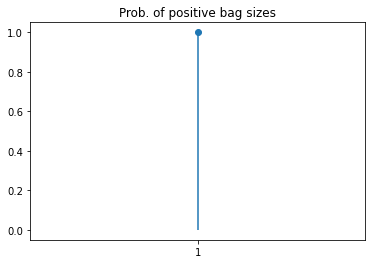

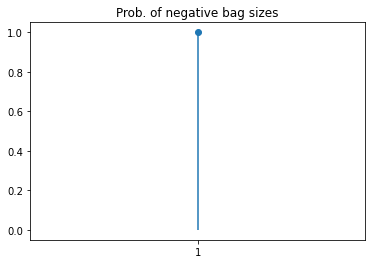

Expected bag sizes:
	Positive bags: 1.000
	Positive bags: 1.000
total: 33600, positives: 5425, negatives: 28175
Empirical Bag sizes:
	 Positive bags: mean size 1.000, median size 1
	 Negative bags: mean size 1.000, median size 1
required -ve exposures: 3687
available -ve exposures: 28175
Assignment matrix size: (4397, 4397) (3517, 4397) (4397, 3)
Train size: 3517(+568/-2949), test size: 880(+142/-738)
Average positive samples per bag: 1.0
----------- Trial 1/1: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.009, 0.008, 0.008, 0.004]
	rssi_th: [21.0, 35.0, 25.0]
	infectiousness: [0.01, 0.01, 0.0]
scoring:
	beta: 0.100000
	rssi_w: [0.009, 0.017, 0.025, 0.029]
	rssi_th: [-99.0, -64.0, -39.0]
	infectiousness: [0.01, 0.02, 0.02]
loss at init: sigmoid 1.0551749467849731 / step 1.0590091943740845
Iter 0: batch loss 0.9771, sigmoid_temp 0.100, elapsed time 1.44
Iter 0, full train loss: step-bins 0.8533, loss sigmoid-bins 0.8499
Iter 500: batch loss

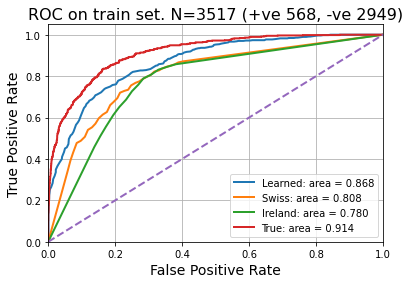

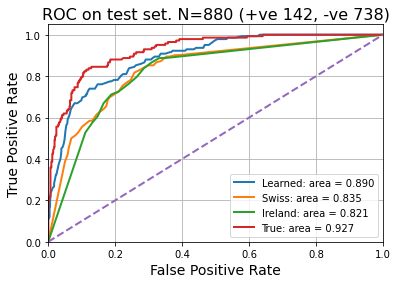

total: 33600, positives: 5484, negatives: 28116


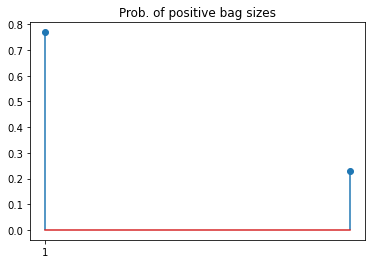

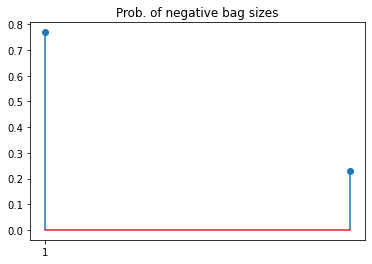

Expected bag sizes:
	Positive bags: 1.231
	Positive bags: 1.231
total: 33600, positives: 5484, negatives: 28116
Empirical Bag sizes:
	 Positive bags: mean size 1.242, median size 1
	 Negative bags: mean size 1.229, median size 1
required -ve exposures: 4276
available -ve exposures: 28116
Assignment matrix size: (4350, 5355) (3480, 5355) (5355, 3)
Train size: 3480(+568/-2912), test size: 870(+142/-728)
Average positive samples per bag: 1.519718309859155
----------- Trial 1/1: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.001, 0.0, 0.008, 0.007]
	rssi_th: [28.0, 14.0, 31.0]
	infectiousness: [0.01, 0.0, 0.01]
scoring:
	beta: 0.100000
	rssi_w: [0.001, 0.001, 0.009, 0.015]
	rssi_th: [-92.0, -78.0, -47.0]
	infectiousness: [0.01, 0.01, 0.01]
loss at init: sigmoid 1.2034181356430054 / step 1.2106013298034668
Iter 0: batch loss 1.2870, sigmoid_temp 0.100, elapsed time 0.77
Iter 0, full train loss: step-bins 0.6746, loss sigmoid-bins 0.6718
Iter 500

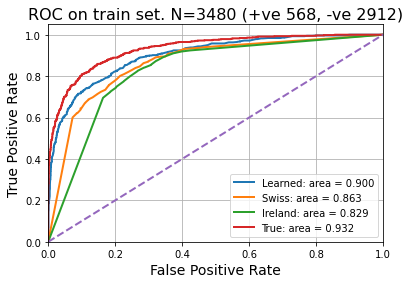

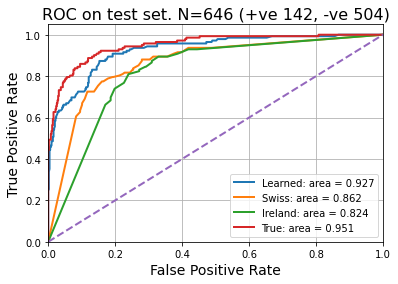

total: 33600, positives: 5433, negatives: 28167


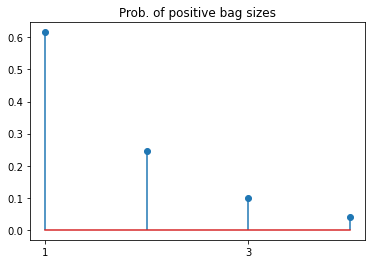

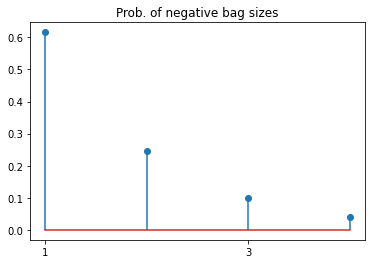

Expected bag sizes:
	Positive bags: 1.562
	Positive bags: 1.562
total: 33600, positives: 5433, negatives: 28167
Empirical Bag sizes:
	 Positive bags: mean size 1.585, median size 1
	 Negative bags: mean size 1.554, median size 1
required -ve exposures: 5415
available -ve exposures: 28167
Assignment matrix size: (4390, 6842) (3512, 6842) (6842, 3)
Train size: 3512(+568/-2944), test size: 878(+142/-736)
Average positive samples per bag: 2.0098591549295777
----------- Trial 1/1: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.003, 0.006, 0.001, 0.005]
	rssi_th: [35.0, 34.0, 10.0]
	infectiousness: [0.0, 0.0, 0.01]
scoring:
	beta: 0.100000
	rssi_w: [0.003, 0.009, 0.01, 0.015]
	rssi_th: [-85.0, -51.0, -41.0]
	infectiousness: [0.0, 0.0, 0.01]
loss at init: sigmoid 1.1513335704803467 / step 1.1773226261138916
Iter 0: batch loss 1.3853, sigmoid_temp 0.100, elapsed time 0.84
Iter 0, full train loss: step-bins 0.6214, loss sigmoid-bins 0.6005
Iter 500:

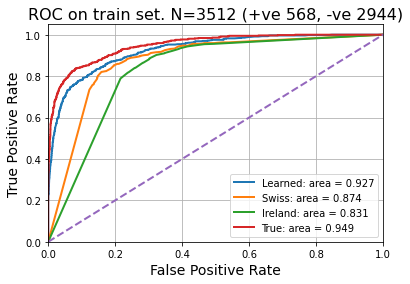

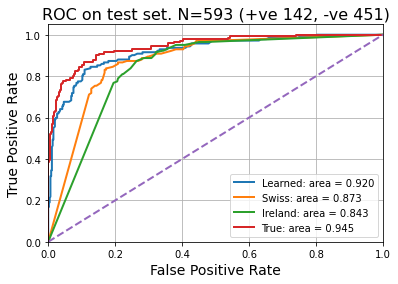

total: 33600, positives: 5376, negatives: 28224


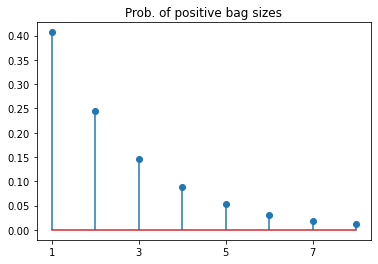

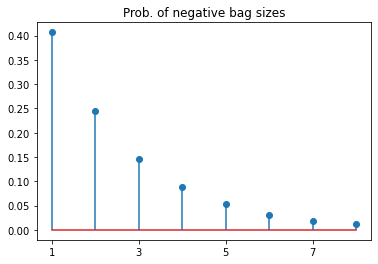

Expected bag sizes:
	Positive bags: 2.363
	Positive bags: 2.363
total: 33600, positives: 5376, negatives: 28224
Empirical Bag sizes:
	 Positive bags: mean size 2.361, median size 2
	 Negative bags: mean size 2.325, median size 2
required -ve exposures: 8953
available -ve exposures: 28224
Assignment matrix size: (4437, 10341) (3549, 10341) (10341, 3)
Train size: 3549(+568/-2981), test size: 888(+142/-746)
Average positive samples per bag: 1.9549295774647888
----------- Trial 1/1: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.008, 0.01, 0.0, 0.006]
	rssi_th: [22.0, 35.0, 27.0]
	infectiousness: [0.0, 0.01, 0.01]
scoring:
	beta: 0.100000
	rssi_w: [0.008, 0.017, 0.017, 0.023]
	rssi_th: [-98.0, -63.0, -36.0]
	infectiousness: [0.0, 0.01, 0.01]
loss at init: sigmoid 1.0323693752288818 / step 1.0438475608825684
Iter 0: batch loss 0.7960, sigmoid_temp 0.100, elapsed time 0.83
Iter 0, full train loss: step-bins 0.7131, loss sigmoid-bins 0.7060
Iter 5

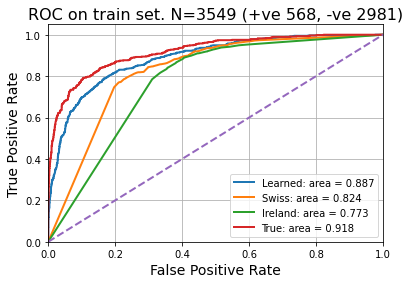

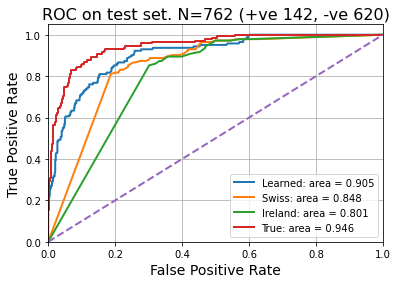

total: 33600, positives: 5351, negatives: 28249


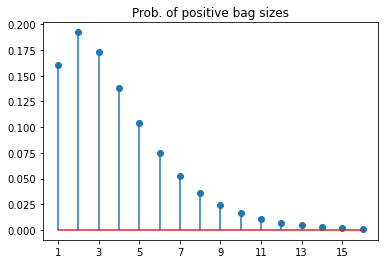

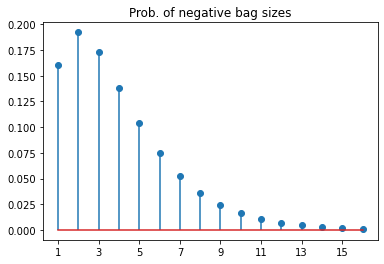

Expected bag sizes:
	Positive bags: 3.969
	Positive bags: 3.969
total: 33600, positives: 5351, negatives: 28249
Empirical Bag sizes:
	 Positive bags: mean size 3.894, median size 3
	 Negative bags: mean size 3.974, median size 3
required -ve exposures: 16230
available -ve exposures: 28249
Assignment matrix size: (4458, 17658) (3566, 17658) (17658, 3)
Train size: 3566(+568/-2998), test size: 892(+142/-750)
Average positive samples per bag: 2.011267605633803
----------- Trial 1/1: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.003, 0.001, 0.004, 0.009]
	rssi_th: [33.0, 26.0, 17.0]
	infectiousness: [0.0, 0.0, 0.01]
scoring:
	beta: 0.100000
	rssi_w: [0.003, 0.004, 0.008, 0.016]
	rssi_th: [-87.0, -61.0, -44.0]
	infectiousness: [0.0, 0.0, 0.01]
loss at init: sigmoid 1.1070629358291626 / step 1.1410430669784546
Iter 0: batch loss 1.1262, sigmoid_temp 0.100, elapsed time 0.97
Iter 0, full train loss: step-bins 0.5670, loss sigmoid-bins 0.5553
Iter 

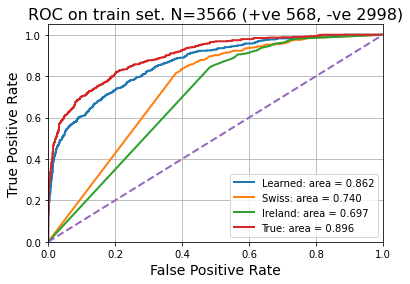

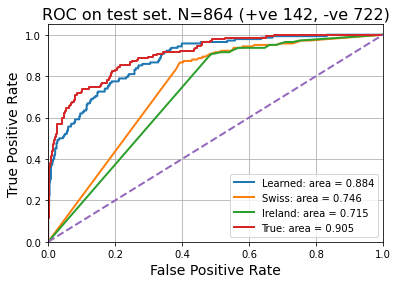

total: 33600, positives: 5357, negatives: 28243


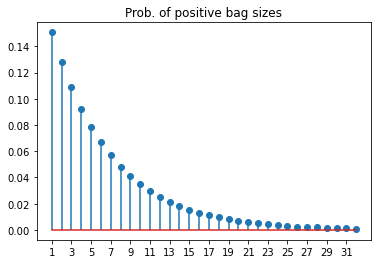

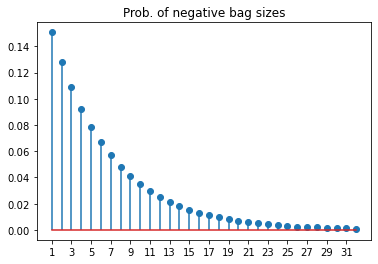

Expected bag sizes:
	Positive bags: 6.489
	Positive bags: 6.489
total: 33600, positives: 5357, negatives: 28243
Empirical Bag sizes:
	 Positive bags: mean size 6.030, median size 4
	 Negative bags: mean size 6.604, median size 5
required -ve exposures: 27569
available -ve exposures: 28243
Assignment matrix size: (4453, 29000) (3562, 29000) (29000, 3)
Train size: 3562(+568/-2994), test size: 891(+142/-749)
Average positive samples per bag: 2.015492957746479
----------- Trial 1/1: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.004, 0.009, 0.001, 0.007]
	rssi_th: [11.0, 39.0, 22.0]
	infectiousness: [0.0, 0.0, 0.0]
scoring:
	beta: 0.100000
	rssi_w: [0.004, 0.012, 0.013, 0.021]
	rssi_th: [-109.0, -70.0, -48.0]
	infectiousness: [0.0, 0.01, 0.01]
loss at init: sigmoid 1.0064165592193604 / step 1.0206702947616577
Iter 0: batch loss 0.9683, sigmoid_temp 0.100, elapsed time 0.96
Iter 0, full train loss: step-bins 0.5780, loss sigmoid-bins 0.5733
Iter

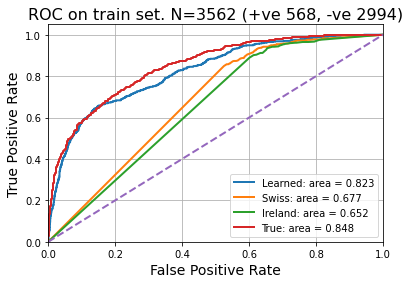

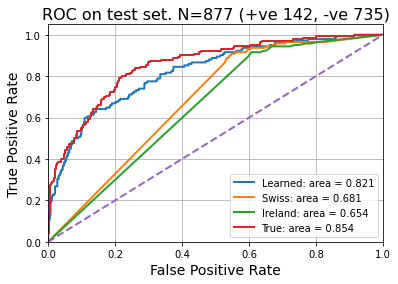

In [ ]:
# train for all bag configurations
auc_train_configs = []
auc_test_configs = []
n_trials = 1
n_random_restarts_train = 10
for bag_config in bag_configs:
  auc_train_trials, auc_test_trials = train_and_eval_with_bag_config(bag_config, pos_neg_ratio, X_epi, probabilities_true_epi, n_trials=n_trials, n_random_restarts=n_random_restarts_train)
  auc_train_configs.append(auc_train_trials)
  auc_test_configs.append(auc_test_trials)


(6, 1, 4) (6, 1, 4)


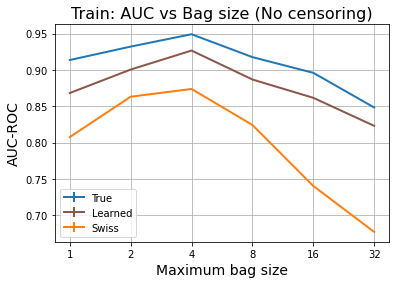

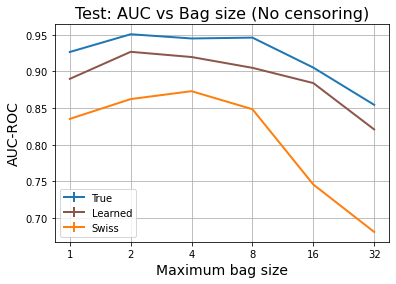

In [ ]:
auc_train_configs = np.array(auc_train_configs) #shape: n_bag_configs X n_trials X n_configs
auc_test_configs = np.array(auc_test_configs)
auc_train_configs_mean = np.mean(auc_train_configs, axis=1)
auc_train_configs_std = np.std(auc_train_configs, axis=1)
auc_test_configs_mean = np.mean(auc_test_configs, axis=1)
auc_test_configs_std = np.std(auc_test_configs, axis=1)
print(auc_train_configs.shape, auc_test_configs.shape)
xs = np.arange(auc_train_configs.shape[0], dtype=int)
xticks = [bc.max_bag_size for bc in bag_configs]
labels = ['True', 'Learned', 'Swiss']
plot_xy([xs,xs,xs], [auc_train_configs_mean[:,-1], auc_train_configs_mean[:,0], auc_train_configs_mean[:,1]], [2]*3, labels, ['-']*3, 
        'Maximum bag size', 'AUC-ROC', 'Train: AUC vs Bag size (No censoring)', 
        yerr=[auc_train_configs_std[:,-1], \
        auc_train_configs_std[:,0], auc_train_configs_std[:,1]], xticks=xticks, legend_loc="best",
        colors=['tab:blue', 'tab:brown', 'tab:orange'])

plot_xy([xs,xs,xs], [auc_test_configs_mean[:,-1], auc_test_configs_mean[:,0], auc_test_configs_mean[:,1]], [2]*3, labels, ['-']*3,  
        'Maximum bag size', 'AUC-ROC', 'Test: AUC vs Bag size (No censoring)',
        yerr=[auc_test_configs_std[:,-1], 
        auc_test_configs_std[:,0], auc_test_configs_std[:,1]], xticks=xticks, legend_loc="best",
        colors=['tab:blue', 'tab:brown', 'tab:orange'])

  


### Train with model mismatch (no censoring)

total: 33600, positives: 3659, negatives: 29941


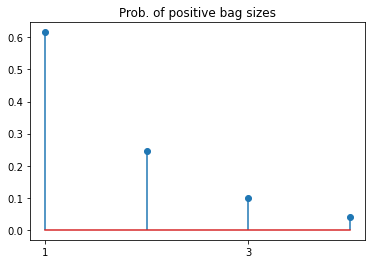

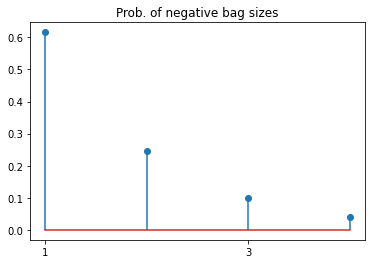

Expected bag sizes:
	Positive bags: 1.562
	Positive bags: 1.562
total: 33600, positives: 3659, negatives: 29941
Empirical Bag sizes:
	 Positive bags: mean size 1.527, median size 1
	 Negative bags: mean size 1.563, median size 1
required -ve exposures: 8742
available -ve exposures: 29941
Assignment matrix size: (6519, 10165) (5215, 10165) (10165, 3)
Train size: 5215(+568/-4647), test size: 1304(+142/-1162)
Average positive samples per bag: 2.0042253521126763
----------- Trial 1/1: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.003, 0.007, 0.0, 0.008]
	rssi_th: [24.0, 26.0, 30.0]
	infectiousness: [0.0, 0.0, 0.01]
scoring:
	beta: 0.100000
	rssi_w: [0.003, 0.01, 0.011, 0.018]
	rssi_th: [-96.0, -70.0, -40.0]
	infectiousness: [0.0, 0.0, 0.01]
loss at init: sigmoid 0.8279559016227722 / step 0.8400762677192688
Iter 0: batch loss 0.9744, sigmoid_temp 0.100, elapsed time 0.87
Iter 0, full train loss: step-bins 0.4585, loss sigmoid-bins 0.4564
Iter 5

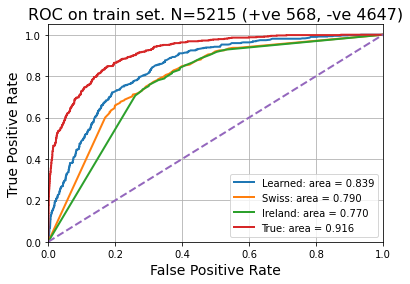

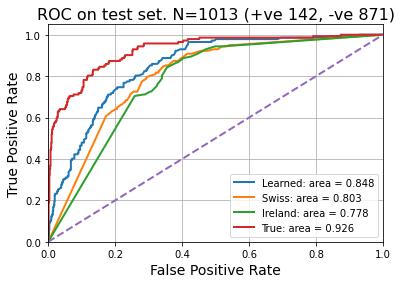

total: 33600, positives: 4407, negatives: 29193


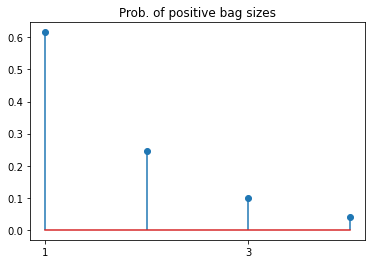

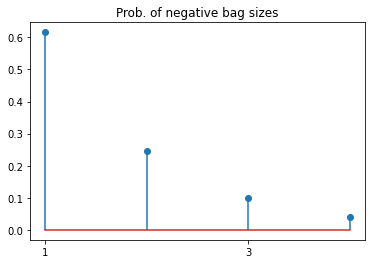

Expected bag sizes:
	Positive bags: 1.562
	Positive bags: 1.562
total: 33600, positives: 4407, negatives: 29193
Empirical Bag sizes:
	 Positive bags: mean size 1.546, median size 1
	 Negative bags: mean size 1.567, median size 1
required -ve exposures: 7025
available -ve exposures: 29193
Assignment matrix size: (5413, 8469) (4330, 8469) (8469, 3)
Train size: 4330(+568/-3762), test size: 1083(+142/-941)
Average positive samples per bag: 2.0338028169014084
----------- Trial 1/1: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.009, 0.002, 0.007, 0.007]
	rssi_th: [33.0, 34.0, 27.0]
	infectiousness: [0.01, 0.0, 0.01]
scoring:
	beta: 0.100000
	rssi_w: [0.009, 0.011, 0.018, 0.025]
	rssi_th: [-87.0, -53.0, -26.0]
	infectiousness: [0.01, 0.01, 0.02]
loss at init: sigmoid 0.8504128456115723 / step 0.867353081703186
Iter 0: batch loss 0.9725, sigmoid_temp 0.100, elapsed time 0.84
Iter 0, full train loss: step-bins 0.6192, loss sigmoid-bins 0.6093
Iter 

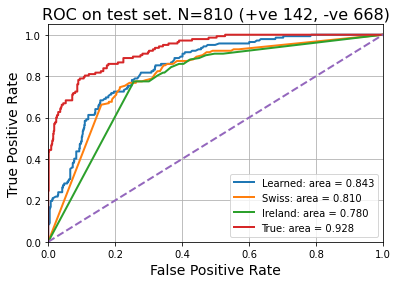

total: 33600, positives: 4794, negatives: 28806


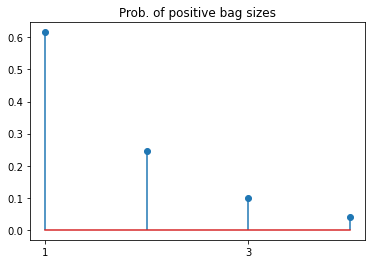

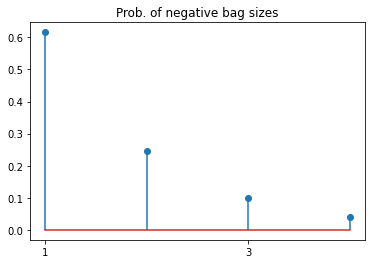

Expected bag sizes:
	Positive bags: 1.562
	Positive bags: 1.562
total: 33600, positives: 4794, negatives: 28806
Empirical Bag sizes:
	 Positive bags: mean size 1.539, median size 1
	 Negative bags: mean size 1.564, median size 1
required -ve exposures: 6342
available -ve exposures: 28806
Assignment matrix size: (4976, 7766) (3980, 7766) (7766, 3)
Train size: 3980(+568/-3412), test size: 996(+142/-854)
Average positive samples per bag: 2.0056338028169014
----------- Trial 1/1: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.01, 0.002, 0.002, 0.008]
	rssi_th: [17.0, 15.0, 36.0]
	infectiousness: [0.01, 0.01, 0.01]
scoring:
	beta: 0.100000
	rssi_w: [0.01, 0.012, 0.014, 0.022]
	rssi_th: [-103.0, -88.0, -52.0]
	infectiousness: [0.01, 0.01, 0.02]
loss at init: sigmoid 0.8805052042007446 / step 0.8884937167167664
Iter 0: batch loss 0.7558, sigmoid_temp 0.100, elapsed time 0.96
Iter 0, full train loss: step-bins 0.6679, loss sigmoid-bins 0.6638
Iter 

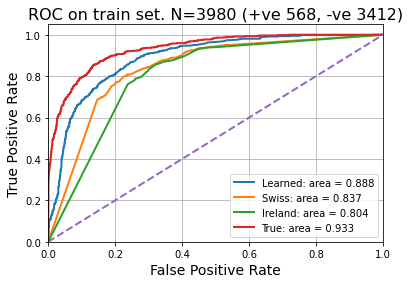

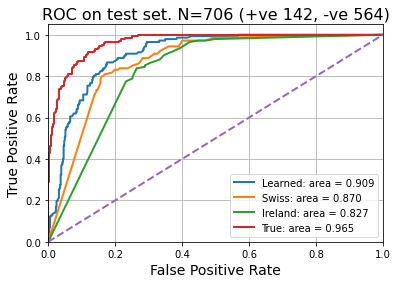

total: 33600, positives: 5112, negatives: 28488


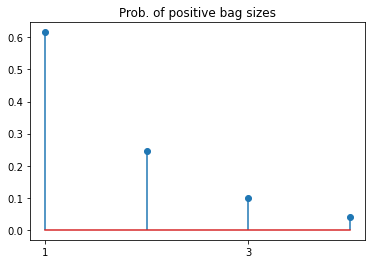

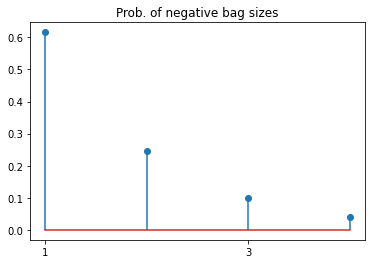

Expected bag sizes:
	Positive bags: 1.562
	Positive bags: 1.562
total: 33600, positives: 5112, negatives: 28488
Empirical Bag sizes:
	 Positive bags: mean size 1.530, median size 1
	 Negative bags: mean size 1.582, median size 1
required -ve exposures: 5919
available -ve exposures: 28488
Assignment matrix size: (4666, 7343) (3732, 7343) (7343, 3)
Train size: 3732(+568/-3164), test size: 934(+142/-792)
Average positive samples per bag: 2.0056338028169014
----------- Trial 1/1: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.002, 0.008, 0.003, 0.003]
	rssi_th: [39.0, 18.0, 11.0]
	infectiousness: [0.01, 0.0, 0.0]
scoring:
	beta: 0.100000
	rssi_w: [0.002, 0.01, 0.013, 0.016]
	rssi_th: [-81.0, -63.0, -52.0]
	infectiousness: [0.01, 0.01, 0.02]
loss at init: sigmoid 0.9836762547492981 / step 0.993749737739563
Iter 0: batch loss 1.0009, sigmoid_temp 0.100, elapsed time 0.78
Iter 0, full train loss: step-bins 0.6639, loss sigmoid-bins 0.6531
Iter 500

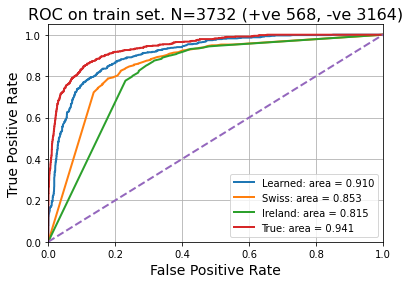

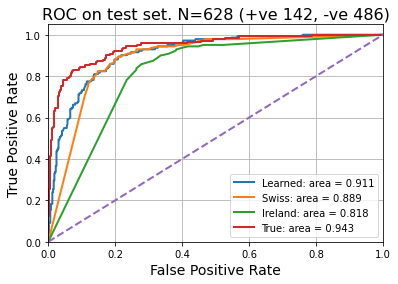

In [ ]:
bag_configs = [
          BagConfig(p_pos=0.4,r_pos=1,p_neg=0.4,r_neg=1,max_bag_size=4,censor_prob_pos=0,censor_prob_neg=0),
]

# train for all bag configurations
auc_train_configs_approx = []
auc_test_configs_approx = []
n_approx = min(probabilities_true_epi_approx.shape[1], 5)
taylor_terms = [2,4,6,8]
n_trials = 1
n_random_restarts_train = 10
for bag_config in bag_configs:
  for i,t in enumerate(taylor_terms):
    auc_train_trials, auc_test_trials = train_and_eval_with_bag_config(bag_config, pos_neg_ratio, X_epi, probabilities_true_epi_approx[:,t-1], n_trials=n_trials, n_random_restarts=n_random_restarts_train)
    auc_train_configs_approx.append(dict(auc_train_trials=auc_train_trials,approx_id=t))
    auc_test_configs_approx.append(dict(auc_test_trials=auc_test_trials,approx_id=t))



(1, 4)
[[0.8393700918660227, 0.8760695820323322, 0.88798983083731, 0.9101375398408148, 0.926613092276485]]


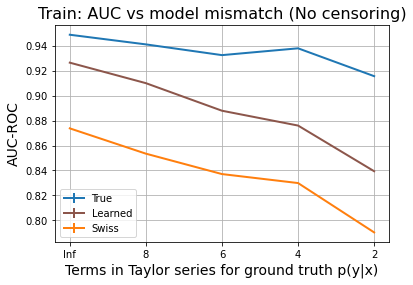

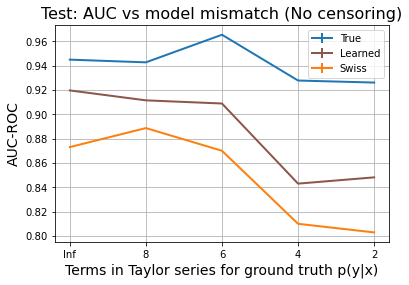

In [ ]:
auc_train_configs_mean = np.mean(auc_train_configs, axis=1)
auc_train_configs_std = np.std(auc_train_configs, axis=1)
auc_test_configs_mean = np.mean(auc_test_configs, axis=1)
auc_test_configs_std = np.std(auc_test_configs, axis=1)
 
taylor_terms = [2,4,6,8]
n_bag_configs = len(bag_configs)
n_approx = len(taylor_terms)
auc_train_mean_approx = np.zeros((n_approx,n_bag_configs,4))
auc_train_std_approx = np.zeros((n_approx,n_bag_configs,4))
auc_test_mean_approx = np.zeros((n_approx,n_bag_configs,4))
auc_test_std_approx = np.zeros((n_approx,n_bag_configs,4))
print(np.array(auc_train_configs_approx[0*n_approx+0]['auc_train_trials']).shape)
for i,bc in enumerate(bag_configs):
  for j,t in enumerate(taylor_terms):
    auc_train_mean_approx[j,i,:] = np.mean(auc_train_configs_approx[i*n_approx+j]['auc_train_trials'], axis=0)
    auc_train_std_approx[j,i,:] = np.std(auc_train_configs_approx[i*n_approx+j]['auc_train_trials'], axis=0)
    auc_test_mean_approx[j,i,:] = np.mean(auc_test_configs_approx[i*n_approx+j]['auc_test_trials'], axis=0)
    auc_test_std_approx[j,i,:] = np.std(auc_test_configs_approx[i*n_approx+j]['auc_test_trials'], axis=0)

def reverse(x):
  y = x.copy()
  return y[::-1]

xticks = ['Inf', 8, 6, 4, 2]
xs = np.arange(len(xticks), dtype=int)
labels = ['True', 'Learned', 'Swiss']
print([list(auc_train_mean_approx[:,0,0])+[auc_train_configs_mean[2,0]]])
auc_train_learned_mean = reverse(list(auc_train_mean_approx[:,0,0])+[auc_train_configs_mean[2,0]])
auc_train_learned_std = reverse(list(auc_train_std_approx[:,0,0]) + [auc_train_configs_std[2,0]])
auc_train_true_mean = reverse(list(auc_train_mean_approx[:,0,-1])+[auc_train_configs_mean[2,-1]])
auc_train_true_std = reverse(list(auc_train_std_approx[:,0,-1]) + [auc_train_configs_std[2,-1]])
auc_train_swiss_mean = reverse(list(auc_train_mean_approx[:,0,1])+[auc_train_configs_mean[2,1]])
auc_train_swiss_std = reverse(list(auc_train_std_approx[:,0,1]) + [auc_train_configs_std[2,1]])

plot_xy([xs,xs,xs], [auc_train_true_mean, auc_train_learned_mean, auc_train_swiss_mean], [2]*3, labels, ['-']*3, 
        'Terms in Taylor series for ground truth p(y|x)', 'AUC-ROC', 'Train: AUC vs model mismatch (No censoring)', 
        yerr=[auc_train_true_std, auc_train_learned_std, auc_train_swiss_std], xticks=xticks, legend_loc="best",
        colors=['tab:blue', 'tab:brown', 'tab:orange'])

auc_test_learned_mean = reverse(list(auc_test_mean_approx[:,0,0])+[auc_test_configs_mean[2,0]])
auc_test_learned_std = reverse(list(auc_test_std_approx[:,0,0]) + [auc_test_configs_std[2,0]])
auc_test_true_mean = reverse(list(auc_test_mean_approx[:,0,-1])+[auc_test_configs_mean[2,-1]])
auc_test_true_std = reverse(list(auc_test_std_approx[:,0,-1]) + [auc_test_configs_std[2,-1]])
auc_test_swiss_mean = reverse(list(auc_test_mean_approx[:,0,1])+[auc_test_configs_mean[2,1]])
auc_test_swiss_std = reverse(list(auc_test_std_approx[:,0,1]) + [auc_test_configs_std[2,1]])

plot_xy([xs,xs,xs], [auc_test_true_mean, auc_test_learned_mean, auc_test_swiss_mean], [2]*3, labels, ['-']*3, 
        'Terms in Taylor series for ground truth p(y|x)', 'AUC-ROC', 'Test: AUC vs model mismatch (No censoring)', 
        yerr=[auc_test_true_std, auc_test_learned_std, auc_test_swiss_std], xticks=xticks, legend_loc="best",
        colors=['tab:blue', 'tab:brown', 'tab:orange'])





### Train with matched model (exposure censoring)

=========== Config 1 of 9: censoring prob +ve 0.05, censoring prob -ve 0 =================
total: 33600, positives: 5395, negatives: 28205


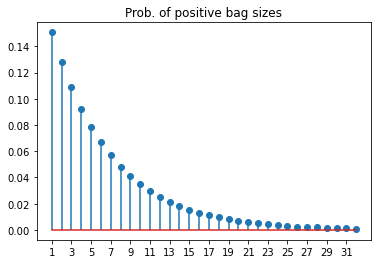

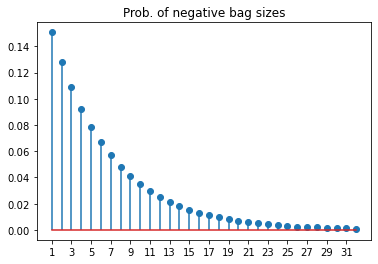

Expected bag sizes:
	Positive bags: 6.489
	Positive bags: 6.489
total: 33600, positives: 5395, negatives: 28205
Empirical Bag sizes:
	 Positive bags: mean size 6.641, median size 5
	 Negative bags: mean size 6.494, median size 5
required -ve exposures: 27445
available -ve exposures: 28205
Assignment matrix size: (4421, 28816) (3525, 28816) (28816, 3)
Train size: 3536(+568/-2968), test size: 885(+142/-743)
Average positive samples per bag: 1.9309859154929578
----------- Trial 1/1: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.006, 0.004, 0.004, 0.005]
	rssi_th: [27.0, 11.0, 30.0]
	infectiousness: [0.0, 0.01, 0.01]
scoring:
	beta: 0.100000
	rssi_w: [0.006, 0.009, 0.013, 0.018]
	rssi_th: [-93.0, -82.0, -52.0]
	infectiousness: [0.0, 0.01, 0.02]
loss at init: sigmoid 0.9392881393432617 / step 0.9450891613960266
Iter 0: batch loss 0.9191, sigmoid_temp 0.100, elapsed time 0.96
Iter 0, full train loss: step-bins 0.5983, loss sigmoid-bins 0.5956
It

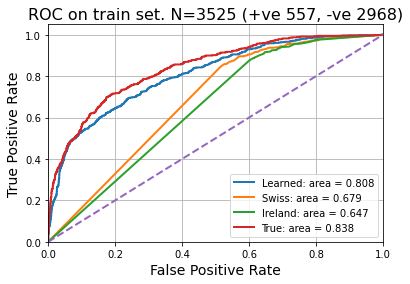

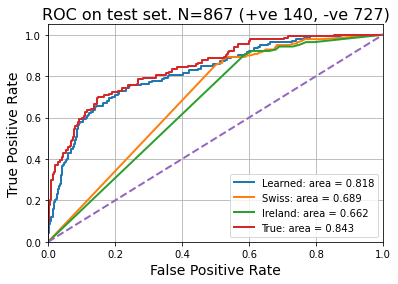

=========== Config 2 of 9: censoring prob +ve 0.1, censoring prob -ve 0 =================
total: 33600, positives: 5404, negatives: 28196


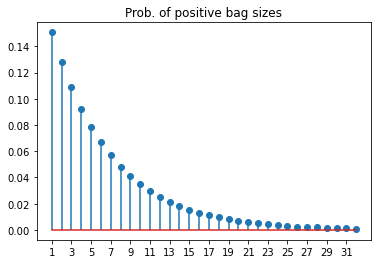

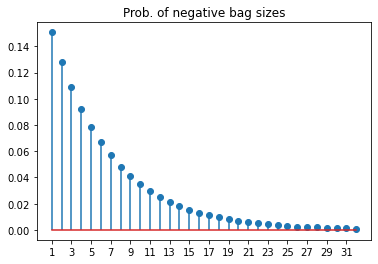

Expected bag sizes:
	Positive bags: 6.489
	Positive bags: 6.489
total: 33600, positives: 5404, negatives: 28196
Empirical Bag sizes:
	 Positive bags: mean size 6.427, median size 4
	 Negative bags: mean size 6.640, median size 5
required -ve exposures: 27752
available -ve exposures: 28196
Assignment matrix size: (4414, 29159) (3518, 29159) (29159, 3)
Train size: 3531(+568/-2963), test size: 883(+142/-741)
Average positive samples per bag: 1.9816901408450704
----------- Trial 1/1: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.002, 0.006, 0.009, 0.003]
	rssi_th: [23.0, 26.0, 29.0]
	infectiousness: [0.0, 0.01, 0.01]
scoring:
	beta: 0.100000
	rssi_w: [0.002, 0.008, 0.017, 0.02]
	rssi_th: [-97.0, -71.0, -42.0]
	infectiousness: [0.0, 0.01, 0.02]
loss at init: sigmoid 0.9305472373962402 / step 0.9201403856277466
Iter 0: batch loss 1.4082, sigmoid_temp 0.100, elapsed time 0.75
Iter 0, full train loss: step-bins 0.5287, loss sigmoid-bins 0.5312
Ite

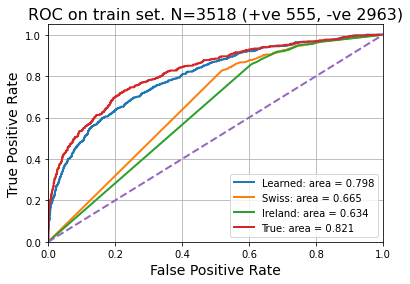

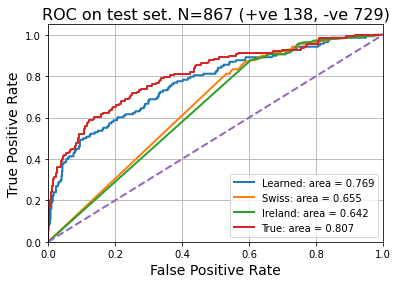

=========== Config 3 of 9: censoring prob +ve 0.2, censoring prob -ve 0 =================
total: 33600, positives: 5322, negatives: 28278


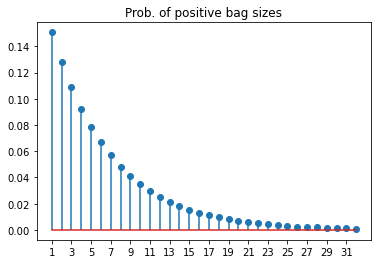

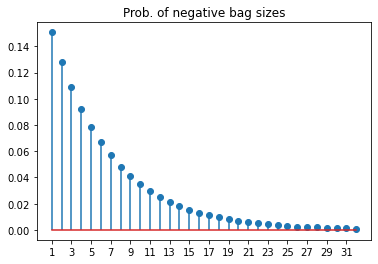

Expected bag sizes:
	Positive bags: 6.489
	Positive bags: 6.489
total: 33600, positives: 5322, negatives: 28278
Empirical Bag sizes:
	 Positive bags: mean size 6.499, median size 5
	 Negative bags: mean size 6.628, median size 5
required -ve exposures: 28210
available -ve exposures: 28278
Assignment matrix size: (4482, 29613) (3562, 29613) (29613, 3)
Train size: 3585(+568/-3017), test size: 897(+142/-755)
Average positive samples per bag: 1.976056338028169
----------- Trial 1/1: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.0, 0.0, 0.006, 0.002]
	rssi_th: [14.0, 19.0, 18.0]
	infectiousness: [0.01, 0.0, 0.01]
scoring:
	beta: 0.100000
	rssi_w: [0.0, 0.001, 0.006, 0.009]
	rssi_th: [-106.0, -87.0, -69.0]
	infectiousness: [0.01, 0.01, 0.02]
loss at init: sigmoid 0.9947924017906189 / step 0.9847522377967834
Iter 0: batch loss 1.2483, sigmoid_temp 0.100, elapsed time 0.71
Iter 0, full train loss: step-bins 0.4851, loss sigmoid-bins 0.4866
Iter 50

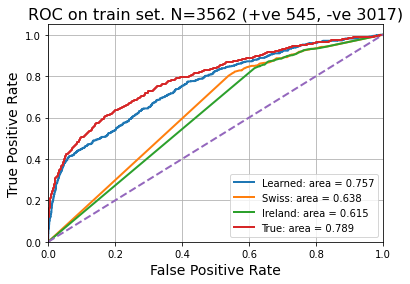

=========== Config 4 of 9: censoring prob +ve 0.3, censoring prob -ve 0 =================
total: 33600, positives: 5367, negatives: 28233


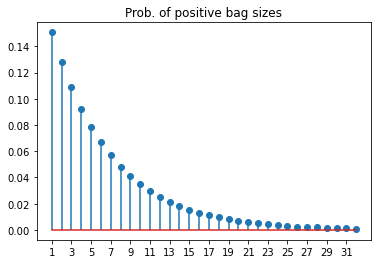

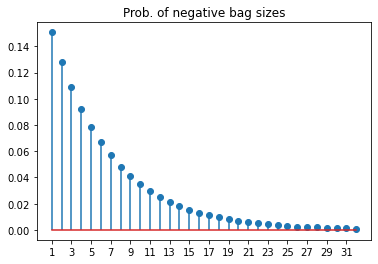

Expected bag sizes:
	Positive bags: 6.489
	Positive bags: 6.489
total: 33600, positives: 5367, negatives: 28233
Empirical Bag sizes:
	 Positive bags: mean size 6.397, median size 5
	 Negative bags: mean size 6.443, median size 5
required -ve exposures: 27198
available -ve exposures: 28233
Assignment matrix size: (4444, 28599) (3511, 28599) (28599, 3)
Train size: 3555(+568/-2987), test size: 889(+142/-747)
Average positive samples per bag: 1.9732394366197183
----------- Trial 1/1: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.0, 0.009, 0.002, 0.009]
	rssi_th: [23.0, 26.0, 38.0]
	infectiousness: [0.0, 0.0, 0.01]
scoring:
	beta: 0.100000
	rssi_w: [0.0, 0.009, 0.012, 0.021]
	rssi_th: [-97.0, -71.0, -33.0]
	infectiousness: [0.0, 0.0, 0.01]
loss at init: sigmoid 1.0498759746551514 / step 1.0546855926513672
Iter 0: batch loss 0.9792, sigmoid_temp 0.100, elapsed time 0.76
Iter 0, full train loss: step-bins 0.5129, loss sigmoid-bins 0.5146
Iter 500

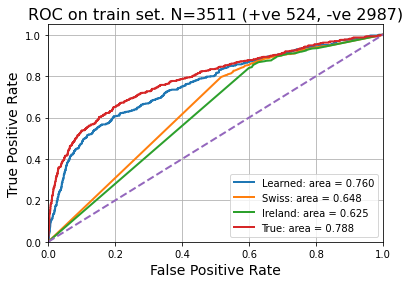

=========== Config 5 of 9: censoring prob +ve 0.4, censoring prob -ve 0 =================
total: 33600, positives: 5382, negatives: 28218


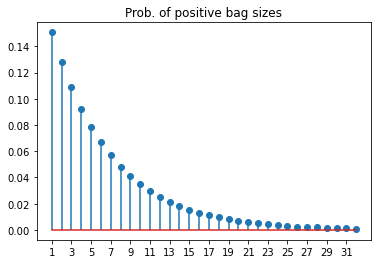

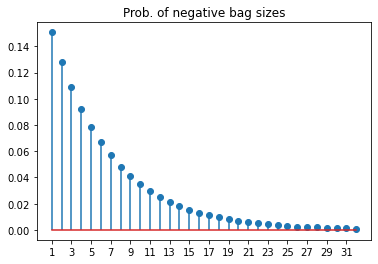

Expected bag sizes:
	Positive bags: 6.489
	Positive bags: 6.489
total: 33600, positives: 5382, negatives: 28218
Empirical Bag sizes:
	 Positive bags: mean size 5.934, median size 4
	 Negative bags: mean size 6.426, median size 5
required -ve exposures: 26745
available -ve exposures: 28218
Assignment matrix size: (4432, 28132) (3481, 28132) (28132, 3)
Train size: 3545(+568/-2977), test size: 887(+142/-745)
Average positive samples per bag: 1.9535211267605634
----------- Trial 1/1: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.007, 0.004, 0.006, 0.007]
	rssi_th: [28.0, 33.0, 36.0]
	infectiousness: [0.0, 0.01, 0.01]
scoring:
	beta: 0.100000
	rssi_w: [0.007, 0.011, 0.017, 0.023]
	rssi_th: [-92.0, -59.0, -23.0]
	infectiousness: [0.0, 0.01, 0.02]
loss at init: sigmoid 0.9359496235847473 / step 0.9441788792610168
Iter 0: batch loss 0.8423, sigmoid_temp 0.100, elapsed time 0.99
Iter 0, full train loss: step-bins 0.6222, loss sigmoid-bins 0.6185
It

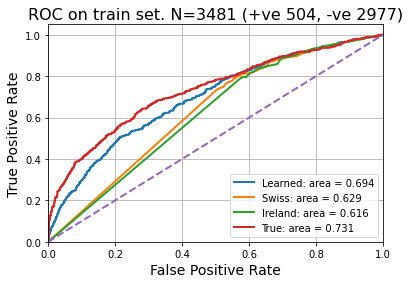

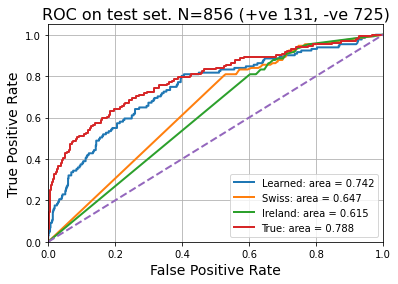

=========== Config 6 of 9: censoring prob +ve 0.5, censoring prob -ve 0 =================
total: 33600, positives: 5418, negatives: 28182


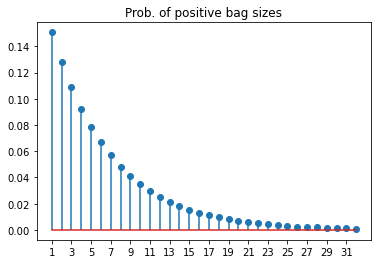

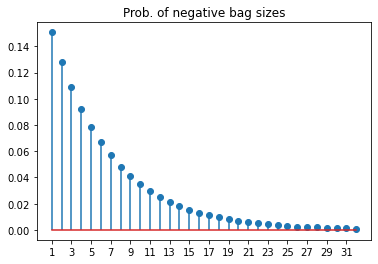

Expected bag sizes:
	Positive bags: 6.489
	Positive bags: 6.489
total: 33600, positives: 5418, negatives: 28182
Empirical Bag sizes:
	 Positive bags: mean size 6.032, median size 4
	 Negative bags: mean size 6.627, median size 5
required -ve exposures: 27362
available -ve exposures: 28182
Assignment matrix size: (4403, 28755) (3430, 28755) (28755, 3)
Train size: 3522(+568/-2954), test size: 881(+142/-739)
Average positive samples per bag: 1.9619718309859155
----------- Trial 1/1: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.0, 0.007, 0.007, 0.003]
	rssi_th: [10.0, 39.0, 15.0]
	infectiousness: [0.0, 0.0, 0.01]
scoring:
	beta: 0.100000
	rssi_w: [0.0, 0.008, 0.015, 0.018]
	rssi_th: [-110.0, -71.0, -56.0]
	infectiousness: [0.0, 0.01, 0.01]
loss at init: sigmoid 0.9103389978408813 / step 0.9068136811256409
Iter 0: batch loss 1.0314, sigmoid_temp 0.100, elapsed time 0.80
Iter 0, full train loss: step-bins 0.5250, loss sigmoid-bins 0.5241
Iter 5

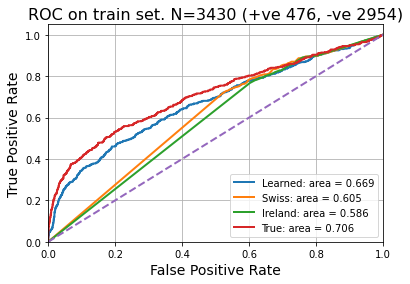

=========== Config 7 of 9: censoring prob +ve 0.6, censoring prob -ve 0 =================
total: 33600, positives: 5394, negatives: 28206


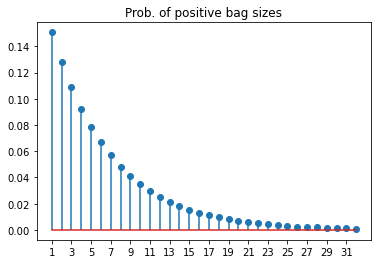

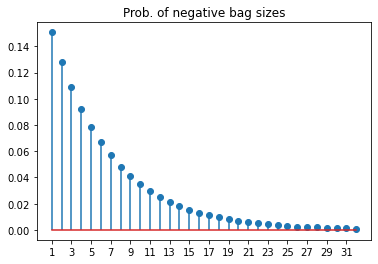

Expected bag sizes:
	Positive bags: 6.489
	Positive bags: 6.489
total: 33600, positives: 5394, negatives: 28206
Empirical Bag sizes:
	 Positive bags: mean size 6.239, median size 5
	 Negative bags: mean size 6.491, median size 5
required -ve exposures: 27103
available -ve exposures: 28206
Assignment matrix size: (4422, 28525) (3447, 28525) (28525, 3)
Train size: 3537(+568/-2969), test size: 885(+142/-743)
Average positive samples per bag: 2.0028169014084507
----------- Trial 1/1: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.004, 0.006, 0.008, 0.001]
	rssi_th: [26.0, 20.0, 33.0]
	infectiousness: [0.01, 0.01, 0.01]
scoring:
	beta: 0.100000
	rssi_w: [0.004, 0.01, 0.018, 0.02]
	rssi_th: [-94.0, -74.0, -41.0]
	infectiousness: [0.01, 0.02, 0.02]
loss at init: sigmoid 0.7829436659812927 / step 0.7750211954116821
Iter 0: batch loss 0.7599, sigmoid_temp 0.100, elapsed time 0.79
Iter 0, full train loss: step-bins 0.5921, loss sigmoid-bins 0.5965
It

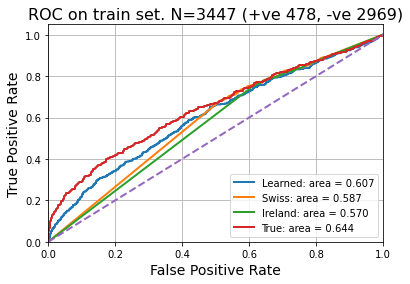

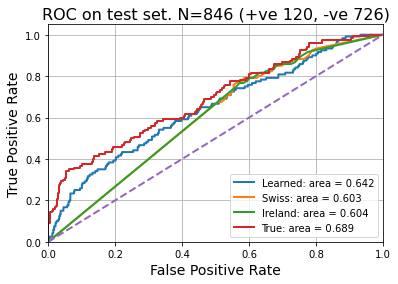

=========== Config 8 of 9: censoring prob +ve 0.7, censoring prob -ve 0 =================
total: 33600, positives: 5422, negatives: 28178


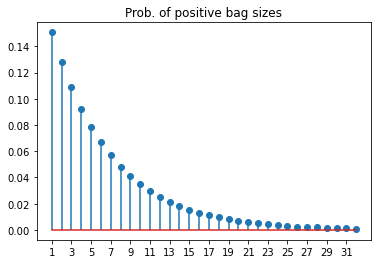

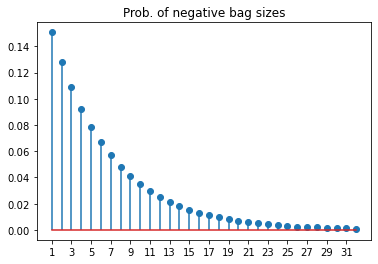

Expected bag sizes:
	Positive bags: 6.489
	Positive bags: 6.489
total: 33600, positives: 5422, negatives: 28178
Empirical Bag sizes:
	 Positive bags: mean size 6.727, median size 5
	 Negative bags: mean size 6.506, median size 5
required -ve exposures: 27348
available -ve exposures: 28178
Assignment matrix size: (4399, 28778) (3409, 28778) (28778, 3)
Train size: 3519(+568/-2951), test size: 880(+142/-738)
Average positive samples per bag: 2.0140845070422535
----------- Trial 1/1: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.006, 0.005, 0.006, 0.007]
	rssi_th: [37.0, 20.0, 12.0]
	infectiousness: [0.01, 0.0, 0.0]
scoring:
	beta: 0.100000
	rssi_w: [0.006, 0.011, 0.017, 0.024]
	rssi_th: [-83.0, -63.0, -51.0]
	infectiousness: [0.01, 0.01, 0.02]
loss at init: sigmoid 0.7884470820426941 / step 0.8112727403640747
Iter 0: batch loss 0.8699, sigmoid_temp 0.100, elapsed time 0.99
Iter 0, full train loss: step-bins 0.5637, loss sigmoid-bins 0.5478
It

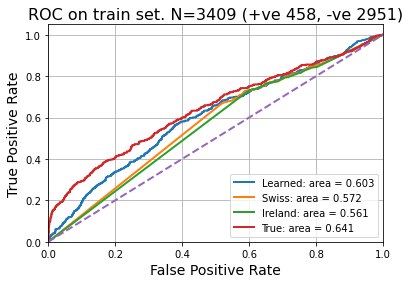

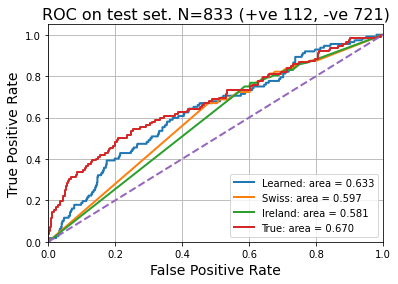

=========== Config 9 of 9: censoring prob +ve 0.8, censoring prob -ve 0 =================
total: 33600, positives: 5301, negatives: 28299


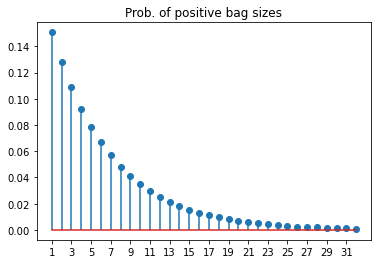

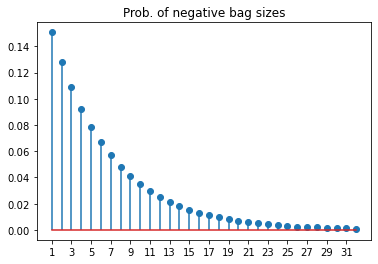

Expected bag sizes:
	Positive bags: 6.489
	Positive bags: 6.489
total: 33600, positives: 5301, negatives: 28299
Empirical Bag sizes:
	 Positive bags: mean size 6.725, median size 5
	 Negative bags: mean size 6.447, median size 5
required -ve exposures: 27756
available -ve exposures: 28299
Assignment matrix size: (4500, 29208) (3462, 29208) (29208, 3)
Train size: 3600(+568/-3032), test size: 900(+142/-758)
Average positive samples per bag: 2.045070422535211
----------- Trial 1/1: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.006, 0.003, 0.003, 0.002]
	rssi_th: [15.0, 23.0, 24.0]
	infectiousness: [0.01, 0.0, 0.01]
scoring:
	beta: 0.100000
	rssi_w: [0.006, 0.009, 0.011, 0.013]
	rssi_th: [-105.0, -82.0, -58.0]
	infectiousness: [0.01, 0.01, 0.02]
loss at init: sigmoid 0.7747400999069214 / step 0.7790549397468567
Iter 0: batch loss 0.7265, sigmoid_temp 0.100, elapsed time 0.97
Iter 0, full train loss: step-bins 0.5200, loss sigmoid-bins 0.5174
I

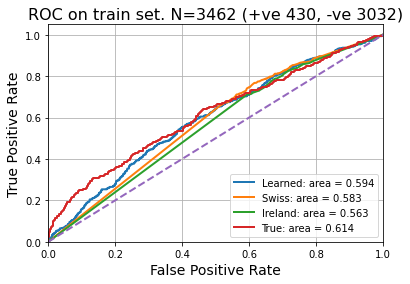

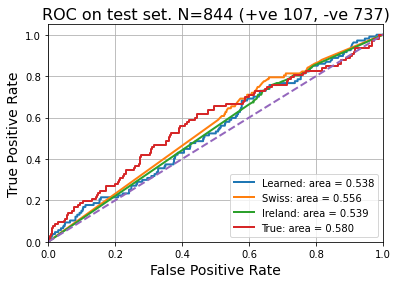

In [ ]:
censor_bag_configs = [
          BagConfig(p_pos=0.85,r_pos=1,p_neg=0.85,r_neg=1,max_bag_size=32,censor_prob_pos=0.05,censor_prob_neg=0),
          BagConfig(p_pos=0.85,r_pos=1,p_neg=0.85,r_neg=1,max_bag_size=32,censor_prob_pos=0.1,censor_prob_neg=0),
          BagConfig(p_pos=0.85,r_pos=1,p_neg=0.85,r_neg=1,max_bag_size=32,censor_prob_pos=0.2,censor_prob_neg=0),
          BagConfig(p_pos=0.85,r_pos=1,p_neg=0.85,r_neg=1,max_bag_size=32,censor_prob_pos=0.3,censor_prob_neg=0),
          BagConfig(p_pos=0.85,r_pos=1,p_neg=0.85,r_neg=1,max_bag_size=32,censor_prob_pos=0.4,censor_prob_neg=0),
          BagConfig(p_pos=0.85,r_pos=1,p_neg=0.85,r_neg=1,max_bag_size=32,censor_prob_pos=0.5,censor_prob_neg=0),
          BagConfig(p_pos=0.85,r_pos=1,p_neg=0.85,r_neg=1,max_bag_size=32,censor_prob_pos=0.6,censor_prob_neg=0),
          BagConfig(p_pos=0.85,r_pos=1,p_neg=0.85,r_neg=1,max_bag_size=32,censor_prob_pos=0.7,censor_prob_neg=0),
          BagConfig(p_pos=0.85,r_pos=1,p_neg=0.85,r_neg=1,max_bag_size=32,censor_prob_pos=0.8,censor_prob_neg=0),
]

# train for all bag configurations
auc_train_configs_censor = []
auc_test_configs_censor = []
for i,bag_config in enumerate(censor_bag_configs):
  print('=========== Config {} of {}: censoring prob +ve {}, censoring prob -ve {} ================='.\
        format(i+1, len(censor_bag_configs), bag_config.censor_prob_pos, bag_config.censor_prob_neg))
  auc_train_trials, auc_test_trials = train_and_eval_with_bag_config(bag_config, pos_neg_ratio, X_epi, probabilities_true_epi, n_trials=n_trials,n_random_restarts=n_random_restarts_train)
  auc_train_configs_censor.append(auc_train_trials)
  auc_test_configs_censor.append(auc_test_trials)



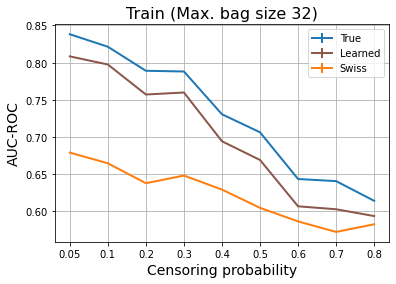

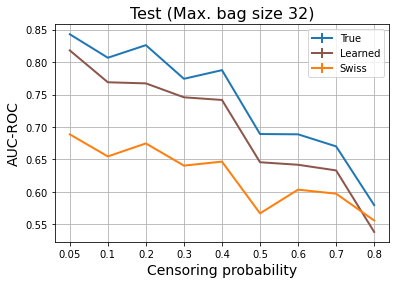

In [ ]:
auc_train_configs_censor = np.array(auc_train_configs_censor) #shape: n_bag_configs X n_trials X n_configs
auc_test_configs_censor = np.array(auc_test_configs_censor)
auc_train_configs_censor_mean = np.mean(auc_train_configs_censor, axis=1)
auc_train_configs_censor_std = np.std(auc_train_configs_censor, axis=1)
auc_test_configs_censor_mean = np.mean(auc_test_configs_censor, axis=1)
auc_test_configs_censor_std = np.std(auc_test_configs_censor, axis=1)
xs = np.arange(auc_train_configs_censor.shape[0], dtype=int)
xticks = [bc.censor_prob_pos for bc in censor_bag_configs]
max_bag_size = censor_bag_configs[0].max_bag_size
labels = ['True', 'Learned', 'Swiss']
plot_xy([xs,xs,xs], [auc_train_configs_censor_mean[:,-1], auc_train_configs_censor_mean[:,0], auc_train_configs_censor_mean[:,1]], [2]*3, labels, ['-']*3, \
        'Censoring probability', 'AUC-ROC', 'Train (Max. bag size {})'.format(max_bag_size), 
        yerr=[auc_train_configs_censor_std[:,-1], 
        auc_train_configs_censor_std[:,0], auc_train_configs_censor_std[:,1]], 
        xticks=xticks, legend_loc="best", colors=['tab:blue', 'tab:brown', 'tab:orange'])
plot_xy([xs,xs,xs], [auc_test_configs_censor_mean[:,-1], auc_test_configs_censor_mean[:,0], auc_test_configs_censor_mean[:,1]], [2]*3, labels, ['-']*3, \
        'Censoring probability', 'AUC-ROC', 'Test (Max. bag size {})'.format(max_bag_size), 
        yerr=[auc_test_configs_censor_std[:,-1], 
        auc_test_configs_censor_std[:,0], auc_test_configs_censor_std[:,1]], 
        xticks=xticks, legend_loc="best", colors=['tab:blue', 'tab:brown', 'tab:orange'])



=========== Config 1 of 8: censoring prob +ve 0.05, censoring prob -ve 0 =================
total: 33600, positives: 5459, negatives: 28141


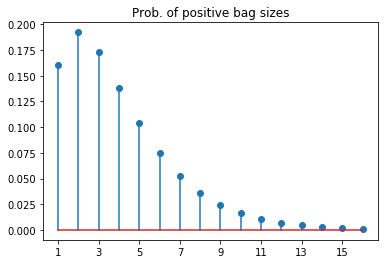

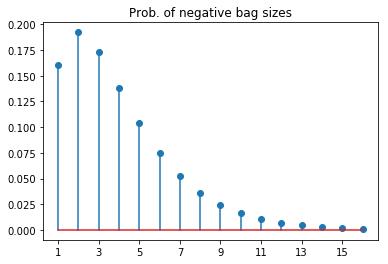

Expected bag sizes:
	Positive bags: 3.969
	Positive bags: 3.969
total: 33600, positives: 5459, negatives: 28141
Empirical Bag sizes:
	 Positive bags: mean size 3.982, median size 3
	 Negative bags: mean size 3.986, median size 3
required -ve exposures: 16000
available -ve exposures: 28141
Assignment matrix size: (4370, 17414) (3489, 17414) (17414, 3)
Train size: 3496(+568/-2928), test size: 874(+142/-732)
Average positive samples per bag: 1.991549295774648
----------- Trial 1/5: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.006, 0.003, 0.002, 0.007]
	rssi_th: [23.0, 37.0, 24.0]
	infectiousness: [0.01, 0.01, 0.01]
scoring:
	beta: 0.100000
	rssi_w: [0.006, 0.008, 0.01, 0.017]
	rssi_th: [-97.0, -60.0, -36.0]
	infectiousness: [0.01, 0.01, 0.02]
loss at init: sigmoid 0.9934410452842712 / step 1.0136324167251587
Iter 0: batch loss 1.3260, sigmoid_temp 0.100, elapsed time 0.79
Iter 0, full train loss: step-bins 0.5803, loss sigmoid-bins 0.5730
It

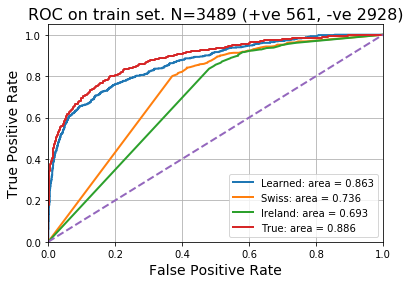

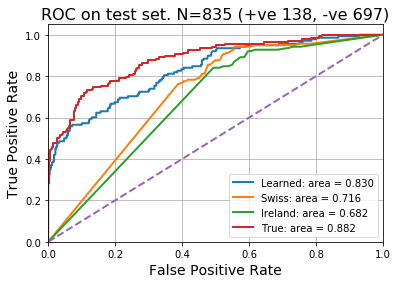

total: 33600, positives: 5440, negatives: 28160


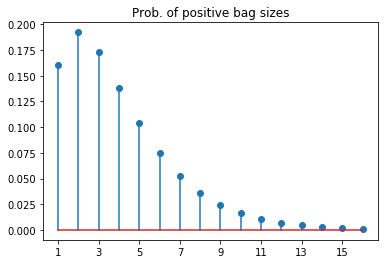

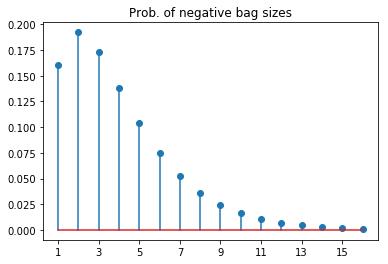

Expected bag sizes:
	Positive bags: 3.969
	Positive bags: 3.969
total: 33600, positives: 5440, negatives: 28160
Empirical Bag sizes:
	 Positive bags: mean size 3.983, median size 3
	 Negative bags: mean size 3.999, median size 3
required -ve exposures: 16138
available -ve exposures: 28160
Assignment matrix size: (4385, 17524) (3494, 17524) (17524, 3)
Train size: 3508(+568/-2940), test size: 877(+142/-735)
Average positive samples per bag: 1.952112676056338
----------- Trial 2/5: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.009, 0.008, 0.008, 0.004]
	rssi_th: [37.0, 11.0, 21.0]
	infectiousness: [0.01, 0.01, 0.0]
scoring:
	beta: 0.100000
	rssi_w: [0.009, 0.017, 0.025, 0.029]
	rssi_th: [-83.0, -72.0, -51.0]
	infectiousness: [0.01, 0.02, 0.02]
loss at init: sigmoid 0.8177058696746826 / step 0.8205817937850952
Iter 0: batch loss 0.9888, sigmoid_temp 0.100, elapsed time 1.13
Iter 0, full train loss: step-bins 0.6222, loss sigmoid-bins 0.6195
It

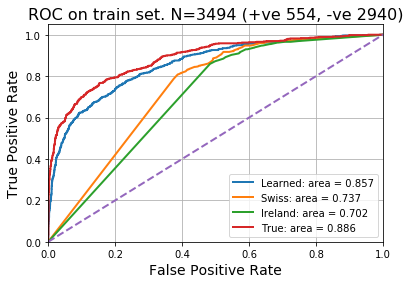

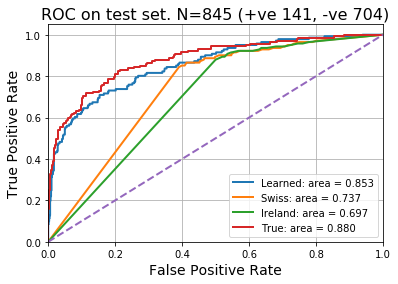

total: 33600, positives: 5353, negatives: 28247


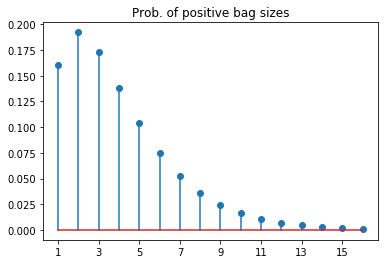

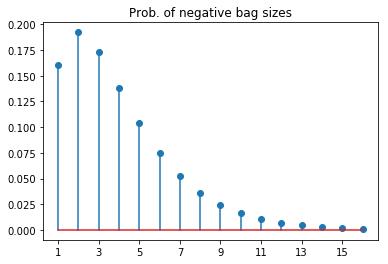

Expected bag sizes:
	Positive bags: 3.969
	Positive bags: 3.969
total: 33600, positives: 5353, negatives: 28247
Empirical Bag sizes:
	 Positive bags: mean size 3.894, median size 3
	 Negative bags: mean size 3.922, median size 3
required -ve exposures: 15988
available -ve exposures: 28247
Assignment matrix size: (4456, 17457) (3549, 17457) (17457, 3)
Train size: 3564(+568/-2996), test size: 892(+142/-750)
Average positive samples per bag: 2.0690140845070424
----------- Trial 3/5: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.001, 0.001, 0.004, 0.002]
	rssi_th: [19.0, 35.0, 28.0]
	infectiousness: [0.0, 0.0, 0.0]
scoring:
	beta: 0.100000
	rssi_w: [0.001, 0.002, 0.007, 0.008]
	rssi_th: [-101.0, -66.0, -38.0]
	infectiousness: [0.0, 0.01, 0.01]
loss at init: sigmoid 1.1899516582489014 / step 1.1896817684173584
Iter 0: batch loss 1.3287, sigmoid_temp 0.100, elapsed time 0.82
Iter 0, full train loss: step-bins 0.4831, loss sigmoid-bins 0.4826
Ite

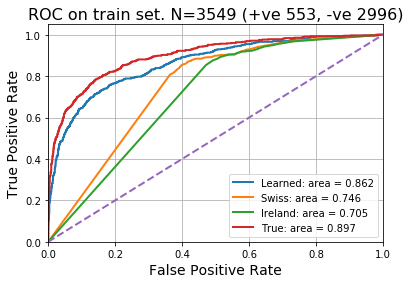

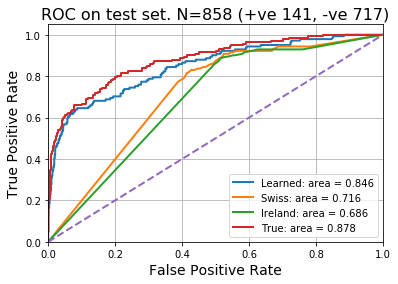

total: 33600, positives: 5444, negatives: 28156


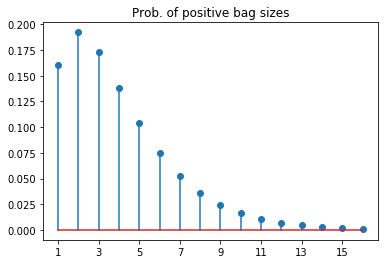

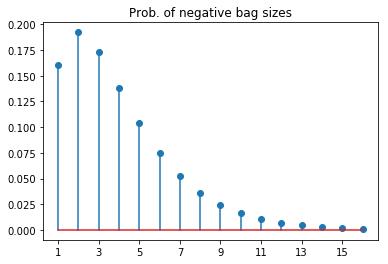

Expected bag sizes:
	Positive bags: 3.969
	Positive bags: 3.969
total: 33600, positives: 5444, negatives: 28156
Empirical Bag sizes:
	 Positive bags: mean size 4.083, median size 3
	 Negative bags: mean size 3.969, median size 3
required -ve exposures: 16065
available -ve exposures: 28156
Assignment matrix size: (4382, 17474) (3495, 17474) (17474, 3)
Train size: 3505(+568/-2937), test size: 877(+142/-735)
Average positive samples per bag: 1.9845070422535211
----------- Trial 4/5: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.005, 0.002, 0.009, 0.005]
	rssi_th: [29.0, 33.0, 16.0]
	infectiousness: [0.01, 0.01, 0.01]
scoring:
	beta: 0.100000
	rssi_w: [0.005, 0.007, 0.016, 0.021]
	rssi_th: [-91.0, -58.0, -42.0]
	infectiousness: [0.01, 0.01, 0.02]
loss at init: sigmoid 0.9299658536911011 / step 0.9575623273849487
Iter 0: batch loss 1.0053, sigmoid_temp 0.100, elapsed time 1.01
Iter 0, full train loss: step-bins 0.6467, loss sigmoid-bins 0.6308


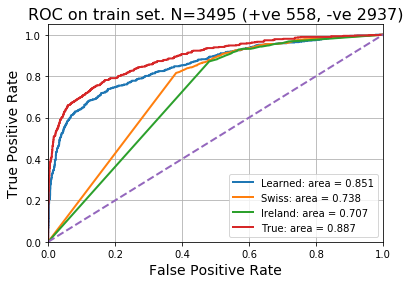

total: 33600, positives: 5438, negatives: 28162


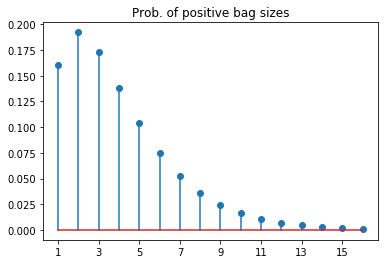

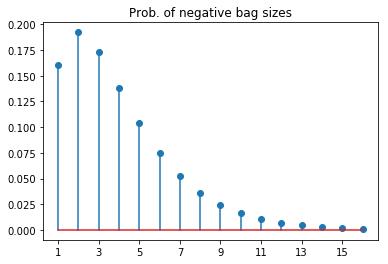

Expected bag sizes:
	Positive bags: 3.969
	Positive bags: 3.969
total: 33600, positives: 5438, negatives: 28162
Empirical Bag sizes:
	 Positive bags: mean size 4.030, median size 3
	 Negative bags: mean size 4.018, median size 3
required -ve exposures: 16173
available -ve exposures: 28162
Assignment matrix size: (4386, 17633) (3501, 17633) (17633, 3)
Train size: 3508(+568/-2940), test size: 878(+142/-736)
Average positive samples per bag: 2.056338028169014
----------- Trial 5/5: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.002, 0.002, 0.002, 0.0]
	rssi_th: [15.0, 18.0, 28.0]
	infectiousness: [0.01, 0.01, 0.01]
scoring:
	beta: 0.100000
	rssi_w: [0.002, 0.004, 0.006, 0.007]
	rssi_th: [-105.0, -87.0, -59.0]
	infectiousness: [0.01, 0.01, 0.02]
loss at init: sigmoid 1.0612428188323975 / step 1.0625896453857422
Iter 0: batch loss 1.2885, sigmoid_temp 0.100, elapsed time 0.69
Iter 0, full train loss: step-bins 0.5187, loss sigmoid-bins 0.5189
It

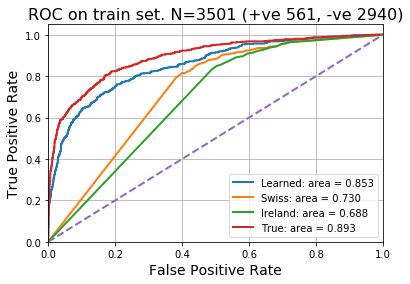

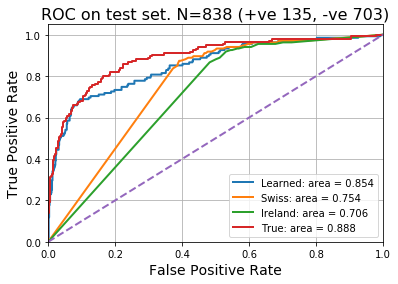

=========== Config 2 of 8: censoring prob +ve 0.1, censoring prob -ve 0 =================
total: 33600, positives: 5312, negatives: 28288


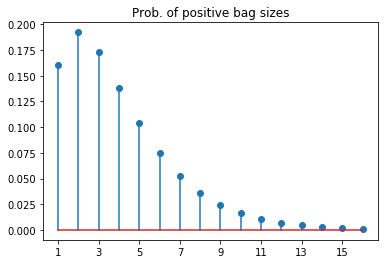

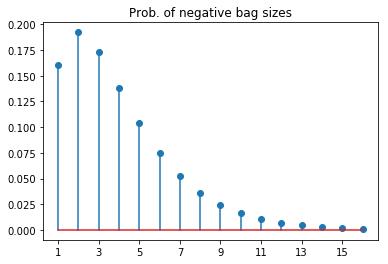

Expected bag sizes:
	Positive bags: 3.969
	Positive bags: 3.969
total: 33600, positives: 5312, negatives: 28288
Empirical Bag sizes:
	 Positive bags: mean size 3.744, median size 3
	 Negative bags: mean size 3.972, median size 3
required -ve exposures: 16250
available -ve exposures: 28288
Assignment matrix size: (4490, 17674) (3569, 17674) (17674, 3)
Train size: 3592(+568/-3024), test size: 898(+142/-756)
Average positive samples per bag: 2.0056338028169014
----------- Trial 1/5: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.002, 0.0, 0.007, 0.004]
	rssi_th: [13.0, 36.0, 13.0]
	infectiousness: [0.01, 0.01, 0.01]
scoring:
	beta: 0.100000
	rssi_w: [0.002, 0.003, 0.009, 0.013]
	rssi_th: [-107.0, -71.0, -58.0]
	infectiousness: [0.01, 0.02, 0.03]
loss at init: sigmoid 0.9136233329772949 / step 0.9056153297424316
Iter 0: batch loss 1.0875, sigmoid_temp 0.100, elapsed time 0.88
Iter 0, full train loss: step-bins 0.5673, loss sigmoid-bins 0.5660
I

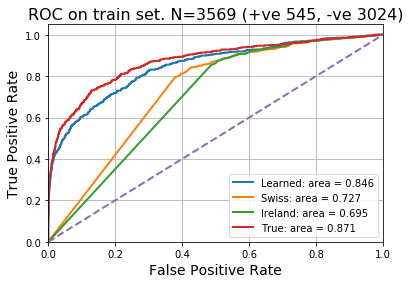

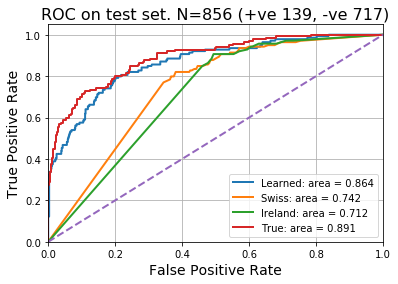

total: 33600, positives: 5393, negatives: 28207


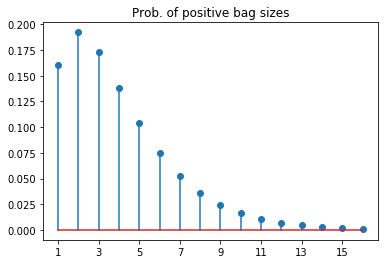

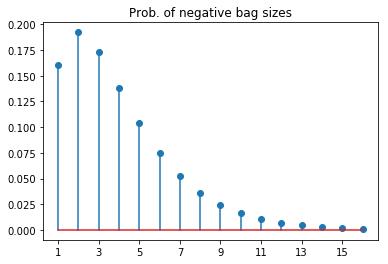

Expected bag sizes:
	Positive bags: 3.969
	Positive bags: 3.969
total: 33600, positives: 5393, negatives: 28207
Empirical Bag sizes:
	 Positive bags: mean size 3.961, median size 3
	 Negative bags: mean size 3.959, median size 3
required -ve exposures: 16077
available -ve exposures: 28207
Assignment matrix size: (4423, 17511) (3521, 17511) (17511, 3)
Train size: 3538(+568/-2970), test size: 885(+142/-743)
Average positive samples per bag: 2.019718309859155
----------- Trial 2/5: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.004, 0.007, 0.008, 0.004]
	rssi_th: [14.0, 19.0, 21.0]
	infectiousness: [0.01, 0.01, 0.0]
scoring:
	beta: 0.100000
	rssi_w: [0.004, 0.011, 0.019, 0.023]
	rssi_th: [-106.0, -87.0, -66.0]
	infectiousness: [0.01, 0.02, 0.02]
loss at init: sigmoid 0.8669756054878235 / step 0.8650943040847778
Iter 0: batch loss 0.7606, sigmoid_temp 0.100, elapsed time 0.68
Iter 0, full train loss: step-bins 0.6457, loss sigmoid-bins 0.6473
I

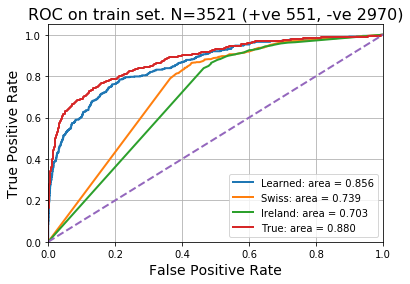

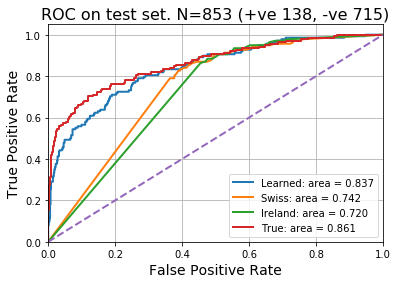

total: 33600, positives: 5442, negatives: 28158


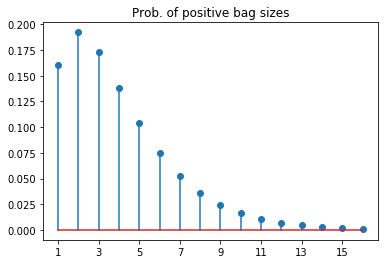

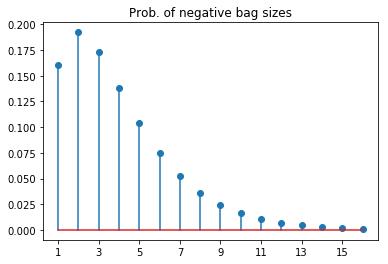

Expected bag sizes:
	Positive bags: 3.969
	Positive bags: 3.969
total: 33600, positives: 5442, negatives: 28158
Empirical Bag sizes:
	 Positive bags: mean size 3.976, median size 3
	 Negative bags: mean size 3.894, median size 3
required -ve exposures: 15735
available -ve exposures: 28158
Assignment matrix size: (4383, 17127) (3484, 17127) (17127, 3)
Train size: 3506(+568/-2938), test size: 877(+142/-735)
Average positive samples per bag: 1.9605633802816902
----------- Trial 3/5: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.009, 0.006, 0.004, 0.007]
	rssi_th: [13.0, 29.0, 38.0]
	infectiousness: [0.01, 0.0, 0.01]
scoring:
	beta: 0.100000
	rssi_w: [0.009, 0.016, 0.019, 0.026]
	rssi_th: [-107.0, -78.0, -40.0]
	infectiousness: [0.01, 0.01, 0.01]
loss at init: sigmoid 0.939939558506012 / step 0.9457972645759583
Iter 0: batch loss 0.8231, sigmoid_temp 0.100, elapsed time 0.66
Iter 0, full train loss: step-bins 0.6537, loss sigmoid-bins 0.6517
I

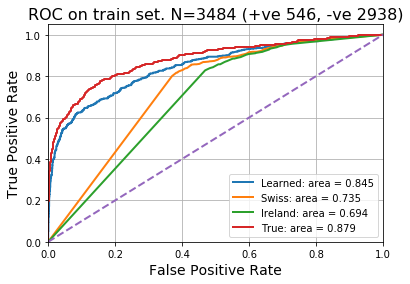

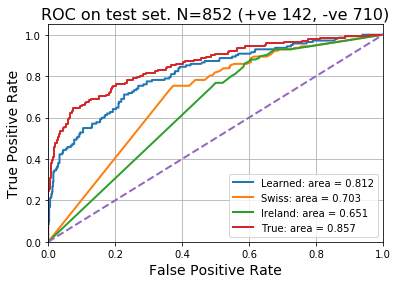

total: 33600, positives: 5329, negatives: 28271


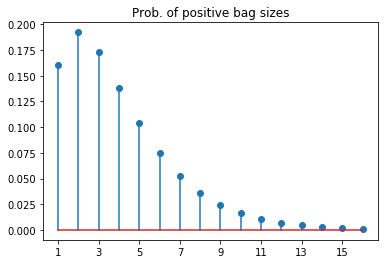

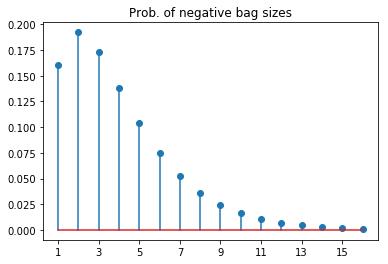

Expected bag sizes:
	Positive bags: 3.969
	Positive bags: 3.969
total: 33600, positives: 5329, negatives: 28271
Empirical Bag sizes:
	 Positive bags: mean size 4.082, median size 3
	 Negative bags: mean size 3.964, median size 3
required -ve exposures: 16420
available -ve exposures: 28271
Assignment matrix size: (4476, 17828) (3563, 17828) (17828, 3)
Train size: 3580(+568/-3012), test size: 896(+142/-754)
Average positive samples per bag: 1.9830985915492958
----------- Trial 4/5: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.009, 0.005, 0.001, 0.007]
	rssi_th: [11.0, 24.0, 37.0]
	infectiousness: [0.0, 0.0, 0.01]
scoring:
	beta: 0.100000
	rssi_w: [0.009, 0.013, 0.014, 0.021]
	rssi_th: [-109.0, -85.0, -48.0]
	infectiousness: [0.0, 0.0, 0.01]
loss at init: sigmoid 1.0980913639068604 / step 1.1078646183013916
Iter 0: batch loss 0.9580, sigmoid_temp 0.100, elapsed time 1.04
Iter 0, full train loss: step-bins 0.5597, loss sigmoid-bins 0.5561
Ite

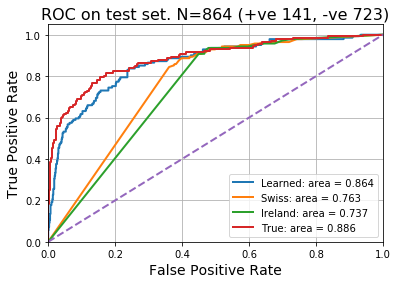

total: 33600, positives: 5378, negatives: 28222


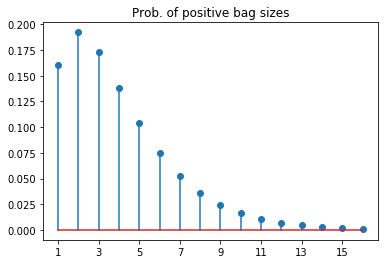

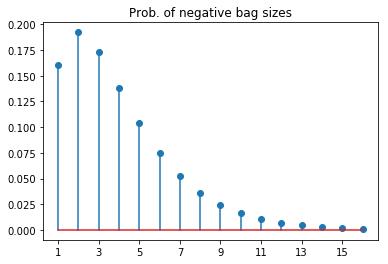

Expected bag sizes:
	Positive bags: 3.969
	Positive bags: 3.969
total: 33600, positives: 5378, negatives: 28222
Empirical Bag sizes:
	 Positive bags: mean size 4.018, median size 3
	 Negative bags: mean size 3.902, median size 3
required -ve exposures: 15972
available -ve exposures: 28222
Assignment matrix size: (4435, 17387) (3529, 17387) (17387, 3)
Train size: 3548(+568/-2980), test size: 887(+142/-745)
Average positive samples per bag: 1.9929577464788732
----------- Trial 5/5: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.008, 0.001, 0.001, 0.0]
	rssi_th: [29.0, 19.0, 20.0]
	infectiousness: [0.0, 0.01, 0.0]
scoring:
	beta: 0.100000
	rssi_w: [0.008, 0.009, 0.01, 0.01]
	rssi_th: [-91.0, -72.0, -52.0]
	infectiousness: [0.0, 0.01, 0.01]
loss at init: sigmoid 1.0414764881134033 / step 1.0515902042388916
Iter 0: batch loss 1.0731, sigmoid_temp 0.100, elapsed time 0.68
Iter 0, full train loss: step-bins 0.5821, loss sigmoid-bins 0.5789
Iter 50

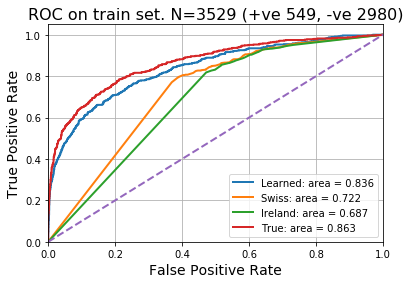

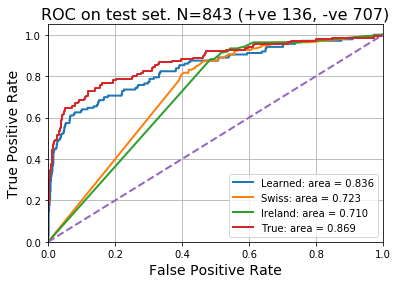

=========== Config 3 of 8: censoring prob +ve 0.2, censoring prob -ve 0 =================
total: 33600, positives: 5449, negatives: 28151


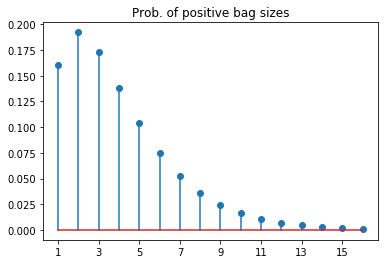

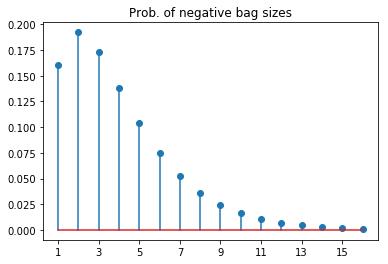

Expected bag sizes:
	Positive bags: 3.969
	Positive bags: 3.969
total: 33600, positives: 5449, negatives: 28151
Empirical Bag sizes:
	 Positive bags: mean size 3.882, median size 3
	 Negative bags: mean size 3.892, median size 3
required -ve exposures: 15614
available -ve exposures: 28151
Assignment matrix size: (4378, 17032) (3474, 17032) (17032, 3)
Train size: 3502(+568/-2934), test size: 876(+142/-734)
Average positive samples per bag: 1.9971830985915493
----------- Trial 1/5: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.003, 0.003, 0.001, 0.008]
	rssi_th: [29.0, 16.0, 26.0]
	infectiousness: [0.0, 0.01, 0.01]
scoring:
	beta: 0.100000
	rssi_w: [0.003, 0.006, 0.008, 0.016]
	rssi_th: [-91.0, -75.0, -49.0]
	infectiousness: [0.0, 0.01, 0.02]
loss at init: sigmoid 1.0101044178009033 / step 1.0289374589920044
Iter 0: batch loss 1.2723, sigmoid_temp 0.100, elapsed time 0.84
Iter 0, full train loss: step-bins 0.5691, loss sigmoid-bins 0.5657
It

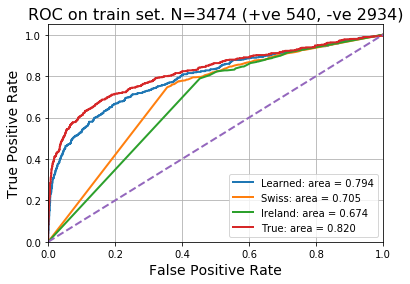

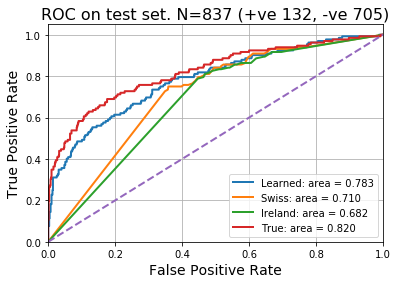

total: 33600, positives: 5380, negatives: 28220


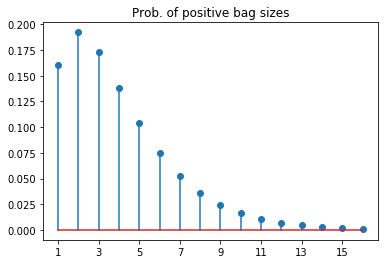

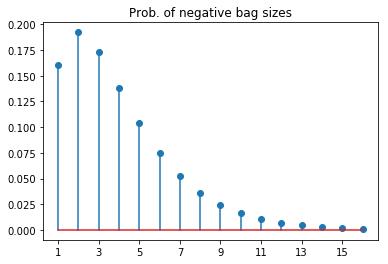

Expected bag sizes:
	Positive bags: 3.969
	Positive bags: 3.969
total: 33600, positives: 5380, negatives: 28220
Empirical Bag sizes:
	 Positive bags: mean size 4.159, median size 4
	 Negative bags: mean size 3.914, median size 3
required -ve exposures: 16096
available -ve exposures: 28220
Assignment matrix size: (4434, 17527) (3509, 17527) (17527, 3)
Train size: 3547(+568/-2979), test size: 887(+142/-745)
Average positive samples per bag: 2.015492957746479
----------- Trial 2/5: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.002, 0.004, 0.004, 0.002]
	rssi_th: [25.0, 21.0, 14.0]
	infectiousness: [0.01, 0.01, 0.0]
scoring:
	beta: 0.100000
	rssi_w: [0.002, 0.007, 0.011, 0.013]
	rssi_th: [-95.0, -74.0, -60.0]
	infectiousness: [0.01, 0.01, 0.02]
loss at init: sigmoid 0.9314755797386169 / step 0.9334191679954529
Iter 0: batch loss 0.9986, sigmoid_temp 0.100, elapsed time 0.81
Iter 0, full train loss: step-bins 0.5853, loss sigmoid-bins 0.5823
It

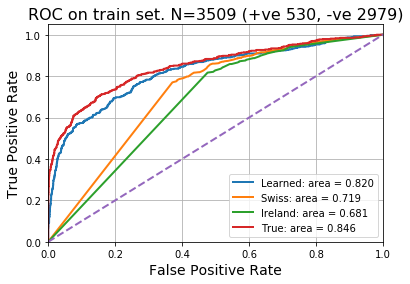

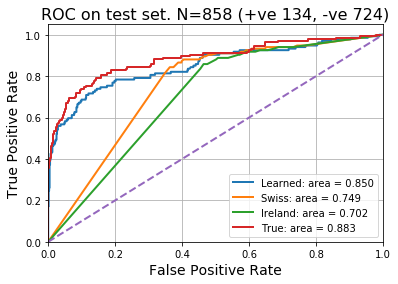

total: 33600, positives: 5448, negatives: 28152


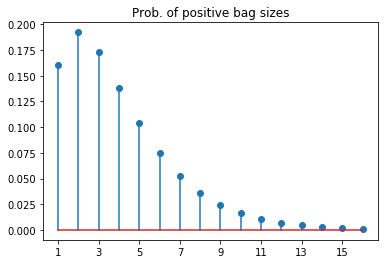

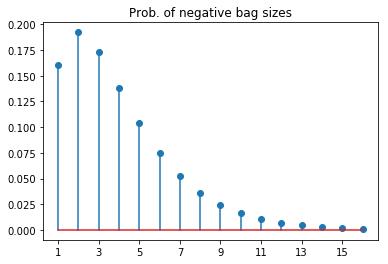

Expected bag sizes:
	Positive bags: 3.969
	Positive bags: 3.969
total: 33600, positives: 5448, negatives: 28152
Empirical Bag sizes:
	 Positive bags: mean size 4.104, median size 3
	 Negative bags: mean size 3.930, median size 3
required -ve exposures: 15911
available -ve exposures: 28152
Assignment matrix size: (4378, 17329) (3467, 17329) (17329, 3)
Train size: 3502(+568/-2934), test size: 876(+142/-734)
Average positive samples per bag: 1.9971830985915493
----------- Trial 3/5: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.01, 0.004, 0.007, 0.007]
	rssi_th: [21.0, 38.0, 12.0]
	infectiousness: [0.01, 0.01, 0.01]
scoring:
	beta: 0.100000
	rssi_w: [0.01, 0.014, 0.021, 0.027]
	rssi_th: [-99.0, -61.0, -49.0]
	infectiousness: [0.01, 0.01, 0.02]
loss at init: sigmoid 0.858553946018219 / step 0.8786478042602539
Iter 0: batch loss 0.4255, sigmoid_temp 0.100, elapsed time 0.50
Iter 0, full train loss: step-bins 0.7490, loss sigmoid-bins 0.7307
Ite

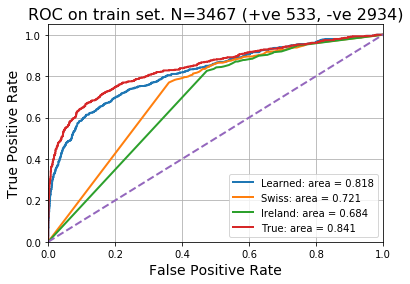

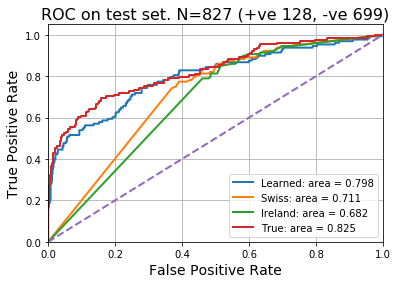

total: 33600, positives: 5474, negatives: 28126


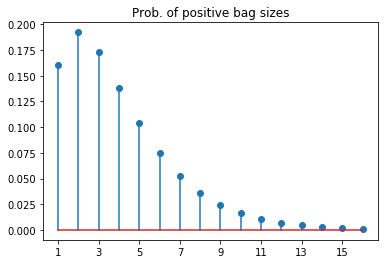

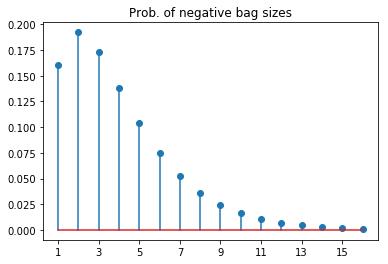

Expected bag sizes:
	Positive bags: 3.969
	Positive bags: 3.969
total: 33600, positives: 5474, negatives: 28126
Empirical Bag sizes:
	 Positive bags: mean size 3.990, median size 3
	 Negative bags: mean size 3.932, median size 3
required -ve exposures: 15753
available -ve exposures: 28126
Assignment matrix size: (4358, 17176) (3448, 17176) (17176, 3)
Train size: 3486(+568/-2918), test size: 872(+142/-730)
Average positive samples per bag: 2.0042253521126763
----------- Trial 4/5: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.007, 0.006, 0.008, 0.002]
	rssi_th: [30.0, 34.0, 38.0]
	infectiousness: [0.01, 0.0, 0.01]
scoring:
	beta: 0.100000
	rssi_w: [0.007, 0.013, 0.02, 0.023]
	rssi_th: [-90.0, -56.0, -18.0]
	infectiousness: [0.01, 0.01, 0.02]
loss at init: sigmoid 0.9454765319824219 / step 0.950187623500824
Iter 0: batch loss 0.8027, sigmoid_temp 0.100, elapsed time 0.81
Iter 0, full train loss: step-bins 0.6844, loss sigmoid-bins 0.6817
Ite

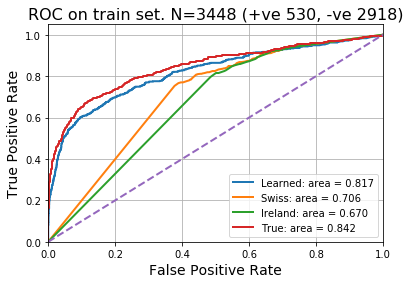

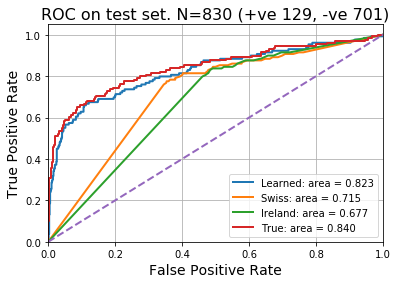

total: 33600, positives: 5394, negatives: 28206


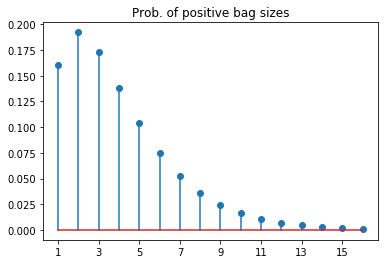

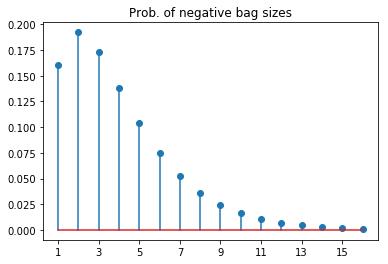

Expected bag sizes:
	Positive bags: 3.969
	Positive bags: 3.969
total: 33600, positives: 5394, negatives: 28206
Empirical Bag sizes:
	 Positive bags: mean size 4.082, median size 4
	 Negative bags: mean size 3.961, median size 3
required -ve exposures: 16148
available -ve exposures: 28206
Assignment matrix size: (4422, 17601) (3498, 17601) (17601, 3)
Train size: 3537(+568/-2969), test size: 885(+142/-743)
Average positive samples per bag: 2.046478873239437
----------- Trial 5/5: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.005, 0.001, 0.0, 0.006]
	rssi_th: [12.0, 29.0, 25.0]
	infectiousness: [0.01, 0.0, 0.01]
scoring:
	beta: 0.100000
	rssi_w: [0.005, 0.006, 0.006, 0.011]
	rssi_th: [-108.0, -79.0, -54.0]
	infectiousness: [0.01, 0.01, 0.02]
loss at init: sigmoid 1.0037195682525635 / step 1.0184980630874634
Iter 0: batch loss 0.8097, sigmoid_temp 0.100, elapsed time 0.81
Iter 0, full train loss: step-bins 0.6145, loss sigmoid-bins 0.6114
Ite

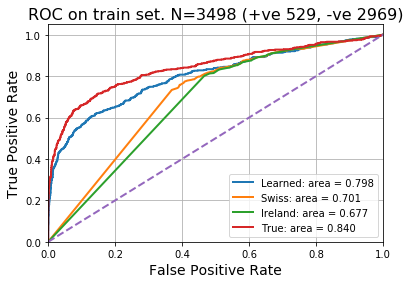

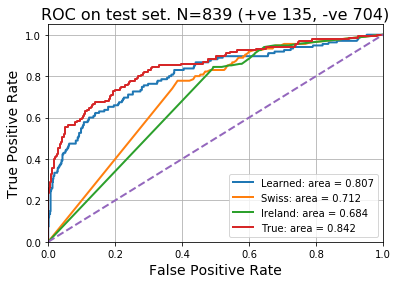

=========== Config 4 of 8: censoring prob +ve 0.3, censoring prob -ve 0 =================
total: 33600, positives: 5402, negatives: 28198


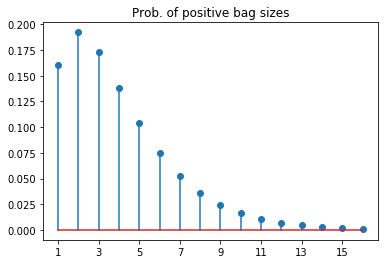

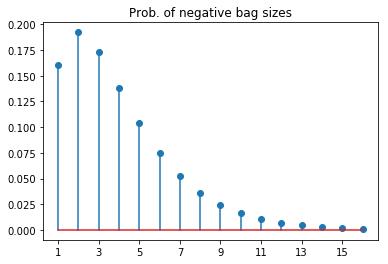

Expected bag sizes:
	Positive bags: 3.969
	Positive bags: 3.969
total: 33600, positives: 5402, negatives: 28198
Empirical Bag sizes:
	 Positive bags: mean size 3.904, median size 3
	 Negative bags: mean size 3.984, median size 3
required -ve exposures: 16115
available -ve exposures: 28198
Assignment matrix size: (4416, 17536) (3466, 17536) (17536, 3)
Train size: 3532(+568/-2964), test size: 884(+142/-742)
Average positive samples per bag: 2.0014084507042256
----------- Trial 1/5: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.002, 0.009, 0.008, 0.005]
	rssi_th: [35.0, 31.0, 31.0]
	infectiousness: [0.0, 0.0, 0.01]
scoring:
	beta: 0.100000
	rssi_w: [0.002, 0.011, 0.018, 0.023]
	rssi_th: [-85.0, -54.0, -23.0]
	infectiousness: [0.0, 0.01, 0.02]
loss at init: sigmoid 0.917134165763855 / step 0.9244922995567322
Iter 0: batch loss 0.9277, sigmoid_temp 0.100, elapsed time 0.91
Iter 0, full train loss: step-bins 0.6288, loss sigmoid-bins 0.6248
Iter

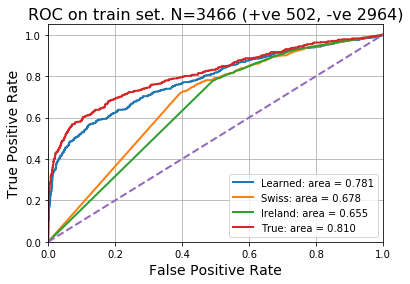

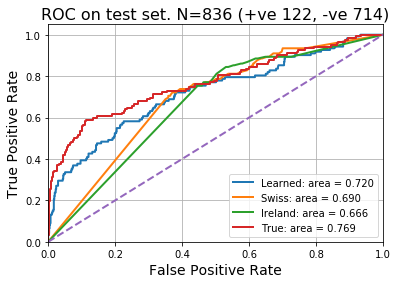

total: 33600, positives: 5379, negatives: 28221


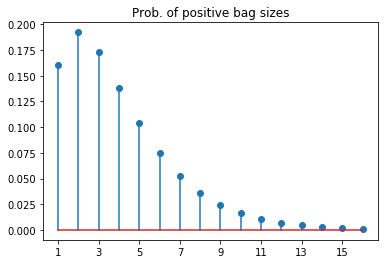

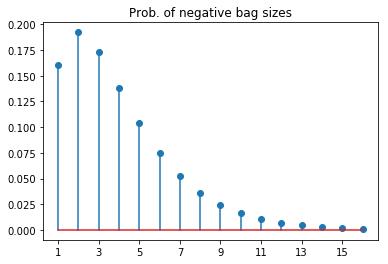

Expected bag sizes:
	Positive bags: 3.969
	Positive bags: 3.969
total: 33600, positives: 5379, negatives: 28221
Empirical Bag sizes:
	 Positive bags: mean size 4.006, median size 3
	 Negative bags: mean size 4.033, median size 3
required -ve exposures: 16463
available -ve exposures: 28221
Assignment matrix size: (4435, 17866) (3488, 17866) (17866, 3)
Train size: 3548(+568/-2980), test size: 887(+142/-745)
Average positive samples per bag: 1.976056338028169
----------- Trial 2/5: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.004, 0.005, 0.001, 0.006]
	rssi_th: [18.0, 14.0, 28.0]
	infectiousness: [0.0, 0.0, 0.01]
scoring:
	beta: 0.100000
	rssi_w: [0.004, 0.009, 0.01, 0.016]
	rssi_th: [-102.0, -88.0, -60.0]
	infectiousness: [0.0, 0.0, 0.01]
loss at init: sigmoid 1.1335372924804688 / step 1.1368372440338135
Iter 0: batch loss 0.8266, sigmoid_temp 0.100, elapsed time 0.83
Iter 0, full train loss: step-bins 0.4855, loss sigmoid-bins 0.4857
Iter 

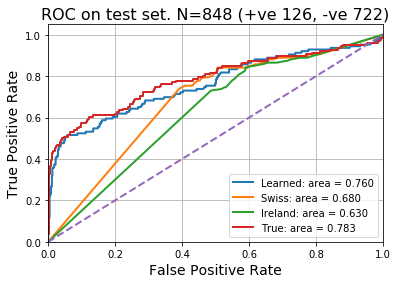

total: 33600, positives: 5381, negatives: 28219


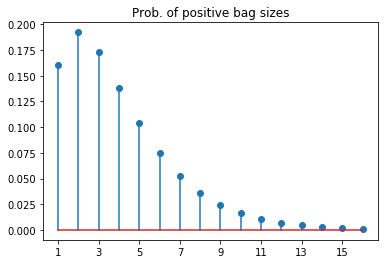

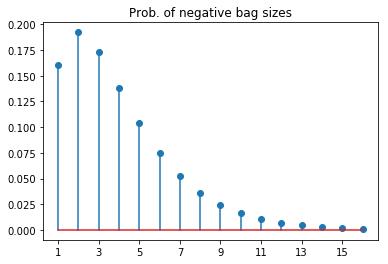

Expected bag sizes:
	Positive bags: 3.969
	Positive bags: 3.969
total: 33600, positives: 5381, negatives: 28219
Empirical Bag sizes:
	 Positive bags: mean size 4.063, median size 3
	 Negative bags: mean size 3.915, median size 3
required -ve exposures: 16085
available -ve exposures: 28219
Assignment matrix size: (4433, 17460) (3488, 17460) (17460, 3)
Train size: 3546(+568/-2978), test size: 887(+142/-745)
Average positive samples per bag: 1.9366197183098592
----------- Trial 3/5: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.007, 0.003, 0.008, 0.005]
	rssi_th: [15.0, 18.0, 39.0]
	infectiousness: [0.0, 0.01, 0.0]
scoring:
	beta: 0.100000
	rssi_w: [0.007, 0.01, 0.018, 0.023]
	rssi_th: [-105.0, -87.0, -48.0]
	infectiousness: [0.0, 0.01, 0.01]
loss at init: sigmoid 0.9720740914344788 / step 0.9746590256690979
Iter 0: batch loss 1.0204, sigmoid_temp 0.100, elapsed time 0.95
Iter 0, full train loss: step-bins 0.5392, loss sigmoid-bins 0.5378
Ite

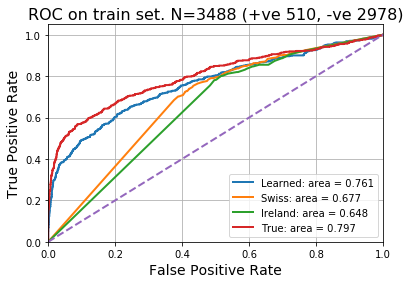

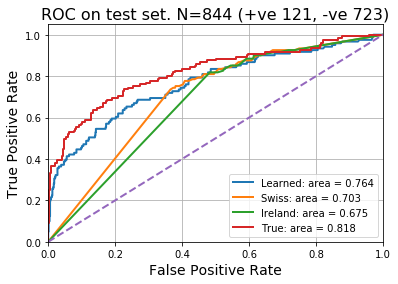

total: 33600, positives: 5391, negatives: 28209


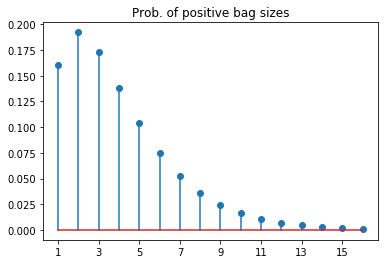

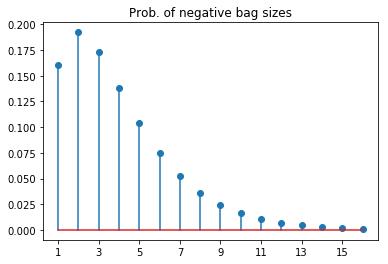

Expected bag sizes:
	Positive bags: 3.969
	Positive bags: 3.969
total: 33600, positives: 5391, negatives: 28209
Empirical Bag sizes:
	 Positive bags: mean size 4.048, median size 3
	 Negative bags: mean size 3.963, median size 3
required -ve exposures: 16168
available -ve exposures: 28209
Assignment matrix size: (4425, 17597) (3487, 17597) (17597, 3)
Train size: 3540(+568/-2972), test size: 885(+142/-743)
Average positive samples per bag: 2.0126760563380284
----------- Trial 4/5: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.004, 0.008, 0.003, 0.003]
	rssi_th: [14.0, 35.0, 24.0]
	infectiousness: [0.01, 0.01, 0.01]
scoring:
	beta: 0.100000
	rssi_w: [0.004, 0.012, 0.016, 0.018]
	rssi_th: [-106.0, -71.0, -47.0]
	infectiousness: [0.01, 0.02, 0.03]
loss at init: sigmoid 0.8270041942596436 / step 0.8302130699157715
Iter 0: batch loss 0.8125, sigmoid_temp 0.100, elapsed time 0.68
Iter 0, full train loss: step-bins 0.6279, loss sigmoid-bins 0.6268

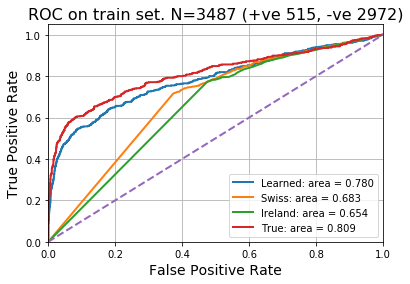

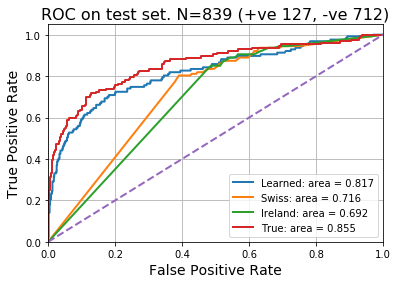

total: 33600, positives: 5356, negatives: 28244


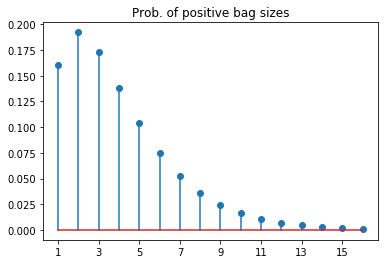

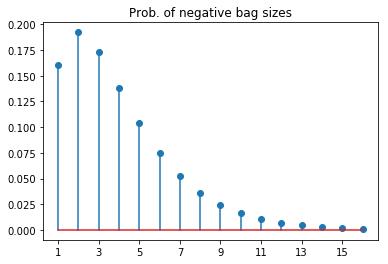

Expected bag sizes:
	Positive bags: 3.969
	Positive bags: 3.969
total: 33600, positives: 5356, negatives: 28244
Empirical Bag sizes:
	 Positive bags: mean size 4.076, median size 3
	 Negative bags: mean size 3.990, median size 3
required -ve exposures: 16438
available -ve exposures: 28244
Assignment matrix size: (4454, 17832) (3506, 17832) (17832, 3)
Train size: 3563(+568/-2995), test size: 891(+142/-749)
Average positive samples per bag: 1.963380281690141
----------- Trial 5/5: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.01, 0.005, 0.006, 0.005]
	rssi_th: [27.0, 30.0, 38.0]
	infectiousness: [0.01, 0.01, 0.01]
scoring:
	beta: 0.100000
	rssi_w: [0.01, 0.014, 0.02, 0.025]
	rssi_th: [-93.0, -63.0, -25.0]
	infectiousness: [0.01, 0.01, 0.02]
loss at init: sigmoid 0.8504289984703064 / step 0.8534156680107117
Iter 0: batch loss 0.6383, sigmoid_temp 0.100, elapsed time 0.90
Iter 0, full train loss: step-bins 0.6719, loss sigmoid-bins 0.6702
Iter

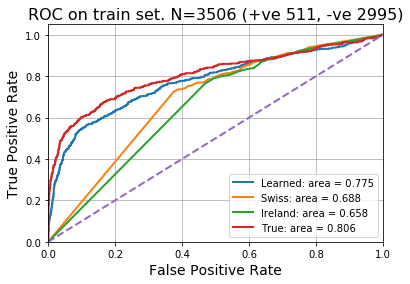

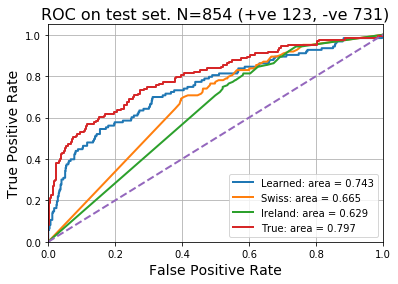

=========== Config 5 of 8: censoring prob +ve 0.4, censoring prob -ve 0 =================
total: 33600, positives: 5376, negatives: 28224


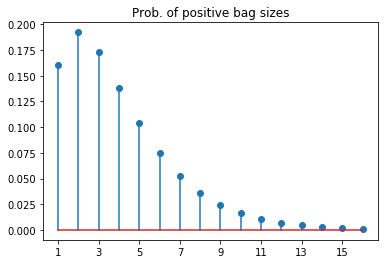

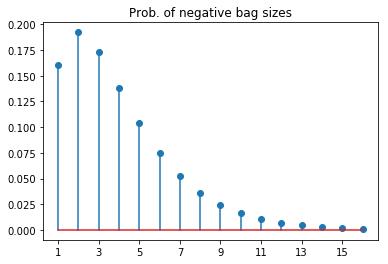

Expected bag sizes:
	Positive bags: 3.969
	Positive bags: 3.969
total: 33600, positives: 5376, negatives: 28224
Empirical Bag sizes:
	 Positive bags: mean size 3.970, median size 3
	 Negative bags: mean size 3.940, median size 3
required -ve exposures: 16084
available -ve exposures: 28224
Assignment matrix size: (4437, 17504) (3477, 17504) (17504, 3)
Train size: 3549(+568/-2981), test size: 888(+142/-746)
Average positive samples per bag: 2.0
----------- Trial 1/5: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.0, 0.002, 0.003, 0.007]
	rssi_th: [19.0, 25.0, 37.0]
	infectiousness: [0.0, 0.01, 0.01]
scoring:
	beta: 0.100000
	rssi_w: [0.0, 0.002, 0.005, 0.013]
	rssi_th: [-101.0, -76.0, -39.0]
	infectiousness: [0.0, 0.01, 0.02]
loss at init: sigmoid 1.045297384262085 / step 1.0543630123138428
Iter 0: batch loss 0.8618, sigmoid_temp 0.100, elapsed time 0.95
Iter 0, full train loss: step-bins 0.5719, loss sigmoid-bins 0.5733
Iter 500: batch loss 

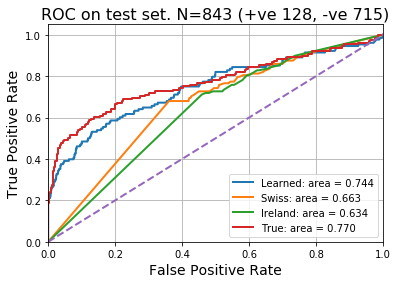

total: 33600, positives: 5361, negatives: 28239


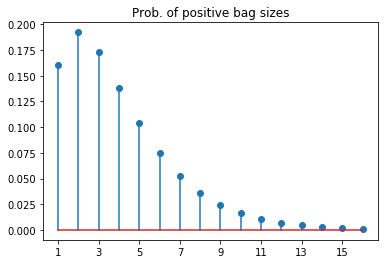

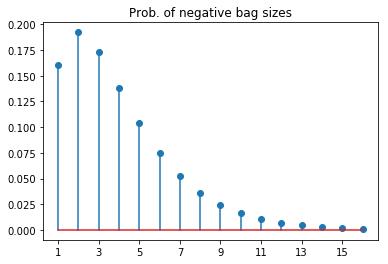

Expected bag sizes:
	Positive bags: 3.969
	Positive bags: 3.969
total: 33600, positives: 5361, negatives: 28239
Empirical Bag sizes:
	 Positive bags: mean size 3.966, median size 4
	 Negative bags: mean size 3.977, median size 3
required -ve exposures: 16244
available -ve exposures: 28239
Assignment matrix size: (4449, 17685) (3478, 17685) (17685, 3)
Train size: 3559(+568/-2991), test size: 890(+142/-748)
Average positive samples per bag: 2.0295774647887326
----------- Trial 2/5: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.006, 0.009, 0.009, 0.002]
	rssi_th: [23.0, 34.0, 16.0]
	infectiousness: [0.0, 0.01, 0.0]
scoring:
	beta: 0.100000
	rssi_w: [0.006, 0.015, 0.024, 0.025]
	rssi_th: [-97.0, -63.0, -47.0]
	infectiousness: [0.0, 0.01, 0.01]
loss at init: sigmoid 0.8575479984283447 / step 0.8683112263679504
Iter 0: batch loss 1.0010, sigmoid_temp 0.100, elapsed time 0.68
Iter 0, full train loss: step-bins 0.5850, loss sigmoid-bins 0.5755
Ite

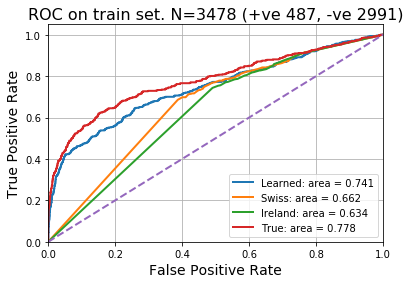

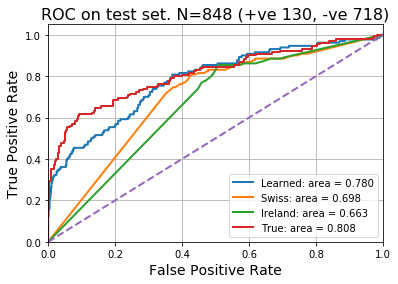

total: 33600, positives: 5348, negatives: 28252


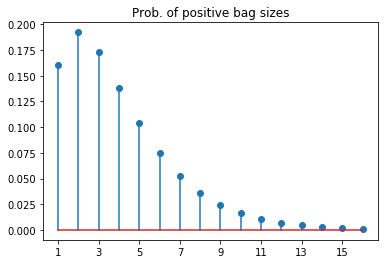

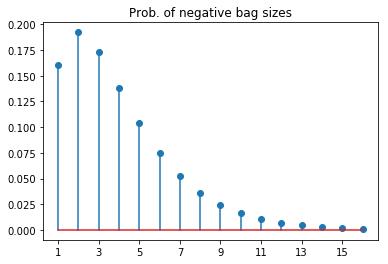

Expected bag sizes:
	Positive bags: 3.969
	Positive bags: 3.969
total: 33600, positives: 5348, negatives: 28252
Empirical Bag sizes:
	 Positive bags: mean size 3.887, median size 3
	 Negative bags: mean size 3.978, median size 3
required -ve exposures: 16246
available -ve exposures: 28252
Assignment matrix size: (4460, 17677) (3487, 17677) (17677, 3)
Train size: 3568(+568/-3000), test size: 892(+142/-750)
Average positive samples per bag: 2.015492957746479
----------- Trial 3/5: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.004, 0.006, 0.006, 0.002]
	rssi_th: [24.0, 33.0, 20.0]
	infectiousness: [0.0, 0.0, 0.01]
scoring:
	beta: 0.100000
	rssi_w: [0.004, 0.01, 0.016, 0.017]
	rssi_th: [-96.0, -63.0, -43.0]
	infectiousness: [0.0, 0.01, 0.01]
loss at init: sigmoid 0.9464831948280334 / step 0.9573513865470886
Iter 0: batch loss 0.9414, sigmoid_temp 0.100, elapsed time 0.67
Iter 0, full train loss: step-bins 0.5967, loss sigmoid-bins 0.5877
Iter 

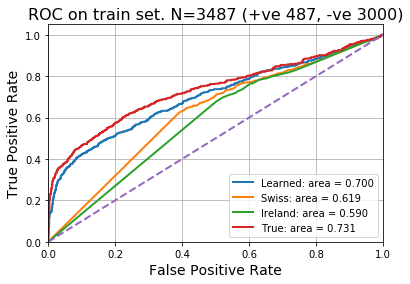

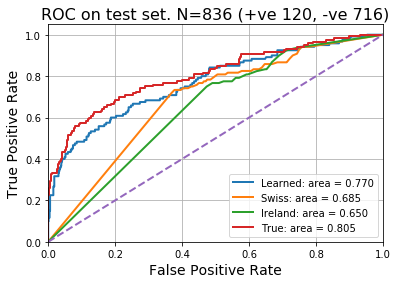

total: 33600, positives: 5395, negatives: 28205


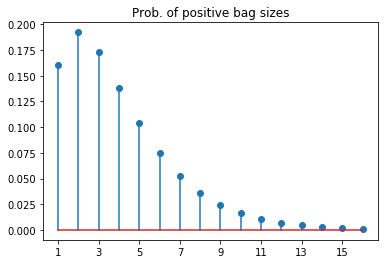

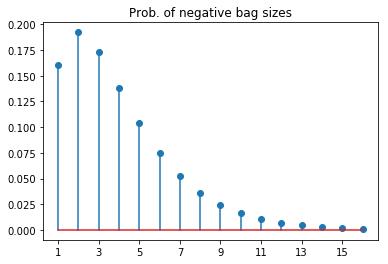

Expected bag sizes:
	Positive bags: 3.969
	Positive bags: 3.969
total: 33600, positives: 5395, negatives: 28205
Empirical Bag sizes:
	 Positive bags: mean size 3.866, median size 3
	 Negative bags: mean size 3.956, median size 3
required -ve exposures: 15970
available -ve exposures: 28205
Assignment matrix size: (4421, 17427) (3460, 17427) (17427, 3)
Train size: 3536(+568/-2968), test size: 885(+142/-743)
Average positive samples per bag: 2.052112676056338
----------- Trial 4/5: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.009, 0.0, 0.008, 0.004]
	rssi_th: [39.0, 39.0, 11.0]
	infectiousness: [0.01, 0.0, 0.01]
scoring:
	beta: 0.100000
	rssi_w: [0.009, 0.009, 0.017, 0.021]
	rssi_th: [-81.0, -42.0, -31.0]
	infectiousness: [0.01, 0.01, 0.02]
loss at init: sigmoid 0.9324887990951538 / step 0.962447464466095
Iter 0: batch loss 1.0872, sigmoid_temp 0.100, elapsed time 0.72
Iter 0, full train loss: step-bins 0.6028, loss sigmoid-bins 0.5901
Iter 

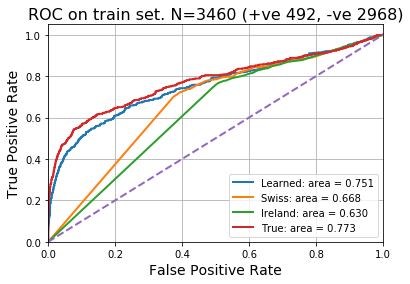

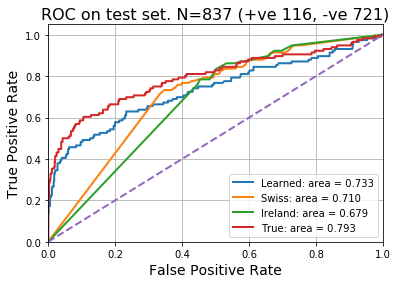

total: 33600, positives: 5442, negatives: 28158


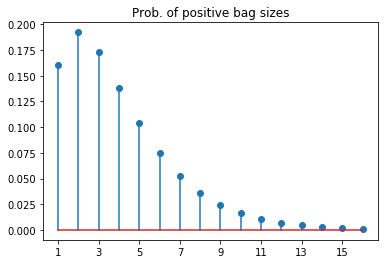

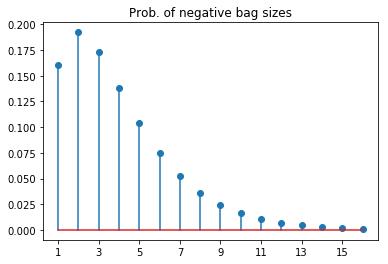

Expected bag sizes:
	Positive bags: 3.969
	Positive bags: 3.969
total: 33600, positives: 5442, negatives: 28158
Empirical Bag sizes:
	 Positive bags: mean size 4.010, median size 3
	 Negative bags: mean size 4.005, median size 3
required -ve exposures: 16143
available -ve exposures: 28158
Assignment matrix size: (4383, 17559) (3437, 17559) (17559, 3)
Train size: 3506(+568/-2938), test size: 877(+142/-735)
Average positive samples per bag: 1.9943661971830986
----------- Trial 5/5: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.004, 0.0, 0.002, 0.01]
	rssi_th: [31.0, 15.0, 23.0]
	infectiousness: [0.0, 0.01, 0.01]
scoring:
	beta: 0.100000
	rssi_w: [0.004, 0.005, 0.007, 0.017]
	rssi_th: [-89.0, -74.0, -51.0]
	infectiousness: [0.0, 0.01, 0.02]
loss at init: sigmoid 0.9862121343612671 / step 1.005265235900879
Iter 0: batch loss 1.1205, sigmoid_temp 0.100, elapsed time 0.59
Iter 0, full train loss: step-bins 0.5758, loss sigmoid-bins 0.5720
Iter 5

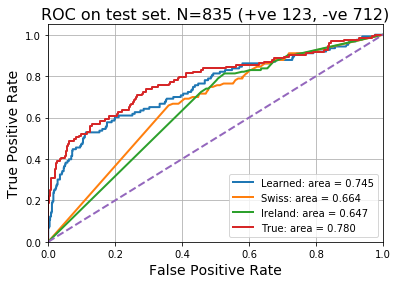

=========== Config 6 of 8: censoring prob +ve 0.5, censoring prob -ve 0 =================
total: 33600, positives: 5338, negatives: 28262


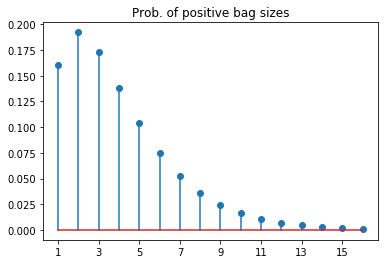

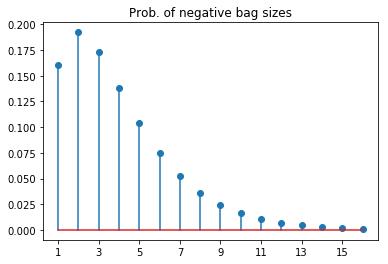

Expected bag sizes:
	Positive bags: 3.969
	Positive bags: 3.969
total: 33600, positives: 5338, negatives: 28262
Empirical Bag sizes:
	 Positive bags: mean size 4.004, median size 3
	 Negative bags: mean size 3.967, median size 3
required -ve exposures: 16307
available -ve exposures: 28262
Assignment matrix size: (4469, 17754) (3473, 17754) (17754, 3)
Train size: 3575(+568/-3007), test size: 894(+142/-752)
Average positive samples per bag: 2.0380281690140847
----------- Trial 1/5: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.0, 0.007, 0.0, 0.003]
	rssi_th: [30.0, 12.0, 26.0]
	infectiousness: [0.0, 0.0, 0.01]
scoring:
	beta: 0.100000
	rssi_w: [0.0, 0.007, 0.008, 0.01]
	rssi_th: [-90.0, -78.0, -52.0]
	infectiousness: [0.0, 0.01, 0.01]
loss at init: sigmoid 0.9957945942878723 / step 1.0031770467758179
Iter 0: batch loss 1.1633, sigmoid_temp 0.100, elapsed time 0.95
Iter 0, full train loss: step-bins 0.4959, loss sigmoid-bins 0.4937
Iter 500: 

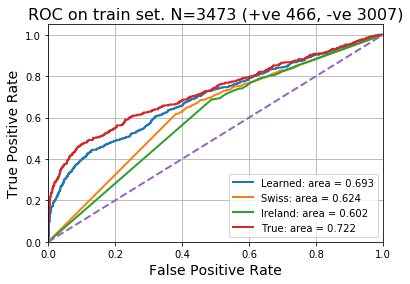

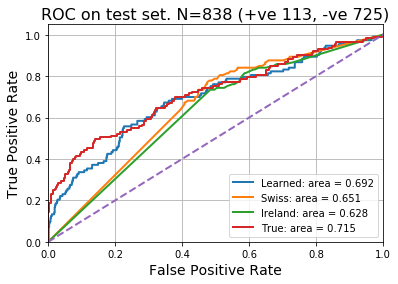

total: 33600, positives: 5434, negatives: 28166


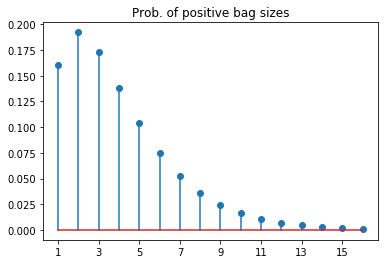

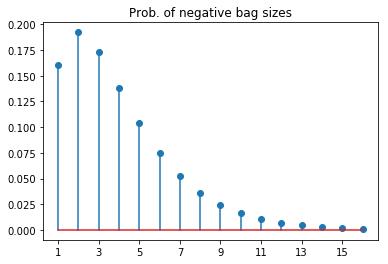

Expected bag sizes:
	Positive bags: 3.969
	Positive bags: 3.969
total: 33600, positives: 5434, negatives: 28166
Empirical Bag sizes:
	 Positive bags: mean size 3.979, median size 3
	 Negative bags: mean size 3.924, median size 3
required -ve exposures: 15824
available -ve exposures: 28166
Assignment matrix size: (4390, 17267) (3411, 17267) (17267, 3)
Train size: 3512(+568/-2944), test size: 878(+142/-736)
Average positive samples per bag: 2.0323943661971833
----------- Trial 2/5: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.007, 0.009, 0.002, 0.003]
	rssi_th: [35.0, 34.0, 12.0]
	infectiousness: [0.0, 0.0, 0.01]
scoring:
	beta: 0.100000
	rssi_w: [0.007, 0.016, 0.018, 0.021]
	rssi_th: [-85.0, -51.0, -39.0]
	infectiousness: [0.0, 0.0, 0.01]
loss at init: sigmoid 1.0470913648605347 / step 1.059110164642334
Iter 0: batch loss 0.8041, sigmoid_temp 0.100, elapsed time 0.66
Iter 0, full train loss: step-bins 0.5553, loss sigmoid-bins 0.5444
Iter 

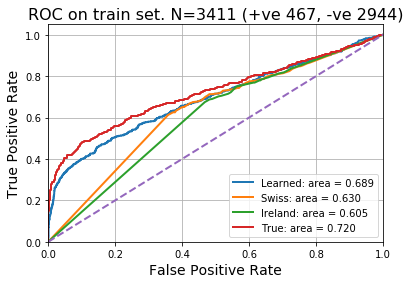

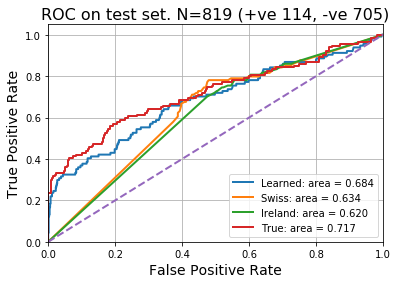

total: 33600, positives: 5388, negatives: 28212


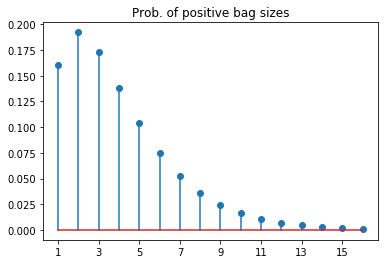

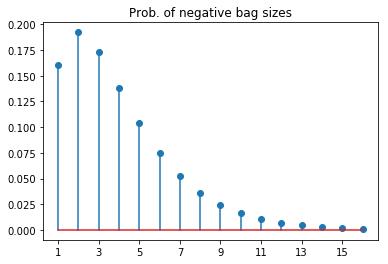

Expected bag sizes:
	Positive bags: 3.969
	Positive bags: 3.969
total: 33600, positives: 5388, negatives: 28212
Empirical Bag sizes:
	 Positive bags: mean size 3.821, median size 3
	 Negative bags: mean size 4.007, median size 3
required -ve exposures: 16167
available -ve exposures: 28212
Assignment matrix size: (4427, 17607) (3440, 17607) (17607, 3)
Train size: 3541(+568/-2973), test size: 886(+142/-744)
Average positive samples per bag: 2.028169014084507
----------- Trial 3/5: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.004, 0.01, 0.008, 0.009]
	rssi_th: [20.0, 28.0, 31.0]
	infectiousness: [0.01, 0.01, 0.01]
scoring:
	beta: 0.100000
	rssi_w: [0.004, 0.014, 0.022, 0.031]
	rssi_th: [-100.0, -72.0, -41.0]
	infectiousness: [0.01, 0.02, 0.02]
loss at init: sigmoid 0.7652311325073242 / step 0.7647939324378967
Iter 0: batch loss 0.7525, sigmoid_temp 0.100, elapsed time 0.67
Iter 0, full train loss: step-bins 0.6244, loss sigmoid-bins 0.6257
I

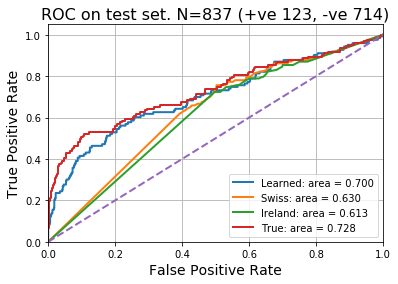

total: 33600, positives: 5381, negatives: 28219


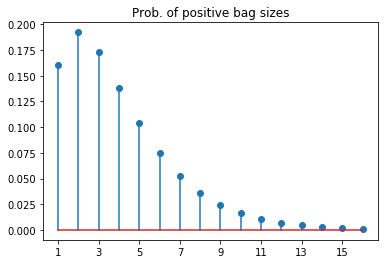

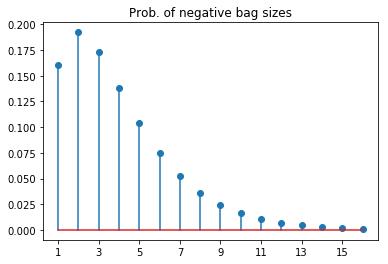

Expected bag sizes:
	Positive bags: 3.969
	Positive bags: 3.969
total: 33600, positives: 5381, negatives: 28219
Empirical Bag sizes:
	 Positive bags: mean size 4.024, median size 3
	 Negative bags: mean size 3.995, median size 3
required -ve exposures: 16301
available -ve exposures: 28219
Assignment matrix size: (4433, 17729) (3449, 17729) (17729, 3)
Train size: 3546(+568/-2978), test size: 887(+142/-745)
Average positive samples per bag: 2.011267605633803
----------- Trial 4/5: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.003, 0.002, 0.005, 0.002]
	rssi_th: [26.0, 39.0, 17.0]
	infectiousness: [0.0, 0.01, 0.0]
scoring:
	beta: 0.100000
	rssi_w: [0.003, 0.005, 0.01, 0.011]
	rssi_th: [-94.0, -55.0, -38.0]
	infectiousness: [0.0, 0.01, 0.01]
loss at init: sigmoid 0.9990509152412415 / step 1.0231655836105347
Iter 0: batch loss 0.9568, sigmoid_temp 0.100, elapsed time 0.68
Iter 0, full train loss: step-bins 0.5597, loss sigmoid-bins 0.5485
Iter 

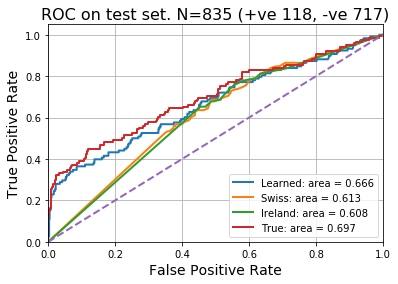

total: 33600, positives: 5393, negatives: 28207


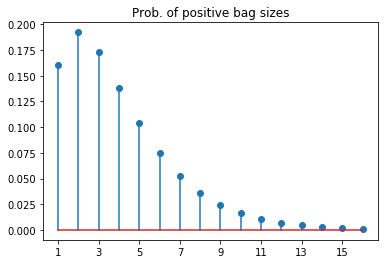

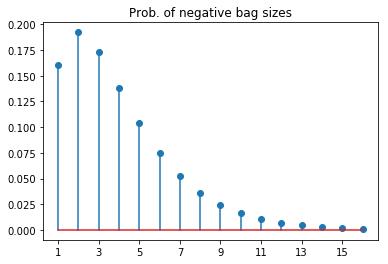

Expected bag sizes:
	Positive bags: 3.969
	Positive bags: 3.969
total: 33600, positives: 5393, negatives: 28207
Empirical Bag sizes:
	 Positive bags: mean size 3.972, median size 3
	 Negative bags: mean size 3.957, median size 3
required -ve exposures: 16036
available -ve exposures: 28207
Assignment matrix size: (4423, 17511) (3447, 17511) (17511, 3)
Train size: 3538(+568/-2970), test size: 885(+142/-743)
Average positive samples per bag: 2.0774647887323945
----------- Trial 5/5: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.007, 0.006, 0.009, 0.004]
	rssi_th: [31.0, 21.0, 18.0]
	infectiousness: [0.01, 0.0, 0.0]
scoring:
	beta: 0.100000
	rssi_w: [0.007, 0.012, 0.021, 0.025]
	rssi_th: [-89.0, -68.0, -50.0]
	infectiousness: [0.01, 0.01, 0.01]
loss at init: sigmoid 0.8344582915306091 / step 0.839878499507904
Iter 0: batch loss 0.8870, sigmoid_temp 0.100, elapsed time 0.48
Iter 0, full train loss: step-bins 0.6025, loss sigmoid-bins 0.5969
Ite

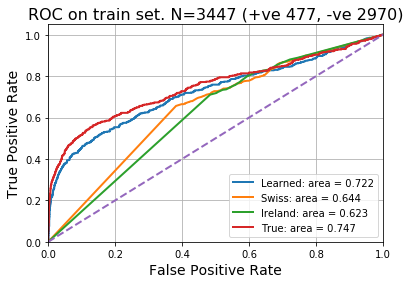

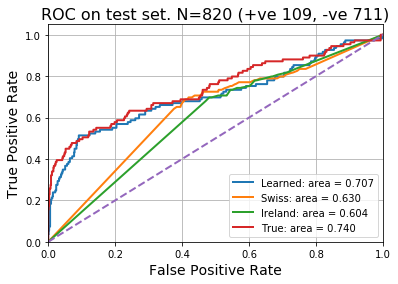

=========== Config 7 of 8: censoring prob +ve 0.6, censoring prob -ve 0 =================
total: 33600, positives: 5429, negatives: 28171


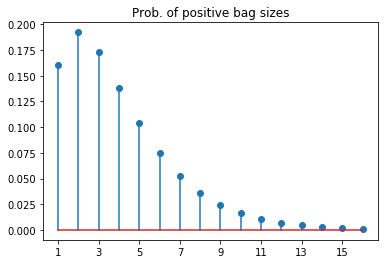

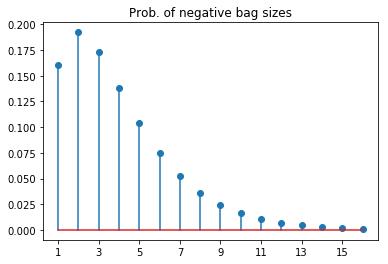

Expected bag sizes:
	Positive bags: 3.969
	Positive bags: 3.969
total: 33600, positives: 5429, negatives: 28171
Empirical Bag sizes:
	 Positive bags: mean size 3.941, median size 3
	 Negative bags: mean size 4.025, median size 3
required -ve exposures: 16223
available -ve exposures: 28171
Assignment matrix size: (4394, 17627) (3391, 17627) (17627, 3)
Train size: 3515(+568/-2947), test size: 879(+142/-737)
Average positive samples per bag: 1.9774647887323944
----------- Trial 1/5: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.003, 0.004, 0.008, 0.003]
	rssi_th: [31.0, 24.0, 21.0]
	infectiousness: [0.01, 0.0, 0.01]
scoring:
	beta: 0.100000
	rssi_w: [0.003, 0.007, 0.015, 0.018]
	rssi_th: [-89.0, -65.0, -44.0]
	infectiousness: [0.01, 0.01, 0.02]
loss at init: sigmoid 0.8626949191093445 / step 0.8725596070289612
Iter 0: batch loss 0.6589, sigmoid_temp 0.100, elapsed time 0.67
Iter 0, full train loss: step-bins 0.6420, loss sigmoid-bins 0.6343
I

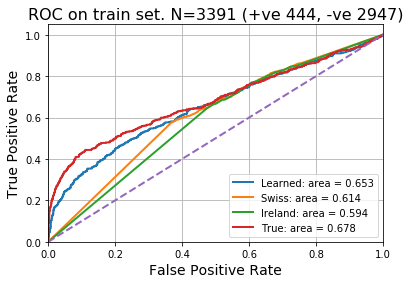

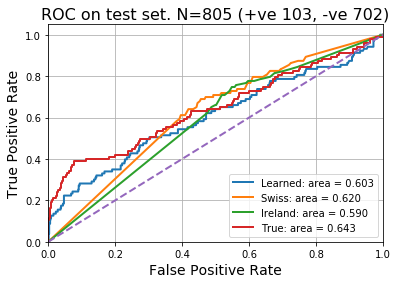

total: 33600, positives: 5383, negatives: 28217


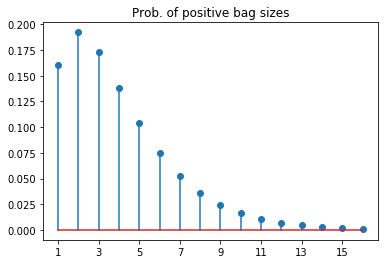

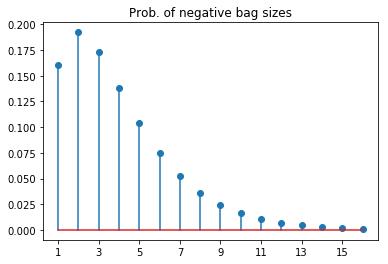

Expected bag sizes:
	Positive bags: 3.969
	Positive bags: 3.969
total: 33600, positives: 5383, negatives: 28217
Empirical Bag sizes:
	 Positive bags: mean size 4.093, median size 3
	 Negative bags: mean size 4.008, median size 3
required -ve exposures: 16379
available -ve exposures: 28217
Assignment matrix size: (4431, 17819) (3430, 17819) (17819, 3)
Train size: 3544(+568/-2976), test size: 887(+142/-745)
Average positive samples per bag: 2.028169014084507
----------- Trial 2/5: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.007, 0.01, 0.001, 0.007]
	rssi_th: [20.0, 36.0, 21.0]
	infectiousness: [0.01, 0.01, 0.01]
scoring:
	beta: 0.100000
	rssi_w: [0.007, 0.016, 0.017, 0.025]
	rssi_th: [-100.0, -64.0, -43.0]
	infectiousness: [0.01, 0.02, 0.02]
loss at init: sigmoid 0.7608960866928101 / step 0.7744879126548767
Iter 0: batch loss 0.6453, sigmoid_temp 0.100, elapsed time 0.69
Iter 0, full train loss: step-bins 0.6328, loss sigmoid-bins 0.6223
I

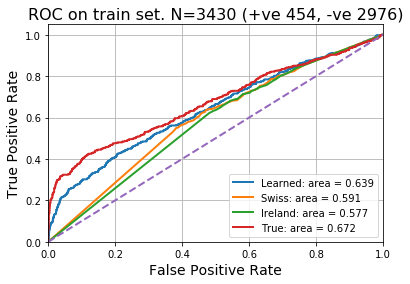

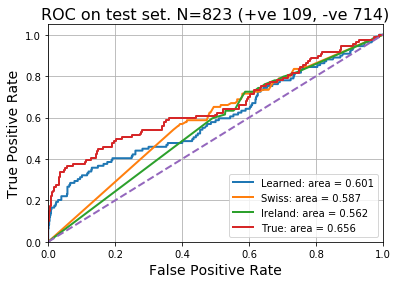

total: 33600, positives: 5393, negatives: 28207


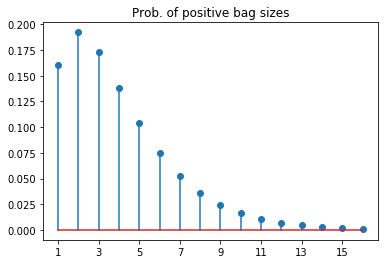

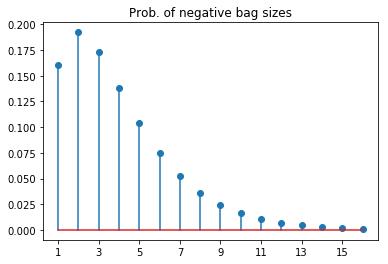

Expected bag sizes:
	Positive bags: 3.969
	Positive bags: 3.969
total: 33600, positives: 5393, negatives: 28207
Empirical Bag sizes:
	 Positive bags: mean size 4.024, median size 3
	 Negative bags: mean size 3.935, median size 3
required -ve exposures: 16075
available -ve exposures: 28207
Assignment matrix size: (4423, 17467) (3426, 17467) (17467, 3)
Train size: 3538(+568/-2970), test size: 885(+142/-743)
Average positive samples per bag: 1.9605633802816902
----------- Trial 3/5: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.007, 0.002, 0.009, 0.007]
	rssi_th: [35.0, 30.0, 14.0]
	infectiousness: [0.01, 0.01, 0.01]
scoring:
	beta: 0.100000
	rssi_w: [0.007, 0.008, 0.017, 0.024]
	rssi_th: [-85.0, -55.0, -41.0]
	infectiousness: [0.01, 0.02, 0.03]
loss at init: sigmoid 0.7931476831436157 / step 0.8278068900108337
Iter 0: batch loss 0.7096, sigmoid_temp 0.100, elapsed time 0.72
Iter 0, full train loss: step-bins 0.6394, loss sigmoid-bins 0.6194


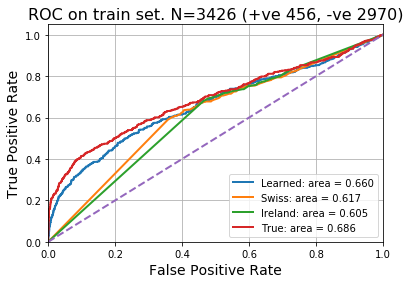

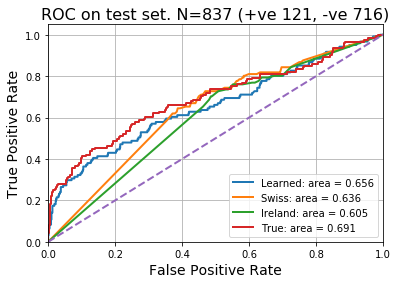

total: 33600, positives: 5392, negatives: 28208


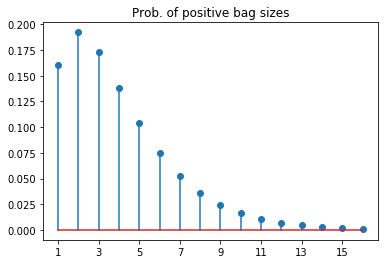

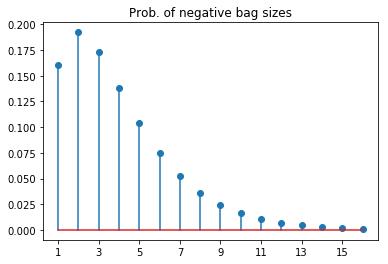

Expected bag sizes:
	Positive bags: 3.969
	Positive bags: 3.969
total: 33600, positives: 5392, negatives: 28208
Empirical Bag sizes:
	 Positive bags: mean size 3.982, median size 3
	 Negative bags: mean size 3.894, median size 3
required -ve exposures: 15861
available -ve exposures: 28208
Assignment matrix size: (4424, 17288) (3425, 17288) (17288, 3)
Train size: 3539(+568/-2971), test size: 885(+142/-743)
Average positive samples per bag: 2.0098591549295777
----------- Trial 4/5: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.009, 0.003, 0.005, 0.003]
	rssi_th: [29.0, 36.0, 25.0]
	infectiousness: [0.01, 0.01, 0.0]
scoring:
	beta: 0.100000
	rssi_w: [0.009, 0.012, 0.017, 0.02]
	rssi_th: [-91.0, -55.0, -30.0]
	infectiousness: [0.01, 0.01, 0.02]
loss at init: sigmoid 0.8226171731948853 / step 0.8351137042045593
Iter 0: batch loss 0.8750, sigmoid_temp 0.100, elapsed time 0.63
Iter 0, full train loss: step-bins 0.6294, loss sigmoid-bins 0.6214
It

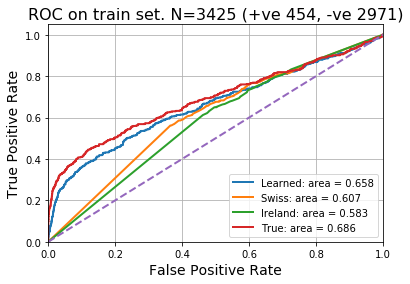

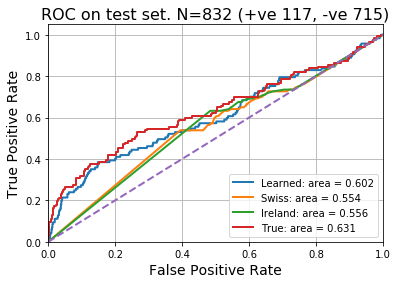

total: 33600, positives: 5427, negatives: 28173


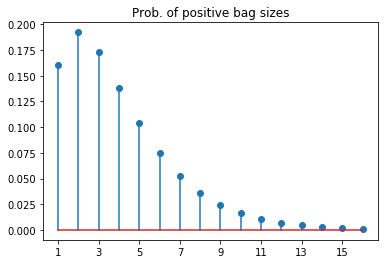

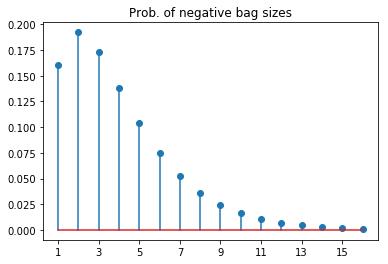

Expected bag sizes:
	Positive bags: 3.969
	Positive bags: 3.969
total: 33600, positives: 5427, negatives: 28173
Empirical Bag sizes:
	 Positive bags: mean size 3.897, median size 3
	 Negative bags: mean size 3.961, median size 3
required -ve exposures: 15974
available -ve exposures: 28173
Assignment matrix size: (4395, 17363) (3392, 17363) (17363, 3)
Train size: 3516(+568/-2948), test size: 879(+142/-737)
Average positive samples per bag: 1.9563380281690141
----------- Trial 5/5: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.001, 0.001, 0.006, 0.009]
	rssi_th: [36.0, 24.0, 39.0]
	infectiousness: [0.0, 0.0, 0.01]
scoring:
	beta: 0.100000
	rssi_w: [0.001, 0.001, 0.007, 0.016]
	rssi_th: [-84.0, -60.0, -21.0]
	infectiousness: [0.0, 0.0, 0.01]
loss at init: sigmoid 1.122437834739685 / step 1.1572695970535278
Iter 0: batch loss 0.8299, sigmoid_temp 0.100, elapsed time 0.68
Iter 0, full train loss: step-bins 0.5584, loss sigmoid-bins 0.5549
Iter 

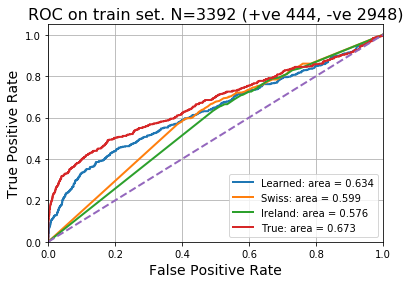

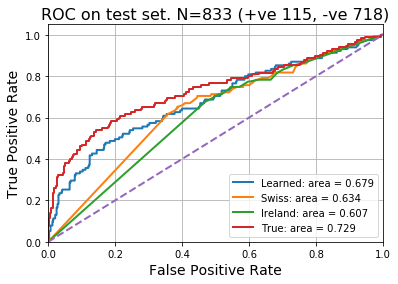

=========== Config 8 of 8: censoring prob +ve 0.7, censoring prob -ve 0 =================
total: 33600, positives: 5456, negatives: 28144


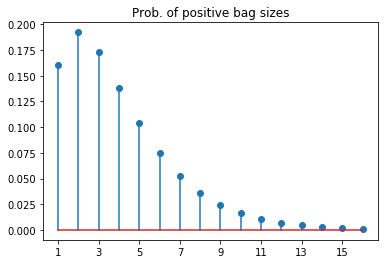

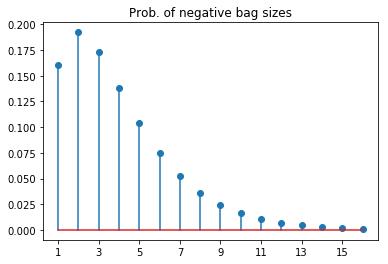

Expected bag sizes:
	Positive bags: 3.969
	Positive bags: 3.969
total: 33600, positives: 5456, negatives: 28144
Empirical Bag sizes:
	 Positive bags: mean size 4.189, median size 4
	 Negative bags: mean size 3.996, median size 3
required -ve exposures: 16159
available -ve exposures: 28144
Assignment matrix size: (4372, 17609) (3367, 17609) (17609, 3)
Train size: 3497(+568/-2929), test size: 875(+142/-733)
Average positive samples per bag: 2.0422535211267605
----------- Trial 1/5: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.005, 0.008, 0.01, 0.0]
	rssi_th: [23.0, 24.0, 32.0]
	infectiousness: [0.01, 0.01, 0.0]
scoring:
	beta: 0.100000
	rssi_w: [0.005, 0.013, 0.023, 0.023]
	rssi_th: [-97.0, -73.0, -41.0]
	infectiousness: [0.01, 0.02, 0.02]
loss at init: sigmoid 0.7615829706192017 / step 0.7523404955863953
Iter 0: batch loss 0.6424, sigmoid_temp 0.100, elapsed time 0.67
Iter 0, full train loss: step-bins 0.6194, loss sigmoid-bins 0.6261
Iter

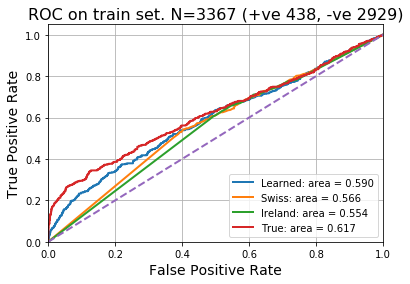

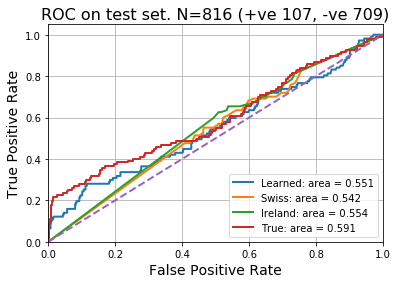

total: 33600, positives: 5385, negatives: 28215


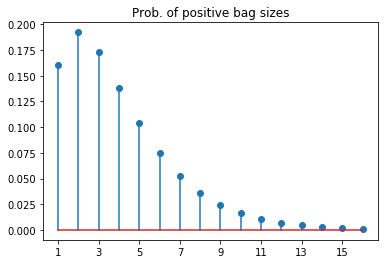

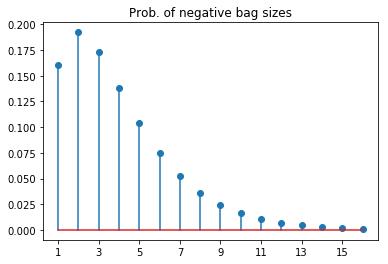

Expected bag sizes:
	Positive bags: 3.969
	Positive bags: 3.969
total: 33600, positives: 5385, negatives: 28215
Empirical Bag sizes:
	 Positive bags: mean size 4.018, median size 3
	 Negative bags: mean size 3.992, median size 3
required -ve exposures: 16281
available -ve exposures: 28215
Assignment matrix size: (4430, 17703) (3420, 17703) (17703, 3)
Train size: 3544(+568/-2976), test size: 886(+142/-744)
Average positive samples per bag: 2.0028169014084507
----------- Trial 2/5: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.008, 0.004, 0.008, 0.007]
	rssi_th: [26.0, 17.0, 16.0]
	infectiousness: [0.0, 0.0, 0.01]
scoring:
	beta: 0.100000
	rssi_w: [0.008, 0.012, 0.02, 0.027]
	rssi_th: [-94.0, -77.0, -61.0]
	infectiousness: [0.0, 0.01, 0.02]
loss at init: sigmoid 0.821452260017395 / step 0.8248096704483032
Iter 0: batch loss 0.9460, sigmoid_temp 0.100, elapsed time 0.49
Iter 0, full train loss: step-bins 0.5467, loss sigmoid-bins 0.5438
Iter 

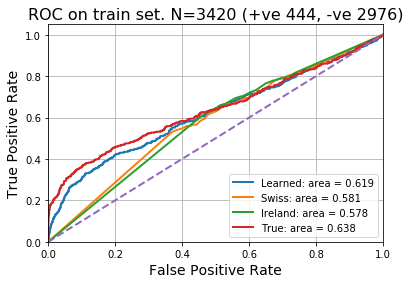

total: 33600, positives: 5352, negatives: 28248


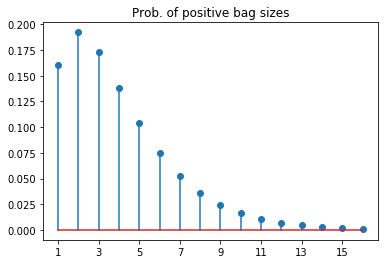

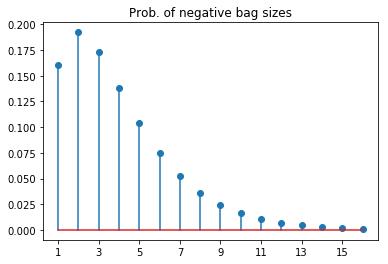

Expected bag sizes:
	Positive bags: 3.969
	Positive bags: 3.969
total: 33600, positives: 5352, negatives: 28248
Empirical Bag sizes:
	 Positive bags: mean size 3.925, median size 3
	 Negative bags: mean size 3.864, median size 3
required -ve exposures: 15852
available -ve exposures: 28248
Assignment matrix size: (4457, 17265) (3422, 17265) (17265, 3)
Train size: 3565(+568/-2997), test size: 892(+142/-750)
Average positive samples per bag: 1.9901408450704225
----------- Trial 3/5: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.01, 0.001, 0.005, 0.002]
	rssi_th: [24.0, 37.0, 36.0]
	infectiousness: [0.01, 0.01, 0.01]
scoring:
	beta: 0.100000
	rssi_w: [0.01, 0.011, 0.016, 0.017]
	rssi_th: [-96.0, -59.0, -23.0]
	infectiousness: [0.01, 0.02, 0.02]
loss at init: sigmoid 0.7652958631515503 / step 0.771794855594635
Iter 0: batch loss 0.7276, sigmoid_temp 0.100, elapsed time 0.67
Iter 0, full train loss: step-bins 0.6064, loss sigmoid-bins 0.6021
Ite

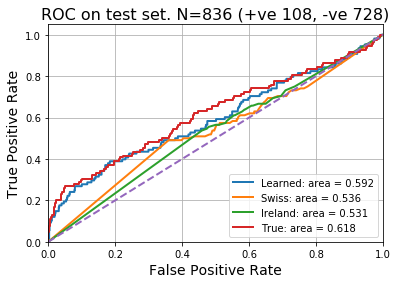

total: 33600, positives: 5321, negatives: 28279


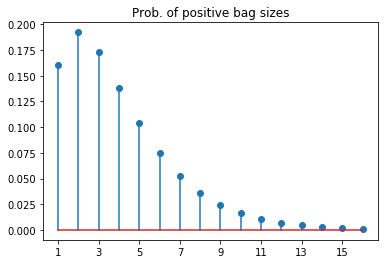

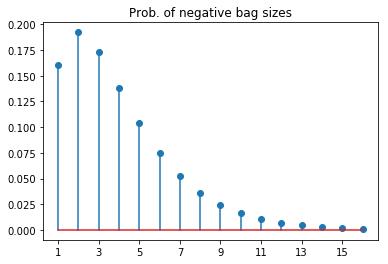

Expected bag sizes:
	Positive bags: 3.969
	Positive bags: 3.969
total: 33600, positives: 5321, negatives: 28279
Empirical Bag sizes:
	 Positive bags: mean size 3.830, median size 3
	 Negative bags: mean size 3.990, median size 3
required -ve exposures: 16380
available -ve exposures: 28279
Assignment matrix size: (4483, 17773) (3460, 17773) (17773, 3)
Train size: 3586(+568/-3018), test size: 897(+142/-755)
Average positive samples per bag: 1.9619718309859155
----------- Trial 4/5: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.007, 0.002, 0.007, 0.006]
	rssi_th: [11.0, 32.0, 10.0]
	infectiousness: [0.01, 0.0, 0.01]
scoring:
	beta: 0.100000
	rssi_w: [0.007, 0.01, 0.017, 0.023]
	rssi_th: [-109.0, -77.0, -67.0]
	infectiousness: [0.01, 0.01, 0.02]
loss at init: sigmoid 0.7757744789123535 / step 0.7742502093315125
Iter 0: batch loss 0.7761, sigmoid_temp 0.100, elapsed time 0.78
Iter 0, full train loss: step-bins 0.5864, loss sigmoid-bins 0.5863
I

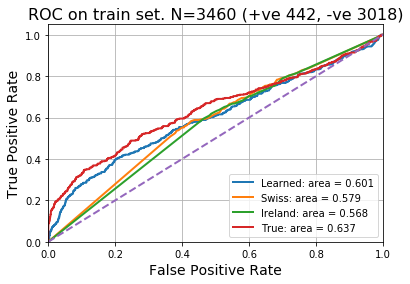

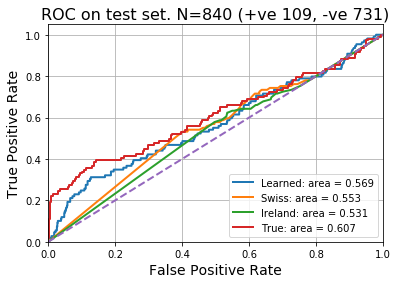

total: 33600, positives: 5374, negatives: 28226


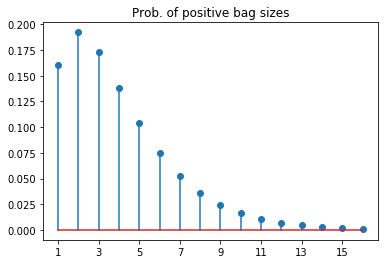

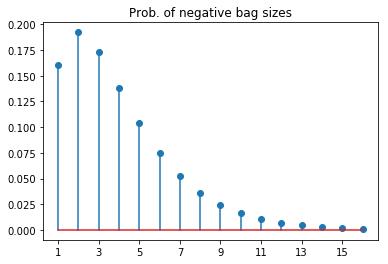

Expected bag sizes:
	Positive bags: 3.969
	Positive bags: 3.969
total: 33600, positives: 5374, negatives: 28226
Empirical Bag sizes:
	 Positive bags: mean size 3.930, median size 3
	 Negative bags: mean size 3.878, median size 3
required -ve exposures: 15833
available -ve exposures: 28226
Assignment matrix size: (4439, 17250) (3396, 17250) (17250, 3)
Train size: 3551(+568/-2983), test size: 888(+142/-746)
Average positive samples per bag: 1.995774647887324
----------- Trial 5/5: Training run 1/10 ----------------
Parameters at init:
residual:
	beta: 0.100000
	rssi_w: [0.003, 0.008, 0.006, 0.004]
	rssi_th: [22.0, 22.0, 37.0]
	infectiousness: [0.0, 0.01, 0.01]
scoring:
	beta: 0.100000
	rssi_w: [0.003, 0.011, 0.017, 0.021]
	rssi_th: [-98.0, -76.0, -39.0]
	infectiousness: [0.0, 0.01, 0.02]
loss at init: sigmoid 0.7575748562812805 / step 0.7541086077690125
Iter 0: batch loss 0.5590, sigmoid_temp 0.100, elapsed time 0.75
Iter 0, full train loss: step-bins 0.6141, loss sigmoid-bins 0.6173
Ite

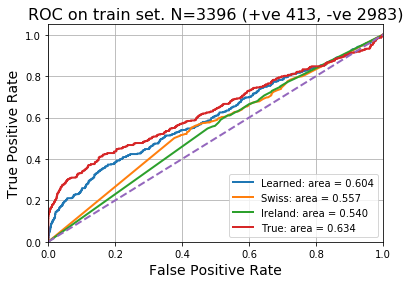

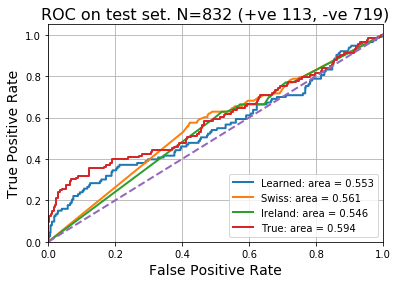

In [ ]:
censor_bag_configs = [
          BagConfig(p_pos=0.6,r_pos=2,p_neg=0.6,r_neg=2,max_bag_size=16,censor_prob_pos=0.05,censor_prob_neg=0),
          BagConfig(p_pos=0.6,r_pos=2,p_neg=0.6,r_neg=2,max_bag_size=16,censor_prob_pos=0.1,censor_prob_neg=0),
          BagConfig(p_pos=0.6,r_pos=2,p_neg=0.6,r_neg=2,max_bag_size=16,censor_prob_pos=0.2,censor_prob_neg=0),
          BagConfig(p_pos=0.6,r_pos=2,p_neg=0.6,r_neg=2,max_bag_size=16,censor_prob_pos=0.3,censor_prob_neg=0),
          BagConfig(p_pos=0.6,r_pos=2,p_neg=0.6,r_neg=2,max_bag_size=16,censor_prob_pos=0.4,censor_prob_neg=0),
          BagConfig(p_pos=0.6,r_pos=2,p_neg=0.6,r_neg=2,max_bag_size=16,censor_prob_pos=0.5,censor_prob_neg=0),
          BagConfig(p_pos=0.6,r_pos=2,p_neg=0.6,r_neg=2,max_bag_size=16,censor_prob_pos=0.6,censor_prob_neg=0),
          BagConfig(p_pos=0.6,r_pos=2,p_neg=0.6,r_neg=2,max_bag_size=16,censor_prob_pos=0.7,censor_prob_neg=0),
]

# train for all bag configurations
auc_train_configs_censor16 = []
auc_test_configs_censor16 = []
for i,bag_config in enumerate(censor_bag_configs):
  print('=========== Config {} of {}: censoring prob +ve {}, censoring prob -ve {} ================='.\
        format(i+1, len(censor_bag_configs), bag_config.censor_prob_pos, bag_config.censor_prob_neg))
  auc_train_trials, auc_test_trials = train_and_eval_with_bag_config(bag_config, pos_neg_ratio, X_epi, Y_epi, probabilities_true_epi,  n_trials=n_trials,n_random_restarts=n_random_restarts_train)
  auc_train_configs_censor16.append(auc_train_trials)
  auc_test_configs_censor16.append(auc_test_trials)




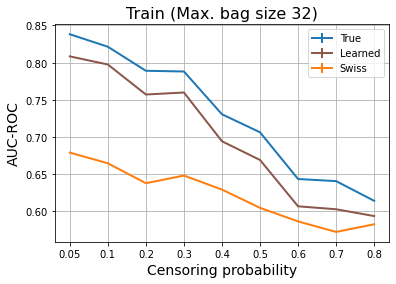

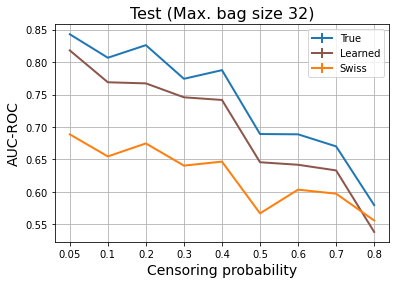

In [ ]:
auc_train_configs_censor = np.array(auc_train_configs_censor) #shape: n_bag_configs X n_trials X n_configs
auc_test_configs_censor = np.array(auc_test_configs_censor)
auc_train_configs_censor_mean = np.mean(auc_train_configs_censor, axis=1)
auc_train_configs_censor_std = np.std(auc_train_configs_censor, axis=1)
auc_test_configs_censor_mean = np.mean(auc_test_configs_censor, axis=1)
auc_test_configs_censor_std = np.std(auc_test_configs_censor, axis=1)
xs = np.arange(auc_train_configs_censor.shape[0], dtype=int)
xticks = [bc.censor_prob_pos for bc in censor_bag_configs]
max_bag_size = censor_bag_configs[0].max_bag_size
labels = ['True', 'Learned', 'Swiss', 'Ireland']
plot_xy([xs,xs,xs], [auc_train_configs_censor_mean[:,-1], auc_train_configs_censor_mean[:,0], auc_train_configs_censor_mean[:,1]], [2]*3, labels, ['-']*3, \
        'Censoring probability', 'AUC-ROC', 'Train (Max. bag size {})'.format(max_bag_size), 
        yerr=[auc_train_configs_censor_std[:,-1], 
        auc_train_configs_censor_std[:,0], auc_train_configs_censor_std[:,1]], 
        xticks=xticks, legend_loc="best", colors=['tab:blue', 'tab:brown', 'tab:orange'])
plot_xy([xs,xs,xs], [auc_test_configs_censor_mean[:,-1], auc_test_configs_censor_mean[:,0], auc_test_configs_censor_mean[:,1]], [2]*3, labels, ['-']*3, \
        'Censoring probability', 'AUC-ROC', 'Test (Max. bag size {})'.format(max_bag_size), 
        yerr=[auc_test_configs_censor_std[:,-1], 
        auc_test_configs_censor_std[:,0], auc_test_configs_censor_std[:,1]], 
        xticks=xticks, legend_loc="best", colors=['tab:blue', 'tab:brown', 'tab:orange'])

